<a href="https://colab.research.google.com/github/erlenman/SOS/blob/master/DevFest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
import numpy as np
import pandas as pd
import random

In [0]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,5)

# Define layers

In [0]:
from tensorflow.python.keras.utils import tf_utils
class poly_relu(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
      super(poly_relu, self).__init__(**kwargs)

    def build(self, input_shape):
      self.alpha = self.add_weight(
          shape=(3,input_shape[1]),
          name='alpha',
          trainable=True)
      self.beta = self.add_weight(
          shape=(3,input_shape[1]),
          name='beta',
          trainable=True)
      # Set input spec
      axes = {}

    def call(self, inputs):
      pos = tf.keras.backend.relu(inputs)
      pos = self.alpha[0] * tf.pow(pos,3) * self.alpha[1] * tf.pow(pos,2) + self.alpha[0] * pos
      neg = tf.keras.backend.relu(-inputs)
      neg = -self.beta[0] * tf.pow(neg,3) -self.beta[1] * tf.pow(neg,2) -self.beta[2] * neg
      return pos + neg

    def compute_output_shape(self, input_shape):
      return input_shape

In [0]:
from tensorflow.python.keras.utils import tf_utils
class clockface_relu(tf.keras.layers.Layer):

    def __init__(self,
                alpha_initializer='zeros',
                alpha_regularizer=None,
                alpha_constraint=None,
                shared_axes=None,
                **kwargs):
      super(clockface_relu, self).__init__(**kwargs)
      self.supports_masking = True
      self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)
      self.alpha_regularizer = tf.keras.regularizers.get(alpha_regularizer)
      self.alpha_constraint = tf.keras.constraints.get(alpha_constraint)
      if shared_axes is None:
        self.shared_axes = None
      elif not isinstance(shared_axes, (list, tuple)):
        self.shared_axes = [shared_axes]
      else:
        self.shared_axes = list(shared_axes)

    @tf_utils.shape_type_conversion
    def build(self, input_shape):
      param_shape = list(input_shape[1:])
      if self.shared_axes is not None:
        for i in self.shared_axes:
          param_shape[i - 1] = 1
      self.alpha = self.add_weight(
          shape=param_shape,
          name='alpha',
          initializer=self.alpha_initializer,
          regularizer=self.alpha_regularizer,
          constraint=self.alpha_constraint)
      self.beta = self.add_weight(
          shape=param_shape,
          name='beta',
          initializer=self.alpha_initializer,
          regularizer=self.alpha_regularizer,
          constraint=self.alpha_constraint)
      # Set input spec
      axes = {}
      if self.shared_axes:
        for i in range(1, len(input_shape)):
          if i not in self.shared_axes:
            axes[i] = input_shape[i]
      self.input_spec = tf.keras.layers.InputSpec(ndim=len(input_shape), axes=axes)
      self.built = True

    def call(self, inputs):
      pos = self.alpha * tf.keras.backend.relu(inputs)
      neg = -self.beta * tf.keras.backend.relu(-inputs)
      return pos + neg

    def get_config(self):
      config = {
          'alpha_initializer': tf.keras.initializers.serialize(self.alpha_initializer),
          'alpha_regularizer': tf.keras.regularizers.serialize(self.alpha_regularizer),
          'alpha_constraint': tf.keras.constraints.serialize(self.alpha_constraint),
          'shared_axes': self.shared_axes
      }
      base_config = super(sprelu, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

    @tf_utils.shape_type_conversion
    def compute_output_shape(self, input_shape):
      return input_shape

# Define helpers

In [0]:
def boxplot_sorted(df, by, column, c = 'red'):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    df2[meds.index].boxplot(grid = True, vert = True,
                            notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color='k'),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color='k'))

In [0]:
import time
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [0]:
def get_model(neurons = 128, layer = tf.keras.layers.ReLU, name = 'hidden'):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Dense(neurons, activation='linear'))
    
    if name == 'SeLU':
        model.add(layer(activation = tf.keras.activations.selu, name = name))
    elif name == 'Sigmoid':
        model.add(layer(activation = tf.keras.activations.sigmoid, name = name))
    else:
        model.add(layer(name = name))

    model.add(tf.keras.layers.Dropout(0.2),)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
    return(model)

In [0]:
def show_model(layer = 'ReLU', neurons = 128, epochs = 10, silent = False):
  model = get_model(neurons, layer = layers[layer], name = layer)
  es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                min_delta=0,
                                patience=3,
                                verbose=0, mode='auto')
  th = TimeHistory()
  history = model.fit(x_train, y_train, epochs=epochs, validation_split=0.25, verbose=1, callbacks=[es,th])
  history = history.history
  history['time'] = th.times
  acc = model.evaluate(x_test,  y_test, verbose=2)
  if not silent:
    # Plot training & validation accuracy values
    fig = plt.figure(figsize = (16,8))
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('%s model\nAccuracy: %.2f\nLoss: %.2f'%(layer, acc[1],acc[0]))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

  return(history, model)

# Experiment parameters

In [0]:
epochs = 25
neurons = 256

In [0]:
layers = {#'Sigmoid':tf.keras.layers.Activation,
          #'ReLU':tf.keras.layers.ReLU,
          #'SeLU':tf.keras.layers.Activation,
          #'PReLU':tf.keras.layers.PReLU,
          #'LeakyReLU':tf.keras.layers.LeakyReLU,
          #'ELU':tf.keras.layers.ELU,
          'Clockface':clockface_relu,
          'APAF':poly_relu}

In [0]:
data = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Experiment

Training Clockface
Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 7s 159us/sample - loss: 0.5447 - accuracy: 0.8101 - val_loss: 0.4546 - val_accuracy: 0.8323
Epoch 2/25
45000/45000 [==============================] - 6s 134us/sample - loss: 0.4362 - accuracy: 0.8452 - val_loss: 0.4186 - val_accuracy: 0.8540
Epoch 3/25
45000/45000 [==============================] - 6s 135us/sample - loss: 0.3974 - accuracy: 0.8566 - val_loss: 0.3977 - val_accuracy: 0.8573
Epoch 4/25
45000/45000 [==============================] - 6s 135us/sample - loss: 0.3778 - accuracy: 0.8631 - val_loss: 0.3794 - val_accuracy: 0.8659
Epoch 5/25
45000/45000 [==============================] - 6s 133us/sample - loss: 0.3628 - accuracy: 0.8679 - val_loss: 0.3752 - val_accuracy: 0.8647
Epoch 6/25
45000/45000 [==============================] - 6s 133us/sample - loss: 0.3510 - accuracy: 0.8714 - val_loss: 0.3382 - val_accuracy: 0.8773
Epoch 7/25
45000/45000 [=======

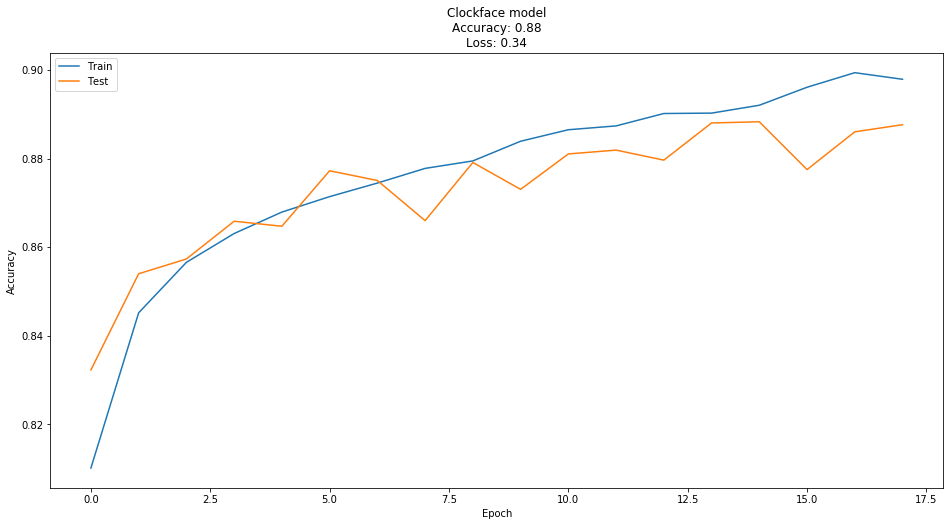

10000/1 - 1s - loss: 0.2309 - accuracy: 0.8811
Training APAF
Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 8s 170us/sample - loss: 0.5740 - accuracy: 0.8065 - val_loss: 0.6389 - val_accuracy: 0.8076
Epoch 2/25
45000/45000 [==============================] - 7s 151us/sample - loss: 0.4694 - accuracy: 0.8354 - val_loss: 0.5109 - val_accuracy: 0.8371
Epoch 3/25
45000/45000 [==============================] - 7s 151us/sample - loss: 0.4402 - accuracy: 0.8460 - val_loss: 0.4738 - val_accuracy: 0.8361
Epoch 4/25
45000/45000 [==============================] - 7s 152us/sample - loss: 0.4215 - accuracy: 0.8509 - val_loss: 0.4566 - val_accuracy: 0.8452
Epoch 5/25
45000/45000 [==============================] - 7s 153us/sample - loss: 0.4062 - accuracy: 0.8570 - val_loss: 0.4141 - val_accuracy: 0.8603
Epoch 6/25
45000/45000 [==============================] - 7s 150us/sample - loss: 0.3867 - accuracy: 0.8614 - val_loss: 0.4575 - val_accura

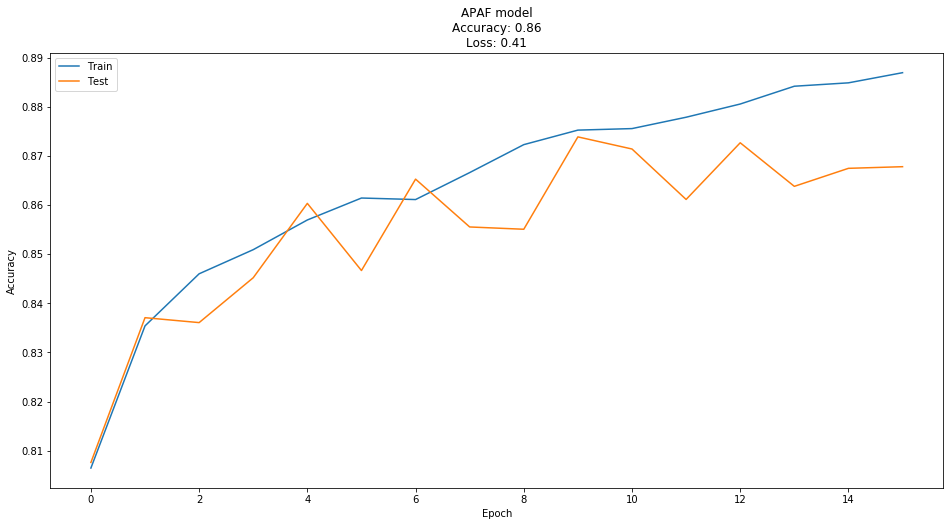

10000/1 - 1s - loss: 0.3065 - accuracy: 0.8588
CPU times: user 4min 37s, sys: 22.9 s, total: 5min
Wall time: 3min 43s


In [0]:
%%time
models = {}
results = {}
hst = {}
for layer in layers:
    print('Training', layer)
    hst[layer],models[layer] = show_model(layer, neurons, epochs)
    loss, acc = models[layer].evaluate(x_test,  y_test, verbose=2)
    results[layer] = {'Loss':loss,'Accuracy':acc}

In [0]:
models

{'APAF': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fd4d003c940>,
 'Clockface': <tensorflow.python.keras.engine.sequential.Sequential at 0x7fd4de1319e8>}

In [0]:
{m:len(h['time']) for m,h in hst.items()}

{'APAF': 16, 'Clockface': 18}

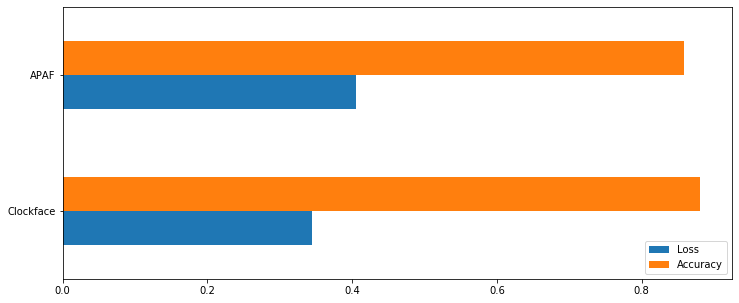

In [0]:
pd.DataFrame(results).T.plot(kind = 'barh')

In [0]:
for model in models:
    print(model, np.array(models[model].get_layer(model).get_weights()).shape)

Clockface (2, 256)
APAF (2, 3, 256)


# Plots

In [0]:
beta = models['PReLU'].get_layer('PReLU').get_weights()[0]
plt.hist(beta, bins = 50)

In [0]:
alpha = np.array(models['PReLU'].get_layer(index = 4).get_weights())[1]

In [0]:
plt.plot(beta,alpha,'o')

In [0]:
inputs = np.linspace(-1,1)
scale = 0.025
frame = 1.
for a,b in zip(alpha,beta):
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot(a+inputs*scale,-b+output*scale,)
#plt.xlim((-frame,frame))
#plt.ylim((-frame,frame))

In [0]:
scale = 0.025
frame = 2
x = np.linspace(-frame, frame, 50)
y = np.linspace(-frame, frame, 50)
X, Y = np.meshgrid(x, y)
grid = np.c_[X.flatten(),Y.flatten()]
for a,b in grid:
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot(a+inputs*scale, -b+output*scale, color = 'k')
#plt.xlim((-frame,frame))
#plt.ylim((-frame,frame))

plt.plot(alpha,beta,'o')

## Clockface

In [0]:
%%time
alphas,betas = [],[]
model = get_model(neurons, layer = layers['Clockface'], name = 'Clockface')
for epoch in range(100):
  rix = random.choices(range(len(x_train)), k = 10000)
  history = model.fit(x_train[rix], y_train[rix], epochs=1, validation_split=0.25, verbose=1)
  alpha,beta = model.get_layer('Clockface').get_weights()
  alphas.append(alpha)
  betas.append(beta)
#acc = model.evaluate(x_test,  y_test, verbose=2)

In [0]:
import matplotlib.animation
from IPython.display import HTML

plt.rcParams['animation.embed_limit'] = 50 # animation size limit in megabytes

#extremes = np.array([np.min(x), np.max(x)]) # edge points for line

fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
# stable data

# animated data
l, = ax.plot([],[], 'o')

def animate(i): # animation function is called on each frame
      l.set_data(betas[i],alphas[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(len(alphas)))

HTML(ani.to_jshtml())
#HTML(ani.to_html5_video())

In [0]:
s = models['Clockface'].get_layer('Clockface')
#s = model.get_layer('Clockface')
alpha,beta = s.get_weights()

In [0]:
plt.figure(figsize = (10,10))
plt.plot(beta,alpha,'o')

plt.title('Adaptive ReLU weights distribution')

In [0]:
plt.figure(figsize = (8,8))
inputs = np.linspace(-1,1)
scale = 0.05
frame = 1.
for a,b in zip(alpha,beta):
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot( -b+inputs*scale,a+output*scale,)
#plt.xlim((-frame,frame))
#plt.ylim((-frame,frame))
plt.title('Adaptive ReLU shapes')
    

In [0]:
plt.figure(figsize = (8,8))
scale = 0.02
frame = 2
x = np.linspace(-frame, frame, 25)
y = np.linspace(-frame, frame, 25)
X, Y = np.meshgrid(x, y)
grid = np.c_[X.flatten(),Y.flatten()]
for a,b in grid:
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot(-b+inputs*scale,a+output*scale,  color = 'k')
plt.xlim((-frame,frame))
plt.ylim((-frame,frame))

plt.plot(beta,alpha,'o')
plt.title('Adaptive ReLU weights space')

In [0]:
import matplotlib.animation
from IPython.display import HTML

plt.rcParams['animation.embed_limit'] = 500 # animation size limit in megabytes

#extremes = np.array([np.min(x), np.max(x)]) # edge points for line

fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
# stable data
x = np.linspace(-frame, frame, 10)
y = np.linspace(-frame, frame, 10)
X, Y = np.meshgrid(x, y)
grid = np.c_[X.flatten(),Y.flatten()]
# animated data
line, = ax.plot([],[], '-')

inputs = np.linspace(-3,3, 200)
def animate(i): # animation function is called on each frame
    a,b = grid[i]
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    line.set_data(inputs,output)


ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(len(grid)))

HTML(ani.to_jshtml())
#HTML(ani.to_html5_video())

In [0]:
df = pd.DataFrame()
df['alpha'] = alpha
df['beta'] = beta
df['Diff'] = alpha-beta
df['abs_diff'] = df['Diff'].abs()
df

In [0]:
#inputs = np.linspace(-2,2)
#scale = 0.025
plt.plot(beta,alpha,'ko',alpha = 0.1)
plt.title('Most non-linear Adaptive ReLU shapes')

for w in df.sort_values('abs_diff').tail(50).values:
    a,b = w[0],w[1]
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot( b+inputs*scale,a+output*scale,)

In [0]:
plt.figure(figsize = (8,8))
#inputs = np.linspace(-2,2)
scale = 0.05

plt.plot(beta,alpha,'ko',alpha = 0.05)
plt.title('Most linear Adaptive ReLU shapes')

for w in df.sort_values('abs_diff').head(75).values:
    a,b = w[0],w[1]
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot( b+inputs*scale,a+output*scale,)

In [0]:
lins_ix = df.sort_values('abs_diff').index
orig_w = model.get_layer('Clockface').get_weights()

In [0]:
model.evaluate(x_test,  y_test, verbose=2)[1]

In [0]:
model.get_layer('Clockface').set_weights(orig_w)
model.get_layer(index = 1).set_weights(orig_bias)

In [0]:
orig_bias = model.get_layer(index = 1).get_weights()

In [0]:
sum(sum(model.get_layer('Clockface').get_weights()))

In [0]:
raccs = []
rsums = []
ones = np.ones_like(orig_w)
for i in lins_ix[::-1]:
  ones[0][i],ones[1][i] = 0,0
  ones[0][i-1],ones[1][i-1] = 0,0
  ones[0][i-2],ones[1][i-2] = 0,0
  
  model.get_layer('Clockface').set_weights(orig_w*ones)
  rsums.append(sum(sum(model.get_layer('Clockface').get_weights())))
  raccs.append(model.evaluate(x_test,  y_test, verbose=2)[1])


In [0]:
accs = []
sums = []
ones = np.ones_like(orig_w)
for i in lins_ix:
  ones[0][i],ones[1][i] = 0,0
  model.get_layer('Clockface').set_weights(orig_w*ones)
  sums.append(sum(sum(model.get_layer('Clockface').get_weights())))
  accs.append(model.evaluate(x_test,  y_test, verbose=2)[1])


In [0]:
plt.plot(sums)
plt.plot(rsums)

In [0]:
plt.figure(figsize = (15,5))
plt.plot(accs, label = 'Linear weights first')
plt.plot(raccs, label = 'Small weights first')
plt.legend()
plt.title('Distilling')

In [0]:
df['abs_diff'].hist(bins = 64)
xlim = plt.gcf().gca().get_xlim()
ylim = plt.gcf().gca().get_ylim()
plt.vlines(df.abs_diff.median(), -1,100,linestyles = 'solid')
plt.vlines(df.abs_diff.mean(), -1,100,linestyles = 'dashed')

plt.xlim(xlim)
plt.ylim(ylim)

In [0]:
plt.plot(np.linspace(0,1),[len(df[df['abs_diff']<df['abs_diff'].quantile(n)]) for n in np.linspace(0,1)])

In [0]:
#inputs = np.linspace(-2,2)
#scale = 0.025
plt.figure(figsize = (8,8))
plt.plot(beta,alpha,'ko',alpha = 0.15)
plt.title('Most linear Adaptive ReLU shapes')

for w in df[df['abs_diff']<df['abs_diff'].quantile(0.4)].values:
    a,b = w[0],w[1]
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot( b+inputs*scale,a+output*scale,)

In [0]:
#inputs = np.linspace(-2,2)
#scale = 0.025

plt.plot(beta,alpha,'ko',alpha = 0.15)
plt.title('Most non-linear Adaptive ReLU shapes')

for w in df[df['abs_diff']>df['abs_diff'].median()].values:
    a,b = w[0],w[1]
    pos = a*tf.keras.backend.relu(inputs)
    neg = -b*tf.keras.backend.relu(-inputs)
    output = pos+neg
    plt.plot( b+inputs*scale,a+output*scale,)

## AdaPAF

In [0]:
res.T.filter(like = 'APAF')

In [0]:
model = models['APAF']

In [0]:
lins_ix = df.sort_values('abs_diff').index
orig_w = model.get_layer('APAF').get_weights()

In [0]:
model.evaluate(x_test,  y_test, verbose=2)[1]

10000/1 - 1s - loss: 0.3065 - accuracy: 0.8588


0.8588

In [0]:
#model.get_layer(index = 1).set_weights(orig_bias)

In [0]:
model.get_layer('APAF').set_weights(orig_w)

In [0]:
ones[0].T[i].shape

(3,)

In [0]:
%%time
raccs = []
ones = np.ones_like(orig_w)
for i in lins_ix[::-1]:
  ones[0].T[i]  *= 0
  ones[1].T[i] *= 0
  #ones[0][i-1],ones[1][i-1] = 0,0
  #ones[0][i-2],ones[1][i-2] = 0,0
  
  model.get_layer('APAF').set_weights(orig_w*ones)
  raccs.append(model.evaluate(x_test,  y_test, verbose=2)[1])


10000/1 - 1s - loss: 0.3066 - accuracy: 0.8586
10000/1 - 1s - loss: 0.2995 - accuracy: 0.8589
10000/1 - 1s - loss: 0.3029 - accuracy: 0.8576
10000/1 - 1s - loss: 0.3072 - accuracy: 0.8564
10000/1 - 1s - loss: 0.2942 - accuracy: 0.8561
10000/1 - 1s - loss: 0.3014 - accuracy: 0.8543
10000/1 - 1s - loss: 0.3035 - accuracy: 0.8539
10000/1 - 1s - loss: 0.3140 - accuracy: 0.8487
10000/1 - 1s - loss: 0.3161 - accuracy: 0.8470
10000/1 - 1s - loss: 0.3338 - accuracy: 0.8458
10000/1 - 1s - loss: 0.3380 - accuracy: 0.8446
10000/1 - 1s - loss: 0.3297 - accuracy: 0.8474
10000/1 - 1s - loss: 0.3299 - accuracy: 0.8474
10000/1 - 1s - loss: 0.3293 - accuracy: 0.8476
10000/1 - 1s - loss: 0.3325 - accuracy: 0.8466
10000/1 - 1s - loss: 0.3318 - accuracy: 0.8469
10000/1 - 1s - loss: 0.3352 - accuracy: 0.8469
10000/1 - 1s - loss: 0.3383 - accuracy: 0.8430
10000/1 - 1s - loss: 0.3397 - accuracy: 0.8423
10000/1 - 1s - loss: 0.3425 - accuracy: 0.8390
10000/1 - 1s - loss: 0.3532 - accuracy: 0.8383
10000/1 - 1s 

In [0]:
model.get_layer('APAF').set_weights(orig_w)
model.evaluate(x_test,  y_test, verbose=2)[1]

10000/1 - 1s - loss: 0.3065 - accuracy: 0.8588


0.8588

In [0]:
%%time
accs = []
ones = np.ones_like(orig_w)
for i in lins_ix:
  ones[0].T[i]  *= 0
  ones[1].T[i] *= 0
  #ones[0][i-1],ones[1][i-1] = 0,0
  #ones[0][i-2],ones[1][i-2] = 0,0
  
  model.get_layer('APAF').set_weights(orig_w*ones)
  accs.append(model.evaluate(x_test,  y_test, verbose=2)[1])


10000/1 - 1s - loss: 0.3075 - accuracy: 0.8586
10000/1 - 1s - loss: 0.3082 - accuracy: 0.8581
10000/1 - 1s - loss: 0.3082 - accuracy: 0.8582
10000/1 - 1s - loss: 0.3072 - accuracy: 0.8592
10000/1 - 1s - loss: 0.3071 - accuracy: 0.8588
10000/1 - 1s - loss: 0.3078 - accuracy: 0.8591
10000/1 - 1s - loss: 0.3077 - accuracy: 0.8591
10000/1 - 1s - loss: 0.3107 - accuracy: 0.8585
10000/1 - 1s - loss: 0.3109 - accuracy: 0.8585
10000/1 - 1s - loss: 0.3112 - accuracy: 0.8580
10000/1 - 1s - loss: 0.3111 - accuracy: 0.8575
10000/1 - 1s - loss: 0.3112 - accuracy: 0.8575
10000/1 - 1s - loss: 0.3116 - accuracy: 0.8570
10000/1 - 1s - loss: 0.3113 - accuracy: 0.8585
10000/1 - 1s - loss: 0.3114 - accuracy: 0.8584
10000/1 - 1s - loss: 0.3124 - accuracy: 0.8575
10000/1 - 1s - loss: 0.3119 - accuracy: 0.8586
10000/1 - 1s - loss: 0.3093 - accuracy: 0.8581
10000/1 - 1s - loss: 0.3090 - accuracy: 0.8577
10000/1 - 1s - loss: 0.3094 - accuracy: 0.8574
10000/1 - 1s - loss: 0.3103 - accuracy: 0.8562
10000/1 - 1s 

Text(0.5, 1.0, 'Distilling')

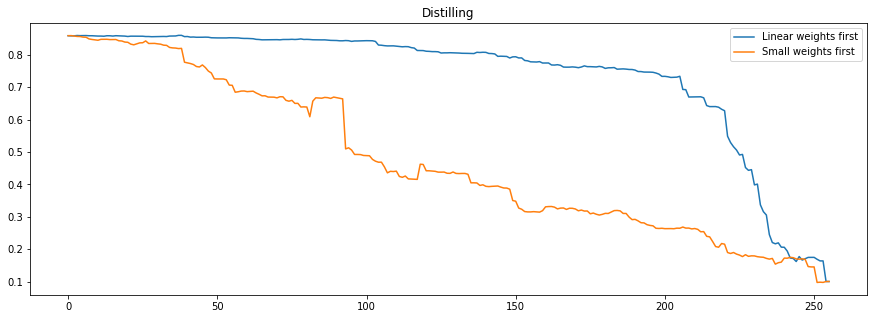

In [0]:
plt.figure(figsize = (15,5))
plt.plot(accs, label = 'Linear weights first')
plt.plot(raccs, label = 'Small weights first')
plt.legend()
plt.title('Distilling')

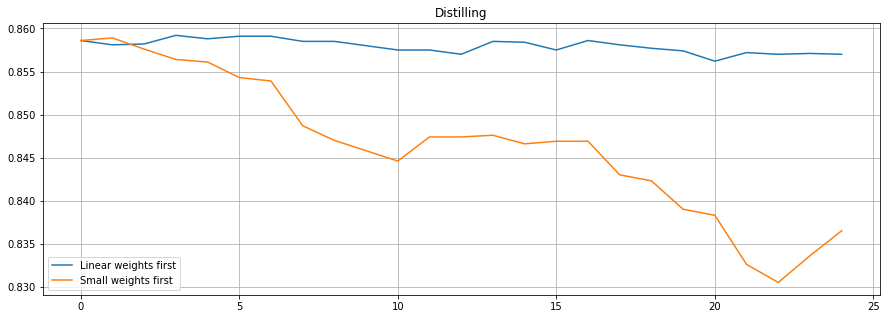

In [0]:
plt.figure(figsize = (15,5))
plt.plot(accs[:25], label = 'Linear weights first')
plt.plot(raccs[:25], label = 'Small weights first')
plt.legend()
plt.title('Distilling')
plt.grid()

In [0]:
s = models['APAF'].get_layer('APAF')
alpha,beta = s.get_weights()
w = {i:(a,b) for i,(a,b) in enumerate(zip(alpha.T,beta.T))}

In [0]:
df = pd.DataFrame(np.r_[alpha,beta]).T
df['Diff'] = df.iloc[:,:3].sum(axis = 1) - df.iloc[:,3:].sum(axis = 1)
df['abs_diff'] = df.Diff.abs()

In [0]:
df

0         1         2  ...         5      Diff  abs_diff
0   -0.026003  0.022900  0.035179  ... -0.044962  0.755322  0.755322
1   -0.047884  0.007298 -0.130795  ... -0.543172  0.678044  0.678044
2    0.169180 -0.189943 -0.095966  ...  0.045921  0.014819  0.014819
3    0.276805  0.198844  0.137456  ... -0.253818  1.188692  1.188692
4   -0.307183 -0.049398 -0.115233  ... -0.270297 -0.055110  0.055110
..        ...       ...       ...  ...       ...       ...       ...
251  0.001476 -0.002798 -0.071136  ... -0.056388  0.573666  0.573666
252 -0.005581 -0.006865  0.055360  ... -0.873089  0.967909  0.967909
253  0.140989 -0.308935 -0.044098  ... -0.151820 -0.173520  0.173520
254  0.206694 -0.304750  0.019298  ...  0.168332 -0.500026  0.500026
255  0.003615  0.003460  0.086739  ...  0.395383 -0.994276  0.994276

[256 rows x 8 columns]

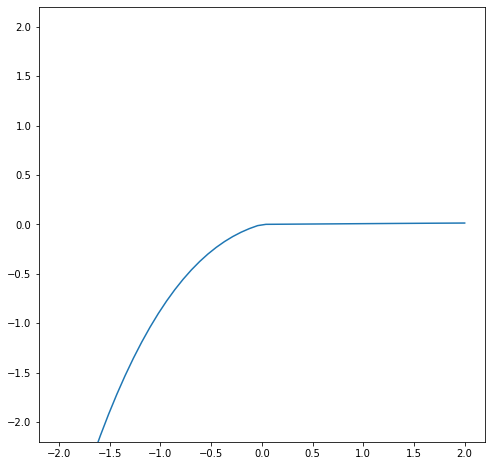

In [0]:
import matplotlib.animation
from IPython.display import HTML

plt.rcParams['animation.embed_limit'] = 500 # animation size limit in megabytes

#extremes = np.array([np.min(x), np.max(x)]) # edge points for line

fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.set_xlim(-2.2,2.2)
ax.set_ylim(-2.2,2.2)
# stable data
alphas, betas = df.sort_values('Diff').values[:,:3], df.sort_values('Diff').values[:,3:6]
inputs = np.linspace(-2,2)

# animated data
line, = ax.plot([],[], '-')

def animate(i): # animation function is called on each frame
    a,b = alphas[i], betas[i]
    pos = tf.keras.backend.relu(inputs)
    pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
    neg = tf.keras.backend.relu(-inputs)
    neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
    output = pos+neg
    line.set_data(inputs,output)


ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(len(alphas)))

HTML(ani.to_jshtml())
#HTML(ani.to_html5_video())

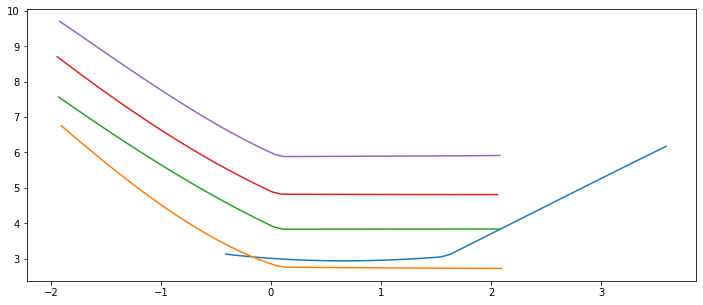

In [0]:
for n,w in enumerate(df.sort_values('Diff').tail().values):
    a,b = w[:3],w[3:]
    inputs = np.linspace(-2,2)
    pos = tf.keras.backend.relu(inputs)
    pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
    neg = tf.keras.backend.relu(-inputs)
    neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
    output = n+pos+neg
    plt.plot(sum(a)+inputs, sum(b)+output, label = n)

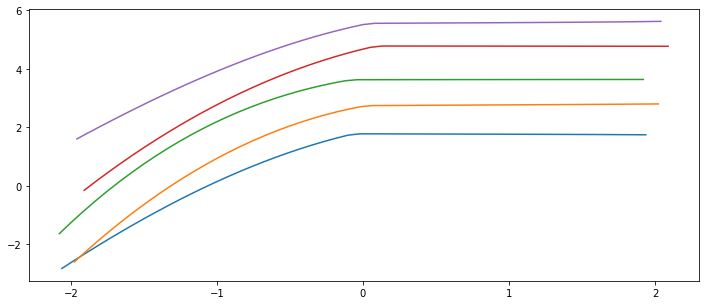

In [0]:
for n,w in enumerate(df.sort_values('Diff').head().values):
    a,b = w[:3],w[3:]
    inputs = np.linspace(-2,2)
    pos = tf.keras.backend.relu(inputs)
    pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
    neg = tf.keras.backend.relu(-inputs)
    neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
    output = n+pos+neg
    plt.plot(sum(a)+inputs, sum(b)+output, label = n)

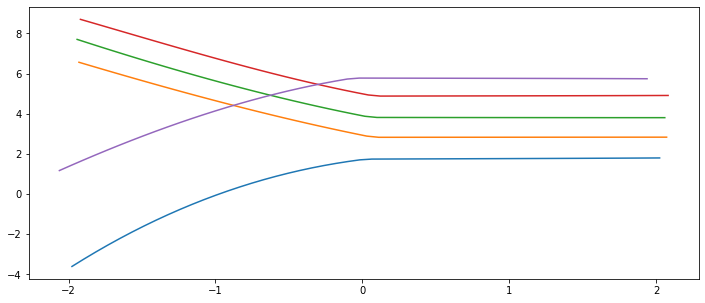

In [0]:
for n,w in enumerate(df.sort_values('abs_diff').tail().values):
    a,b = w[:3],w[3:]
    inputs = np.linspace(-2,2)
    pos = tf.keras.backend.relu(inputs)
    pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
    neg = tf.keras.backend.relu(-inputs)
    neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
    output = n+pos+neg
    plt.plot(sum(a)+inputs, sum(b)+output, label = n)

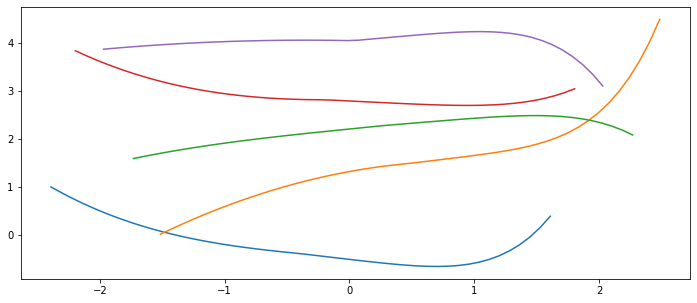

In [0]:
for n,w in enumerate(df.sort_values('abs_diff').head().values):
    a,b = w[:3],w[3:]
    inputs = np.linspace(-2,2)
    pos = tf.keras.backend.relu(inputs)
    pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
    neg = tf.keras.backend.relu(-inputs)
    neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
    output = n+pos+neg
    plt.plot(sum(a)+inputs, sum(b)+output, label = n)

In [0]:
df['sum_a'] = alpha.sum(axis = 0)
df['sum_b'] = beta.sum(axis = 0)
df

0         1         2  ...     sum_a     sum_b   dif_sum
0   -0.026003  0.022900  0.035179  ...  0.032076 -0.723246 -0.639165
1   -0.047884  0.007298 -0.130795  ... -0.171381 -0.849425 -0.712643
2    0.169180 -0.189943 -0.095966  ... -0.116729 -0.131548  0.231698
3    0.276805  0.198844  0.137456  ...  0.613105 -0.575586 -0.016050
4   -0.307183 -0.049398 -0.115233  ... -0.471814 -0.416704  0.055110
..        ...       ...       ...  ...       ...       ...       ...
251  0.001476 -0.002798 -0.071136  ... -0.072459 -0.646125 -0.570714
252 -0.005581 -0.006865  0.055360  ...  0.042914 -0.924995 -0.965616
253  0.140989 -0.308935 -0.044098  ... -0.212043 -0.038523  0.228905
254  0.206694 -0.304750  0.019298  ... -0.078758  0.421268  0.109474
255  0.003615  0.003460  0.086739  ...  0.093814  1.088090 -1.104794

[256 rows x 11 columns]

In [0]:
df['sum'] = df['abs_sum_a'] + df['abs_sum_b']

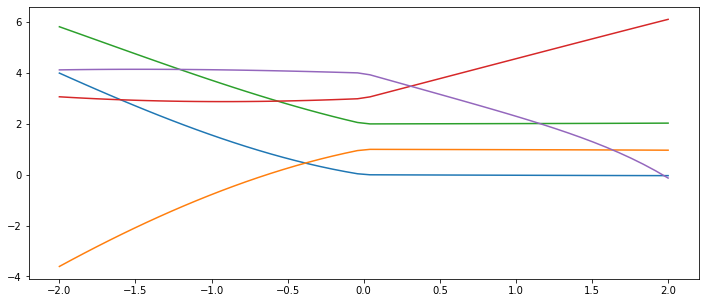

In [0]:
for n,w in enumerate(df.sort_values('sum').tail().values):
    a,b = w[:3],w[3:]
    inputs = np.linspace(-2,2)
    pos = tf.keras.backend.relu(inputs)
    pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
    neg = tf.keras.backend.relu(-inputs)
    neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
    output = n+pos+neg
    plt.plot(inputs, output, label = n)

In [0]:
df['abs_sum_a'] = np.abs(alpha).sum(axis = 0)
df['abs_sum_b'] = np.abs(beta).sum(axis = 0)
df

0         1         2  ...   dif_sum  abs_sum_a  abs_sum_b
0   -0.026003  0.022900  0.035179  ... -0.639165   0.084082   0.723246
1   -0.047884  0.007298 -0.130795  ... -0.712643   0.185978   0.898621
2    0.169180 -0.189943 -0.095966  ...  0.231698   0.455089   0.223391
3    0.276805  0.198844  0.137456  ... -0.016050   0.613105   0.629155
4   -0.307183 -0.049398 -0.115233  ...  0.055110   0.471814   0.416704
..        ...       ...       ...  ...       ...        ...        ...
251  0.001476 -0.002798 -0.071136  ... -0.570714   0.075411   0.646125
252 -0.005581 -0.006865  0.055360  ... -0.965616   0.067807   1.033423
253  0.140989 -0.308935 -0.044098  ...  0.228905   0.494022   0.265117
254  0.206694 -0.304750  0.019298  ...  0.109474   0.530742   0.421268
255  0.003615  0.003460  0.086739  ... -1.104794   0.093814   1.198608

[256 rows x 13 columns]

In [0]:
df['std_a'] = alpha.std(axis = 0)
df['std_b'] = beta.std(axis = 0)
df

0         1         2  ...     sum_b     std_a     std_b
0    0.002149  0.002454  0.066355  ...  0.505126  0.030195  0.065236
1   -0.003759  0.004856  0.023829  ...  0.109340  0.011524  0.124507
2   -0.011756  0.007543  0.062177  ...  0.672774  0.031311  0.294121
3    0.174636  0.224893  0.140473  ... -0.220228  0.034673  0.076381
4    0.113993 -0.095418 -0.146334  ... -0.066915  0.112653  0.102975
..        ...       ...       ...  ...       ...       ...       ...
251  0.001851 -0.001424  0.100586  ... -0.723211  0.047335  0.135760
252  0.001968 -0.005006 -0.129650  ... -0.923602  0.060469  0.360940
253 -0.039315  0.043111  0.019784  ...  0.375585  0.034691  0.166719
254  0.118997 -0.220331 -0.083393  ...  0.191824  0.139386  0.015837
255 -0.113982  0.006921  0.072506  ... -0.083331  0.077242  0.106061

[256 rows x 12 columns]

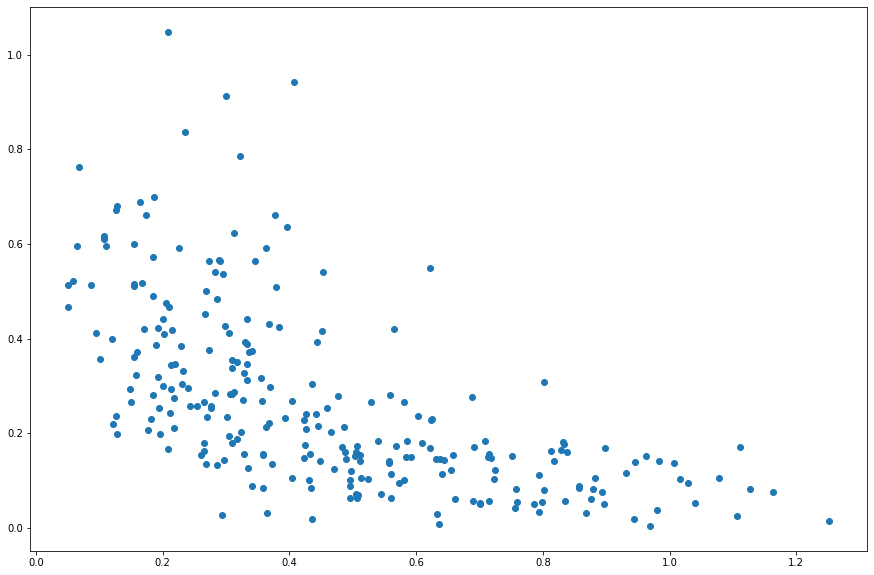

In [0]:
plt.plot(df['abs_sum_b'], df['abs_sum_a'], 'o')

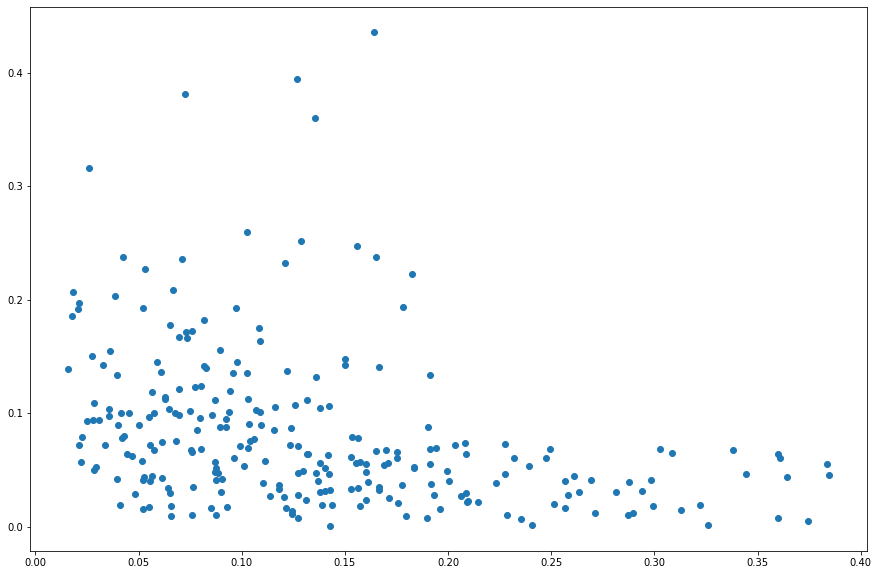

In [0]:
plt.plot(df['std_b'], df['std_a'], 'o')

In [0]:
df['std'] = df['std_a'] + df['std_b']

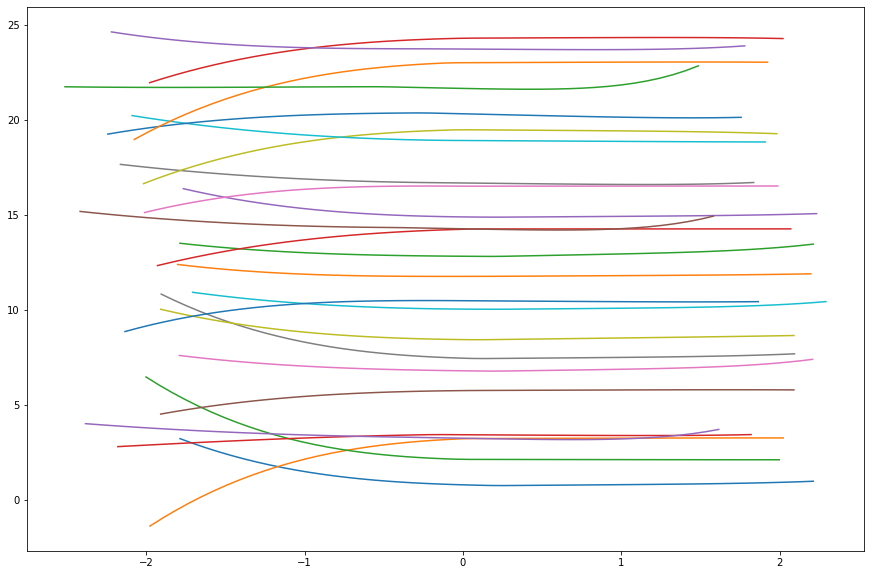

In [0]:
for n,w in enumerate(df.sort_values('std').head(25).values):
    a,b = w[:3],w[3:]
    inputs = np.linspace(-2,2)
    pos = tf.keras.backend.relu(inputs)
    pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
    neg = tf.keras.backend.relu(-inputs)
    neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
    output = n+pos+neg
    plt.plot(sum(a)+inputs, sum(b)+output, label = n)

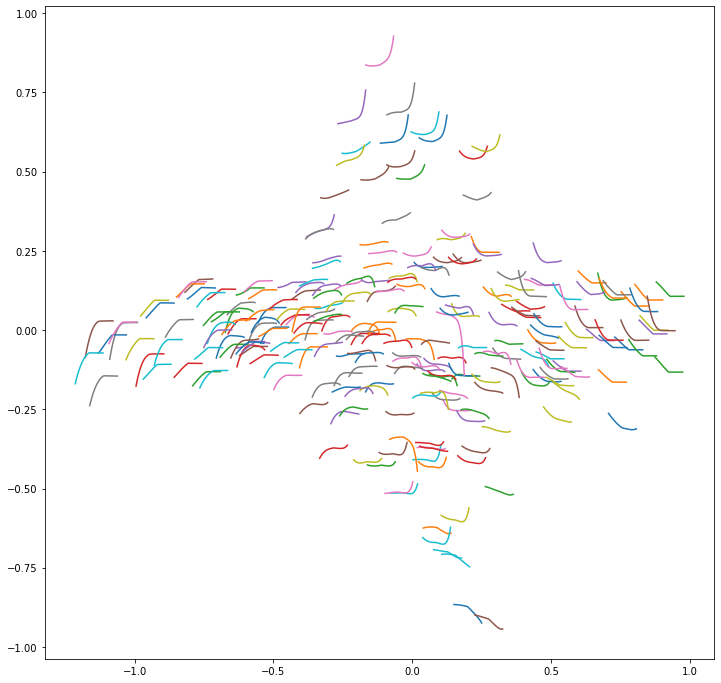

In [0]:
plt.figure(figsize = (12,12))
r = np.array(np.linspace(-1,1))
inputs = np.linspace(-2,2)
scale = 0.025
frame = 1.
for a,b in zip(alpha.T,beta.T):
  pos = tf.keras.backend.relu(inputs)
  pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
  neg = tf.keras.backend.relu(-inputs)
  neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
  output = pos+neg
  plt.plot(-sum(b) + inputs*scale, sum(a) + output*scale,)
#plt.xlim((-frame,frame))
#plt.ylim((-frame,frame))

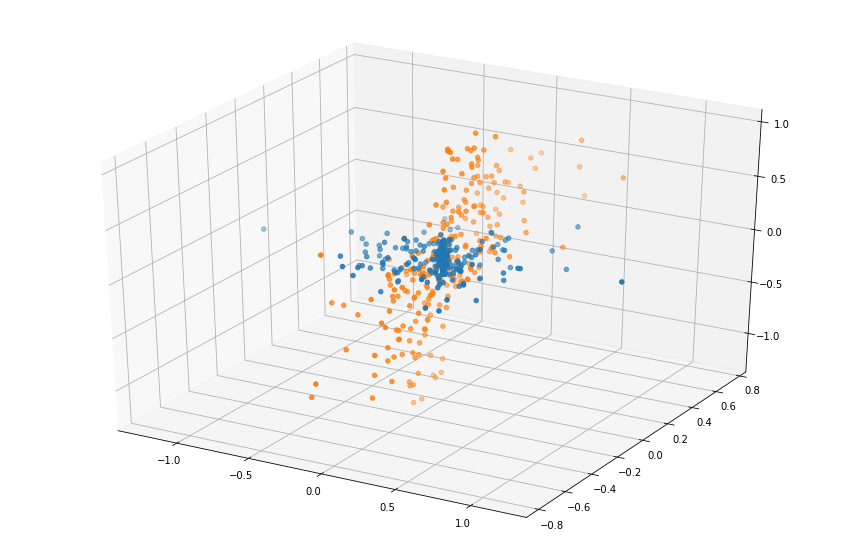

In [0]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(alpha[0], alpha[1], alpha[2]);
ax.scatter3D(beta[0], beta[1], beta[2])

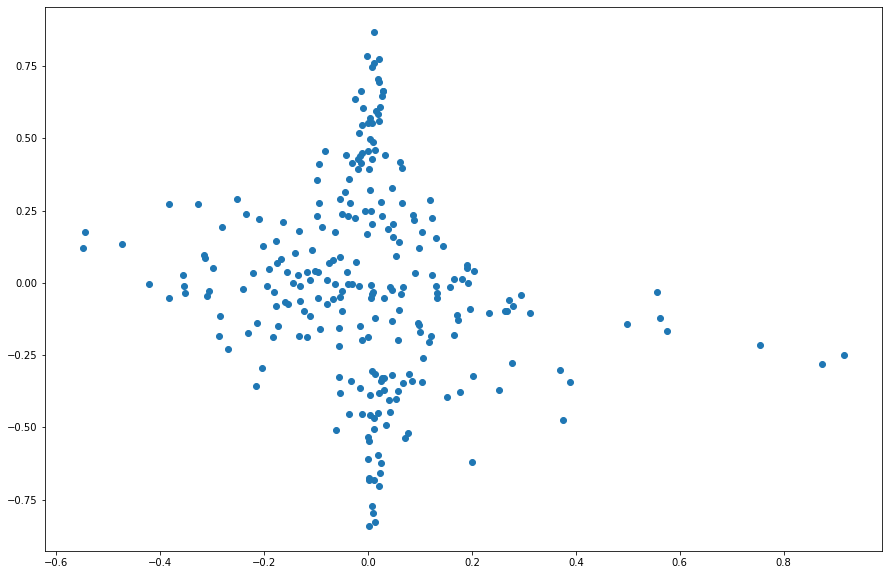

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
A = alpha.T#np.r_[alpha.T,beta.T]
X_a = pca.fit(A).transform(A)
B = beta.T
X_b = pca.fit(B).transform(B)
X_a.T[0]
plt.plot(X_a.T[0],X_b.T[0], 'o')

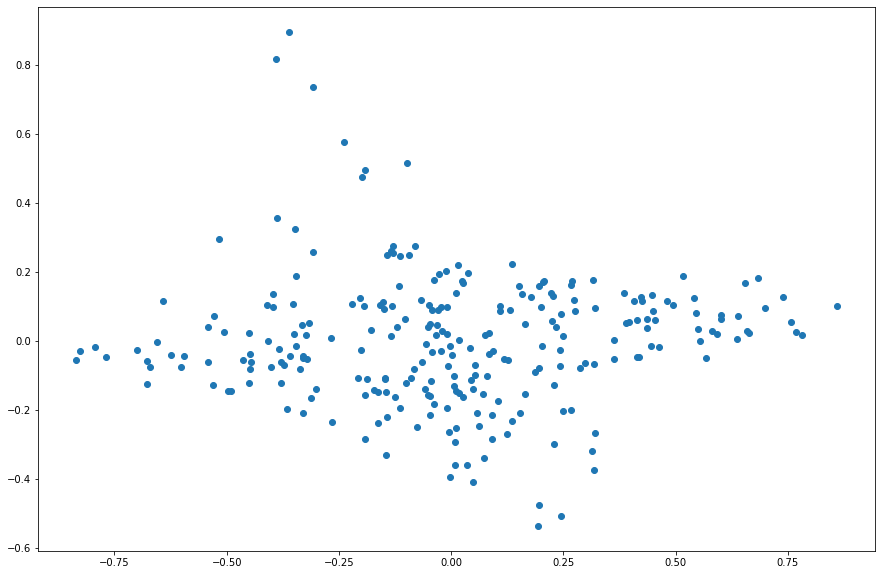

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
A = np.c_[alpha.T,beta.T]
X_a = pca.fit(A).transform(A)
B = beta.T
#X_b = pca.fit(B).transform(B)
X_a.T[0]
plt.plot(X_a.T[0],X_a.T[1], 'o')

In [0]:
len(X_a)

256

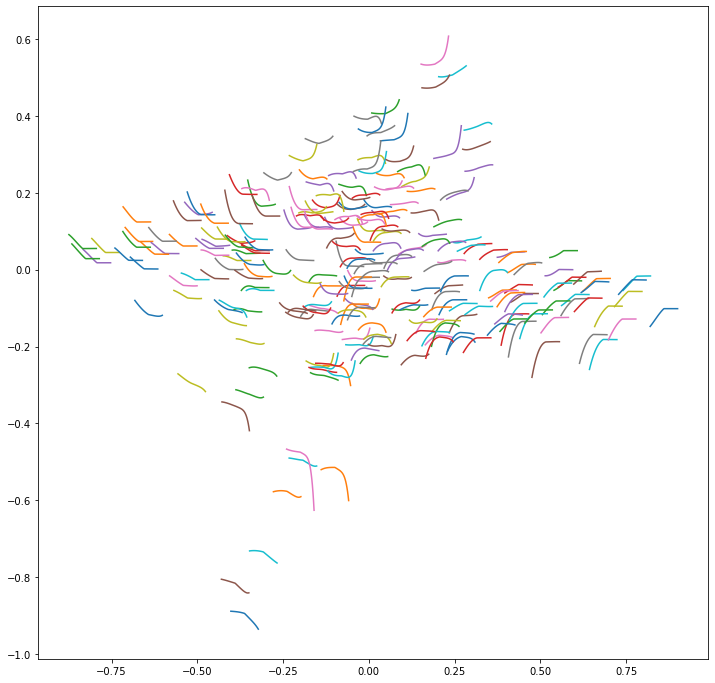

In [0]:
plt.figure(figsize = (12,12))
r = np.array(np.linspace(-1,1))
inputs = np.linspace(-2,2)
scale = 0.02
frame = 1.
for n,(a,b) in enumerate(zip(alpha.T,beta.T)):
  pos = tf.keras.backend.relu(inputs)
  pos = a[0] * tf.pow(pos,3) * a[1] * tf.pow(pos,2) + a[0] * pos
  neg = tf.keras.backend.relu(-inputs)
  neg = -b[0] * tf.pow(neg,3) -b[1] * tf.pow(neg,2) -b[2] * neg
  output = pos+neg
  plt.plot(X_a.T[0][n] + inputs*scale, -X_a.T[1][n] + output*scale,)
  #plt.plot(X_a.T[0][n], X_a.T[1][n], 'o')
#plt.xlim((-frame,frame))
#plt.ylim((-frame,frame))

# Statistics

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once in a notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'results.txt'})
uploaded2 = drive.CreateFile({'title': 'hist.txt'})


In [0]:
iters = 10
models = {}
val = {}
hst = {}

In [0]:
%%time


for i in range(iters):
  for layer in layers:
      print('Training', layer, i)
      hst[layer+'_'+str(i)],models[layer+'_'+str(i)] = show_model(layer, neurons, epochs, silent = True)
      loss, acc = models[layer+'_'+str(i)].evaluate(x_test,  y_test, verbose=2)
      val[layer+'_'+str(i)] = {'Loss':loss,'Accuracy':acc}

      uploaded.SetContentString(str(val))
      uploaded.Upload()
      uploaded2.SetContentString(str(hst))
      uploaded2.Upload()
      print('Uploaded file with ID {}'.format(uploaded.get('id')))


Training Sigmoid 0
Train on 45000 samples, validate on 15000 samples
Epoch 1/25
45000/45000 [==============================] - 6s 143us/sample - loss: 0.5734 - accuracy: 0.7985 - val_loss: 0.4106 - val_accuracy: 0.8538
Epoch 2/25
45000/45000 [==============================] - 6s 130us/sample - loss: 0.4357 - accuracy: 0.8440 - val_loss: 0.3750 - val_accuracy: 0.8683
Epoch 3/25
45000/45000 [==============================] - 6s 130us/sample - loss: 0.3918 - accuracy: 0.8592 - val_loss: 0.3611 - val_accuracy: 0.8695
Epoch 4/25
45000/45000 [==============================] - 6s 132us/sample - loss: 0.3639 - accuracy: 0.8680 - val_loss: 0.3537 - val_accuracy: 0.8697
Epoch 5/25
45000/45000 [==============================] - 6s 130us/sample - loss: 0.3426 - accuracy: 0.8740 - val_loss: 0.3743 - val_accuracy: 0.8643
Epoch 6/25
45000/45000 [==============================] - 6s 130us/sample - loss: 0.3238 - accuracy: 0.8807 - val_loss: 0.3367 - val_accuracy: 0.8794
Epoch 7/25
45000/45000 [=======

InvalidConfigError: ignored

In [0]:
res0 = {'Sigmoid_0': {'Loss': 0.3642904808998108, 'Accuracy': 0.881}, 'ReLU_0': {'Loss': 0.36863128657341004, 'Accuracy': 0.8728}, 'SeLU_0': {'Loss': 0.3480145269393921, 'Accuracy': 0.876}, 'PReLU_0': {'Loss': 0.3600677489280701, 'Accuracy': 0.8735}, 'LeakyReLU_0': {'Loss': 0.41205959355831145, 'Accuracy': 0.8532}, 'ELU_0': {'Loss': 0.32911930899620057, 'Accuracy': 0.8839}, 'Clockface_0': {'Loss': 0.3716790521383285, 'Accuracy': 0.8627}, 'APAF_0': {'Loss': 0.4122799224615097, 'Accuracy': 0.8638}, 'Sigmoid_1': {'Loss': 0.3707524879336357, 'Accuracy': 0.8736}, 'ReLU_1': {'Loss': 0.38624868785142896, 'Accuracy': 0.8588}, 'SeLU_1': {'Loss': 0.3514028925180435, 'Accuracy': 0.8745}, 'PReLU_1': {'Loss': 0.3665493558526039, 'Accuracy': 0.8721}, 'LeakyReLU_1': {'Loss': 0.37057245995998384, 'Accuracy': 0.8703}, 'ELU_1': {'Loss': 0.35641527087688446, 'Accuracy': 0.8735}, 'Clockface_1': {'Loss': 0.3679324366688728, 'Accuracy': 0.8739}, 'APAF_1': {'Loss': 0.42855121735334395, 'Accuracy': 0.8485}, 'Sigmoid_2': {'Loss': 0.3652904672861099, 'Accuracy': 0.8757}, 'ReLU_2': {'Loss': 0.3773249566674233, 'Accuracy': 0.8652}, 'SeLU_2': {'Loss': 0.37139298243522645, 'Accuracy': 0.8653}, 'PReLU_2': {'Loss': 0.34982942588329313, 'Accuracy': 0.8812}, 'LeakyReLU_2': {'Loss': 0.3858517935156822, 'Accuracy': 0.8648}, 'ELU_2': {'Loss': 0.3522066511631012, 'Accuracy': 0.875}, 'Clockface_2': {'Loss': 0.34537809616327286, 'Accuracy': 0.8838}, 'APAF_2': {'Loss': 0.3905251499295235, 'Accuracy': 0.8687}, 'Sigmoid_3': {'Loss': 0.3528563962340355, 'Accuracy': 0.8788}, 'ReLU_3': {'Loss': 0.4223729721069336, 'Accuracy': 0.8561}, 'SeLU_3': {'Loss': 0.34828774776458743, 'Accuracy': 0.8786}, 'PReLU_3': {'Loss': 0.3553702761173248, 'Accuracy': 0.875}, 'LeakyReLU_3': {'Loss': 0.4101711053431034, 'Accuracy': 0.8599}, 'ELU_3': {'Loss': 0.3499256583929062, 'Accuracy': 0.8746}, 'Clockface_3': {'Loss': 0.37035477012395857, 'Accuracy': 0.8714}, 'APAF_3': {'Loss': 0.4093088814496994, 'Accuracy': 0.8657}, 'Sigmoid_4': {'Loss': 0.360031617641449, 'Accuracy': 0.8716}}
res1 = {'Sigmoid_0': {'Loss': 0.3642904808998108, 'Accuracy': 0.881}, 'ReLU_0': {'Loss': 0.36863128657341004, 'Accuracy': 0.8728}, 'SeLU_0': {'Loss': 0.3480145269393921, 'Accuracy': 0.876}, 'PReLU_0': {'Loss': 0.3600677489280701, 'Accuracy': 0.8735}, 'LeakyReLU_0': {'Loss': 0.41205959355831145, 'Accuracy': 0.8532}, 'ELU_0': {'Loss': 0.32911930899620057, 'Accuracy': 0.8839}, 'Clockface_0': {'Loss': 0.3716790521383285, 'Accuracy': 0.8627}, 'APAF_0': {'Loss': 0.4122799224615097, 'Accuracy': 0.8638}, 'Sigmoid_1': {'Loss': 0.3707524879336357, 'Accuracy': 0.8736}, 'ReLU_1': {'Loss': 0.38624868785142896, 'Accuracy': 0.8588}, 'SeLU_1': {'Loss': 0.3514028925180435, 'Accuracy': 0.8745}, 'PReLU_1': {'Loss': 0.3665493558526039, 'Accuracy': 0.8721}, 'LeakyReLU_1': {'Loss': 0.37057245995998384, 'Accuracy': 0.8703}, 'ELU_1': {'Loss': 0.35641527087688446, 'Accuracy': 0.8735}, 'Clockface_1': {'Loss': 0.3679324366688728, 'Accuracy': 0.8739}, 'APAF_1': {'Loss': 0.42855121735334395, 'Accuracy': 0.8485}, 'Sigmoid_2': {'Loss': 0.3652904672861099, 'Accuracy': 0.8757}, 'ReLU_2': {'Loss': 0.3773249566674233, 'Accuracy': 0.8652}, 'SeLU_2': {'Loss': 0.37139298243522645, 'Accuracy': 0.8653}, 'PReLU_2': {'Loss': 0.34982942588329313, 'Accuracy': 0.8812}, 'LeakyReLU_2': {'Loss': 0.3858517935156822, 'Accuracy': 0.8648}, 'ELU_2': {'Loss': 0.3522066511631012, 'Accuracy': 0.875}, 'Clockface_2': {'Loss': 0.34537809616327286, 'Accuracy': 0.8838}, 'APAF_2': {'Loss': 0.3905251499295235, 'Accuracy': 0.8687}, 'Sigmoid_3': {'Loss': 0.3528563962340355, 'Accuracy': 0.8788}, 'ReLU_3': {'Loss': 0.4223729721069336, 'Accuracy': 0.8561}, 'SeLU_3': {'Loss': 0.34828774776458743, 'Accuracy': 0.8786}, 'PReLU_3': {'Loss': 0.3553702761173248, 'Accuracy': 0.875}, 'LeakyReLU_3': {'Loss': 0.4101711053431034, 'Accuracy': 0.8599}, 'ELU_3': {'Loss': 0.3499256583929062, 'Accuracy': 0.8746}, 'Clockface_3': {'Loss': 0.37035477012395857, 'Accuracy': 0.8714}, 'APAF_3': {'Loss': 0.4093088814496994, 'Accuracy': 0.8657}, 'Sigmoid_4': {'Loss': 0.35400639950037005, 'Accuracy': 0.8814}, 'ReLU_4': {'Loss': 0.372047992181778, 'Accuracy': 0.8709}, 'SeLU_4': {'Loss': 0.3504220574259758, 'Accuracy': 0.8742}, 'PReLU_4': {'Loss': 0.35133443986177443, 'Accuracy': 0.8733}, 'LeakyReLU_4': {'Loss': 0.3862467281222343, 'Accuracy': 0.8646}, 'ELU_4': {'Loss': 0.3506000970721245, 'Accuracy': 0.8769}, 'Clockface_4': {'Loss': 0.38738375824689864, 'Accuracy': 0.8687}, 'APAF_4': {'Loss': 0.36794392910003665, 'Accuracy': 0.8757}, 'Sigmoid_5': {'Loss': 0.4052991961956024, 'Accuracy': 0.8576}, 'ReLU_5': {'Loss': 0.3777250853538513, 'Accuracy': 0.8688}, 'SeLU_5': {'Loss': 0.36442772505283355, 'Accuracy': 0.8737}, 'PReLU_5': {'Loss': 0.3748767973780632, 'Accuracy': 0.8665}, 'LeakyReLU_5': {'Loss': 0.399158245074749, 'Accuracy': 0.8618}, 'ELU_5': {'Loss': 0.36641828813552857, 'Accuracy': 0.8701}, 'Clockface_5': {'Loss': 0.3661846438527107, 'Accuracy': 0.8707}, 'APAF_5': {'Loss': 0.47293635880947116, 'Accuracy': 0.837}, 'Sigmoid_6': {'Loss': 0.35067619251906873, 'Accuracy': 0.881}, 'ReLU_6': {'Loss': 0.37431898066997527, 'Accuracy': 0.8652}, 'SeLU_6': {'Loss': 0.3611201092481613, 'Accuracy': 0.8709}, 'PReLU_6': {'Loss': 0.34878171753883364, 'Accuracy': 0.8757}, 'LeakyReLU_6': {'Loss': 0.44692504959106444, 'Accuracy': 0.851}, 'ELU_6': {'Loss': 0.35279950361251833, 'Accuracy': 0.8792}, 'Clockface_6': {'Loss': 0.3643748369693756, 'Accuracy': 0.871}, 'APAF_6': {'Loss': 0.3998277559757233, 'Accuracy': 0.866}, 'Sigmoid_7': {'Loss': 0.3649483687490225, 'Accuracy': 0.8734}, 'ReLU_7': {'Loss': 0.37336740708351135, 'Accuracy': 0.8679}, 'SeLU_7': {'Loss': 0.3910436544060707, 'Accuracy': 0.8564}, 'PReLU_7': {'Loss': 0.36129375454187396, 'Accuracy': 0.8724}, 'LeakyReLU_7': {'Loss': 0.42385281553268433, 'Accuracy': 0.8475}, 'ELU_7': {'Loss': 0.3566896535515785, 'Accuracy': 0.8728}, 'Clockface_7': {'Loss': 0.35138558101654055, 'Accuracy': 0.8755}, 'APAF_7': {'Loss': 0.45592350101470946, 'Accuracy': 0.8497}, 'Sigmoid_8': {'Loss': 0.3501073557853699, 'Accuracy': 0.8767}, 'ReLU_8': {'Loss': 0.4165130099534988, 'Accuracy': 0.8514}, 'SeLU_8': {'Loss': 0.4196048968315125, 'Accuracy': 0.8524}, 'PReLU_8': {'Loss': 0.3539978715896606, 'Accuracy': 0.879}, 'LeakyReLU_8': {'Loss': 0.3802111573934555, 'Accuracy': 0.8633}, 'ELU_8': {'Loss': 0.3460918387413025, 'Accuracy': 0.8763}, 'Clockface_8': {'Loss': 0.3747310106396675, 'Accuracy': 0.8695}, 'APAF_8': {'Loss': 0.46554086487293245, 'Accuracy': 0.8431}, 'Sigmoid_9': {'Loss': 0.37192202625274656, 'Accuracy': 0.879}}
res2 = {'Sigmoid_0': {'Loss': 0.35884575645923616, 'Accuracy': 0.8756}, 'ReLU_0': {'Loss': 0.3594041004896164, 'Accuracy': 0.8763}, 'SeLU_0': {'Loss': 0.3422973545432091, 'Accuracy': 0.8814}, 'PReLU_0': {'Loss': 0.36718967516422274, 'Accuracy': 0.8681}, 'LeakyReLU_0': {'Loss': 0.41455166263580323, 'Accuracy': 0.8528}, 'ELU_0': {'Loss': 0.3520884428501129, 'Accuracy': 0.8766}, 'Clockface_0': {'Loss': 0.36283479999899865, 'Accuracy': 0.8736}, 'APAF_0': {'Loss': 0.4850266725540161, 'Accuracy': 0.8467}, 'Sigmoid_1': {'Loss': 0.3595511247038841, 'Accuracy': 0.8838}, 'ReLU_1': {'Loss': 0.3646477872133255, 'Accuracy': 0.8695}, 'SeLU_1': {'Loss': 0.35186332284212113, 'Accuracy': 0.8776}, 'PReLU_1': {'Loss': 0.3621691171169281, 'Accuracy': 0.8675}, 'LeakyReLU_1': {'Loss': 0.40344772956371305, 'Accuracy': 0.8602}, 'ELU_1': {'Loss': 0.33517440959215167, 'Accuracy': 0.8839}, 'Clockface_1': {'Loss': 0.37375526378154755, 'Accuracy': 0.8699}, 'APAF_1': {'Loss': 0.4141843938231468, 'Accuracy': 0.8551}, 'Sigmoid_2': {'Loss': 0.3982875220537186, 'Accuracy': 0.872}, 'ReLU_2': {'Loss': 0.3860942560315132, 'Accuracy': 0.866}, 'SeLU_2': {'Loss': 0.3474214912652969, 'Accuracy': 0.8769}, 'PReLU_2': {'Loss': 0.359376491189003, 'Accuracy': 0.8745}, 'LeakyReLU_2': {'Loss': 0.4036549814939499, 'Accuracy': 0.8542}, 'ELU_2': {'Loss': 0.35721484112739565, 'Accuracy': 0.8759}, 'Clockface_2': {'Loss': 0.35877061487436296, 'Accuracy': 0.8768}, 'APAF_2': {'Loss': 0.6030342197179794, 'Accuracy': 0.8175}, 'Sigmoid_3': {'Loss': 0.3439260871112347, 'Accuracy': 0.8791}, 'ReLU_3': {'Loss': 0.3980943001270294, 'Accuracy': 0.8559}, 'SeLU_3': {'Loss': 0.4002699495315552, 'Accuracy': 0.8557}, 'PReLU_3': {'Loss': 0.3725064050078392, 'Accuracy': 0.8661}, 'LeakyReLU_3': {'Loss': 0.4118804486274719, 'Accuracy': 0.8583}, 'ELU_3': {'Loss': 0.3598259201169014, 'Accuracy': 0.8728}, 'Clockface_3': {'Loss': 0.3497150153875351, 'Accuracy': 0.8782}, 'APAF_3': {'Loss': 0.42836755833625795, 'Accuracy': 0.8565}, 'Sigmoid_4': {'Loss': 0.3591002271294594, 'Accuracy': 0.8817}, 'ReLU_4': {'Loss': 0.3789804564714432, 'Accuracy': 0.8631}, 'SeLU_4': {'Loss': 0.35306983724832536, 'Accuracy': 0.8745}, 'PReLU_4': {'Loss': 0.340790608048439, 'Accuracy': 0.8804}, 'LeakyReLU_4': {'Loss': 0.3734611996173859, 'Accuracy': 0.8689}, 'ELU_4': {'Loss': 0.3655343398809433, 'Accuracy': 0.8706}}

In [0]:
res1 = {k+'1':v for k,v in res1.items()}
res2 = {k+'2':v for k,v in res2.items()}

In [0]:
res0.update(res1)
res0.update(res2)
len(res0)

144

In [0]:
pd.DataFrame(res0).T

Loss  Accuracy
Sigmoid_0     0.364290    0.8810
ReLU_0        0.368631    0.8728
SeLU_0        0.348015    0.8760
PReLU_0       0.360068    0.8735
LeakyReLU_0   0.412060    0.8532
...                ...       ...
ReLU_42       0.378980    0.8631
SeLU_42       0.353070    0.8745
PReLU_42      0.340791    0.8804
LeakyReLU_42  0.373461    0.8689
ELU_42        0.365534    0.8706

[144 rows x 2 columns]

In [0]:
res = pd.DataFrame(res0).T
res['Function'] = [i.split('_')[0] for i in res.index]
res

Loss  Accuracy   Function
Sigmoid_0     0.364290    0.8810    Sigmoid
ReLU_0        0.368631    0.8728       ReLU
SeLU_0        0.348015    0.8760       SeLU
PReLU_0       0.360068    0.8735      PReLU
LeakyReLU_0   0.412060    0.8532  LeakyReLU
...                ...       ...        ...
ReLU_42       0.378980    0.8631       ReLU
SeLU_42       0.353070    0.8745       SeLU
PReLU_42      0.340791    0.8804      PReLU
LeakyReLU_42  0.373461    0.8689  LeakyReLU
ELU_42        0.365534    0.8706        ELU

[144 rows x 3 columns]

Text(0.5, 1.0, 'Accuracy')

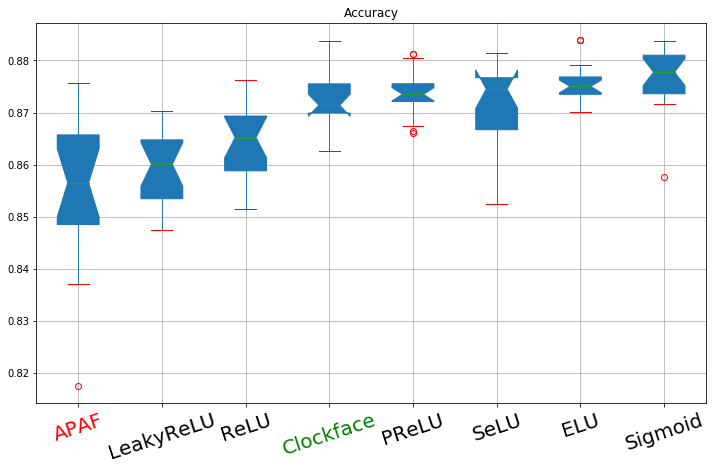

In [0]:
plt.figure(figsize=(12,7))
boxplot_sorted(res, by='Function', column="Accuracy")
ax = plt.gcf().gca()
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(20)
                tick.label.set_rotation(18)
                if tick.label.get_text() == 'Clockface':
                  tick.label.set_color('g')
                if tick.label.get_text() == 'APAF':
                  tick.label.set_color('r')

plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

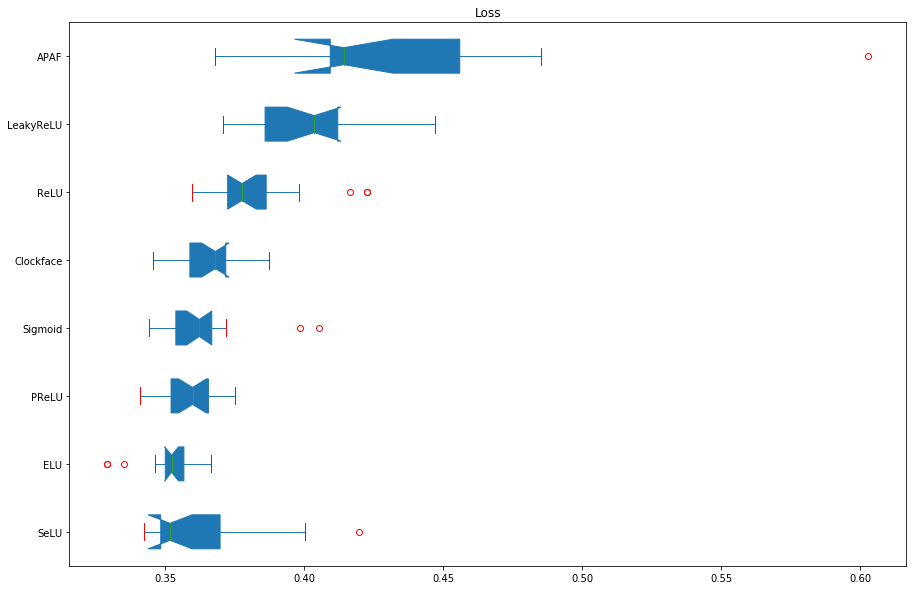

In [0]:
boxplot_sorted(res, by='Function', column="Loss")
plt.title('Loss')

In [0]:
res.groupby('Function').agg('mean').sort_values('Loss').style.bar()

In [0]:
h = {'Sigmoid_0': {'loss': [0.573427079349094, 0.4356739249335395, 0.3917679341369205, 0.3639043213473426, 0.3425815829171075, 0.3238198909044266, 0.310707014547454, 0.3013734423584408, 0.29169735680156283, 0.2798145128356086, 0.27431824344396594, 0.2646100598971049], 'accuracy': [0.7985111, 0.84404445, 0.85917777, 0.8680222, 0.8739778, 0.8806667, 0.88582224, 0.8899556, 0.8905333, 0.896, 0.89757776, 0.9022222], 'val_loss': [0.4106038152694702, 0.37501961057980854, 0.3611169308185577, 0.3537426994562149, 0.37434584357738493, 0.33671218780676526, 0.3276693581501643, 0.3394503846128782, 0.32297131509780885, 0.3332068944533666, 0.3375895434220632, 0.3276068084637324], 'val_accuracy': [0.8538, 0.86833334, 0.86953336, 0.86973333, 0.86433333, 0.8794, 0.8834, 0.87693334, 0.88746667, 0.88026667, 0.8829333, 0.8839333], 'time': [6.428838491439819, 5.849768877029419, 5.85018515586853, 5.918397665023804, 5.844411611557007, 5.865143537521362, 5.946514844894409, 5.7789466381073, 6.047347068786621, 6.243641376495361, 6.089356184005737, 5.795413255691528]}, 'ReLU_0': {'loss': [0.5445717262268066, 0.4526477355745104, 0.4306011166996426, 0.4107755915111966, 0.3979891024324629, 0.3808536227093803, 0.3733078621705373, 0.3672688281536102, 0.3617939349704319, 0.3522398501555125, 0.3453091260963016, 0.3369981584284041, 0.3352847458018197, 0.33079306870036657, 0.32775814813507925, 0.32861246230867175, 0.3230651127020518], 'accuracy': [0.8087111, 0.84004444, 0.84551114, 0.84995556, 0.8570222, 0.8622222, 0.86428887, 0.86722225, 0.8683778, 0.86984444, 0.8736, 0.87542224, 0.8766889, 0.87835556, 0.8806, 0.8780889, 0.88097775], 'val_loss': [0.42838205925623574, 0.425368861468633, 0.40161273849805196, 0.38357544163068136, 0.37939376777013145, 0.39845768593152364, 0.3774939228216807, 0.3843494809468587, 0.37140213423569995, 0.3508170245409012, 0.3514140471458435, 0.3416194079875946, 0.3373034135818481, 0.3347350621461868, 0.350799702501297, 0.34380564347108206, 0.33765725627740223], 'val_accuracy': [0.84926665, 0.8395333, 0.85566664, 0.86226666, 0.8599333, 0.85613334, 0.86326665, 0.8628, 0.86373335, 0.8724667, 0.8706, 0.8754, 0.8784, 0.882, 0.87266666, 0.87726665, 0.8796], 'time': [6.360064744949341, 5.765362739562988, 5.787959575653076, 5.8301613330841064, 5.768285274505615, 5.747969388961792, 5.727601766586304, 5.8089635372161865, 5.846709251403809, 5.773140907287598, 5.8159003257751465, 5.787487983703613, 5.836548328399658, 5.767350673675537, 5.655289888381958, 5.816903829574585, 5.7842957973480225]}, 'SeLU_0': {'loss': [0.5696106472916074, 0.45651852979660035, 0.4233308865096834, 0.39653228058285184, 0.38159959439171687, 0.3661298967056804, 0.3559906263576614, 0.34516010324160257, 0.3318687565167745, 0.32308998800383676, 0.31667501729196973, 0.31235518138143753, 0.30121328002611797, 0.298689098988639, 0.289177396384875, 0.2863445711745156, 0.28221660566594864, 0.27668087547885045, 0.27199020066791113, 0.26609041038354236, 0.2659623385085, 0.25841425165600246, 0.25716749437650044, 0.2539681959629059], 'accuracy': [0.8016, 0.83795553, 0.84884447, 0.85584444, 0.8598667, 0.86644447, 0.869, 0.8746, 0.8774, 0.8828667, 0.8833778, 0.8856889, 0.8881111, 0.8892, 0.89275557, 0.8936222, 0.89497775, 0.8964, 0.8996, 0.9003111, 0.8994, 0.9031778, 0.90335554, 0.90702224], 'val_loss': [0.4374173025449117, 0.4237774195035299, 0.3968343618233999, 0.3960619430144628, 0.3659597840150197, 0.3683094388802846, 0.34844187463919324, 0.3366007220427195, 0.3359618364016215, 0.3517194927453995, 0.34330938816070555, 0.33341528006394705, 0.34453209467728935, 0.3236081754763921, 0.32772234375079473, 0.3243491663416227, 0.3175796457330386, 0.3139454738815626, 0.3181261736551921, 0.3185733163555463, 0.3128909376422564, 0.3201873117605845, 0.3163855949759483, 0.3174127281745275], 'val_accuracy': [0.8436, 0.84526664, 0.85933334, 0.85606664, 0.86766666, 0.86686665, 0.8765333, 0.8762, 0.87666667, 0.8753333, 0.8729333, 0.878, 0.8739333, 0.8839333, 0.8825333, 0.8792, 0.88806665, 0.8864, 0.8869333, 0.88673335, 0.88773334, 0.88773334, 0.8872, 0.8888], 'time': [6.602283000946045, 6.036253929138184, 5.916136264801025, 5.9084999561309814, 5.759555101394653, 5.9244465827941895, 5.895631551742554, 5.756240606307983, 5.899941921234131, 5.870378255844116, 5.777734041213989, 5.770479917526245, 5.822125673294067, 5.822179794311523, 5.918062210083008, 5.810171604156494, 5.747325897216797, 5.789042234420776, 5.766741991043091, 5.786832809448242, 5.792423248291016, 5.8093202114105225, 5.686978816986084, 5.7555928230285645]}, 'PReLU_0': {'loss': [0.5491838191456265, 0.45378827566040886, 0.41860836799409656, 0.39338539267116124, 0.3831704716682434, 0.3648641918288337, 0.3517947436200248, 0.34611298179096645, 0.33466994054582383, 0.32776546207004126, 0.3158849345551597, 0.31557418449852204, 0.30672944934368135, 0.30356652275191415, 0.2982466266738044, 0.2929116052945455, 0.2901937325146463, 0.28370221095085146], 'accuracy': [0.8066667, 0.8372222, 0.85035557, 0.8584, 0.86075556, 0.8674222, 0.8711778, 0.87315553, 0.8761111, 0.87924445, 0.8836222, 0.88317776, 0.8862889, 0.88728887, 0.8901778, 0.89224446, 0.89122224, 0.89522225], 'val_loss': [0.4655472072760264, 0.4068210999965668, 0.3790665489196777, 0.41767094480196637, 0.35491232795715333, 0.36851840761502586, 0.3775303943634033, 0.35413206130663555, 0.3355166923999786, 0.33438271453380586, 0.33442998365561166, 0.3319328408916791, 0.3267816626469294, 0.33383310985565184, 0.31480105288028715, 0.3200850337465604, 0.32341327568292616, 0.33198052029212316], 'val_accuracy': [0.83426666, 0.84973335, 0.8634, 0.8414, 0.8706, 0.86553335, 0.85933334, 0.8696667, 0.87953335, 0.88026667, 0.88026667, 0.8816, 0.8797333, 0.8814667, 0.887, 0.8858, 0.88626665, 0.8808], 'time': [6.56306004524231, 5.790040493011475, 5.982330560684204, 5.95027232170105, 5.894625663757324, 5.753154993057251, 5.947466611862183, 6.140075206756592, 6.018264293670654, 5.950970411300659, 5.846053838729858, 5.868534803390503, 5.8799450397491455, 5.799644947052002, 5.92376184463501, 5.808250665664673, 5.91845703125, 5.861713171005249]}, 'LeakyReLU_0': {'loss': [0.5721976472112867, 0.46907233680089316, 0.4382528950161404, 0.41768766952488157, 0.40467395703527664, 0.38834207853741115, 0.3809810216320886], 'accuracy': [0.80104446, 0.83404446, 0.8446222, 0.85044444, 0.85455555, 0.8600889, 0.86271113], 'val_loss': [0.5093690664609273, 0.4396857062021891, 0.43009626860618594, 0.38470974488258364, 0.3920035436630249, 0.3958254277070363, 0.38724676087697346], 'val_accuracy': [0.81633335, 0.84426665, 0.8476, 0.86333334, 0.8620667, 0.85686666, 0.86186665], 'time': [6.183971881866455, 5.606590509414673, 5.537324666976929, 5.619197845458984, 5.544384241104126, 5.547811031341553, 5.517892122268677]}, 'ELU_0': {'loss': [0.5577100266748004, 0.44492023141913944, 0.40597472332318624, 0.3817499694241418, 0.36258922644191316, 0.35142305183940464, 0.33252561286820304, 0.32637122435569765, 0.31368589095009697, 0.3072264934142431, 0.29710683908462526, 0.2918573059744305, 0.28468579556412166, 0.2750000053246816], 'accuracy': [0.8052667, 0.84246665, 0.8526, 0.8605555, 0.8683778, 0.8718, 0.8778667, 0.8803333, 0.8850667, 0.88662225, 0.88935554, 0.89064443, 0.89244443, 0.8988444], 'val_loss': [0.4352570303281148, 0.402238379685084, 0.37738107221921285, 0.3993747838417689, 0.35703470738728843, 0.36525753347873685, 0.3364699665705363, 0.33828051797946296, 0.3326581998507182, 0.33155606876214344, 0.3189412294626236, 0.3298857895930608, 0.3201371413429578, 0.3258775638182958], 'val_accuracy': [0.8448667, 0.8548667, 0.8618, 0.8544, 0.87313336, 0.86466664, 0.8803333, 0.8768, 0.8782, 0.88233334, 0.8838, 0.88, 0.885, 0.88306665], 'time': [6.065163850784302, 5.521508455276489, 5.5890867710113525, 5.52818489074707, 5.609947204589844, 5.536732196807861, 5.508326053619385, 5.499534368515015, 5.439311742782593, 5.486739635467529, 5.47013783454895, 5.50772762298584, 5.479509592056274, 5.502133131027222]}, 'Clockface_0': {'loss': [0.5454796490351359, 0.4331943824609121, 0.4030521525462468, 0.3796989346822103, 0.36384186356332565, 0.3518401951127582, 0.33972142991224924, 0.33439417225784723, 0.3224847705317868, 0.31842845407856835, 0.31104289650122324, 0.3026253991312451, 0.29900980664889015, 0.2940954219659169, 0.28579167227480146, 0.28115374664465587, 0.27731990354326036], 'accuracy': [0.8097778, 0.8442, 0.8554, 0.86157775, 0.86788887, 0.8715111, 0.87693334, 0.87744445, 0.8819778, 0.8814222, 0.8858889, 0.88931113, 0.8893333, 0.891, 0.8947778, 0.89624447, 0.8970444], 'val_loss': [0.44049383344650267, 0.42032070643107095, 0.3915795217434565, 0.371670263671875, 0.3591245813846588, 0.3473007651567459, 0.3500164632956187, 0.33650269259611765, 0.3590571589787801, 0.3324187624335289, 0.31593946562608083, 0.3243681062301, 0.3193255273103714, 0.31464676749706266, 0.33753359150091805, 0.3326382905642192, 0.3329170679370562], 'val_accuracy': [0.8428, 0.85033333, 0.85973334, 0.8624667, 0.87, 0.8743333, 0.8738667, 0.87953335, 0.87053335, 0.8815333, 0.8875333, 0.8836667, 0.88526666, 0.886, 0.87906665, 0.88386667, 0.88093334], 'time': [6.561636924743652, 5.994926691055298, 5.992701053619385, 5.946202516555786, 5.942495107650757, 5.839367389678955, 5.880073547363281, 5.875152349472046, 5.809020280838013, 5.8425819873809814, 5.842030048370361, 5.8458898067474365, 5.810678005218506, 5.758538722991943, 5.904560565948486, 5.880199909210205, 5.822851181030273]}, 'APAF_0': {'loss': [0.5735375650339657, 0.47075557625028824, 0.43654359820153976, 0.4187735357178582, 0.4115074085977342, 0.3932408363289303, 0.3812425233417087, 0.37164043481614856, 0.36055463207032945], 'accuracy': [0.8048, 0.8359111, 0.8473333, 0.85164446, 0.8542445, 0.8600444, 0.86495554, 0.8665111, 0.8710222], 'val_loss': [0.5555896476904552, 0.4736701220115026, 0.5062947381258011, 0.42932356616655987, 0.52509140791893, 0.39894959695339205, 0.43267812261581423, 0.4158818425337474, 0.4566099815448125], 'val_accuracy': [0.81733334, 0.84466666, 0.8388, 0.85693336, 0.83313334, 0.86513335, 0.84893334, 0.852, 0.8566], 'time': [7.5973896980285645, 6.93832802772522, 6.730605363845825, 6.84881067276001, 7.130053997039795, 6.790492296218872, 7.13191032409668, 7.198413610458374, 7.244297981262207]}, 'Sigmoid_1': {'loss': [0.5749739962789747, 0.4348035119904412, 0.3931288974550035, 0.3663449390464359, 0.34212211143175764, 0.32744128753874036, 0.3155285260624356, 0.30010061753723355, 0.2919548056496514, 0.28270008148352305, 0.27258275186220804, 0.26516991572909887, 0.2567266841146681, 0.2508499637365341, 0.24625246023601957, 0.23904890926000144, 0.23400138932532735, 0.22955855722957189, 0.22352210828065872, 0.2184776817613178, 0.21243082392083273], 'accuracy': [0.7962, 0.8436222, 0.85833335, 0.86644447, 0.8743778, 0.8800667, 0.88431114, 0.8888889, 0.8927778, 0.89526665, 0.8983778, 0.90202224, 0.90297776, 0.90562224, 0.90782225, 0.911, 0.912, 0.9130889, 0.9176, 0.9166667, 0.9193778], 'val_loss': [0.4210709745248159, 0.3922347021261851, 0.3699604792515437, 0.3714917571862539, 0.3416909416278203, 0.327119989379247, 0.32603826552232107, 0.3235949865023295, 0.3298449214220047, 0.3375953298012416, 0.323049784330527, 0.33262927243709567, 0.3274073879043261, 0.3229910347064336, 0.31900616611242294, 0.3286023495833079, 0.3444815472046534, 0.31794432644844056, 0.32016388453245165, 0.328171747247378, 0.32511630846659345], 'val_accuracy': [0.8476, 0.85566664, 0.8634, 0.8622, 0.87686664, 0.8825333, 0.8836667, 0.8846, 0.88233334, 0.876, 0.88233334, 0.8842, 0.8869333, 0.88733333, 0.89133334, 0.8886, 0.88486665, 0.89306664, 0.89246666, 0.8905333, 0.89133334], 'time': [6.47568678855896, 5.705714225769043, 5.575703382492065, 5.608672142028809, 5.524413108825684, 5.633495807647705, 5.622417449951172, 5.574129581451416, 5.5249104499816895, 5.543387174606323, 5.556598424911499, 5.844920873641968, 5.6713173389434814, 5.58191442489624, 5.603396415710449, 5.577597379684448, 5.685967445373535, 5.7076897621154785, 5.625406503677368, 5.598227500915527, 5.635686159133911]}, 'ReLU_1': {'loss': [0.5454063225481245, 0.4529506128840976, 0.4238139332983229, 0.4120162940343221, 0.4000091940720876, 0.3924026666800181, 0.37809605005847086, 0.3790400410334269, 0.36848182604842716, 0.36590600671768186, 0.35505711731380885, 0.3530900967174106, 0.3464204645262824, 0.34643510949346756, 0.33890666307078465, 0.33367940573957233, 0.3297071861637963, 0.3259932265864478, 0.3228464643001556, 0.32061407232549455, 0.3207215132580863, 0.31318262564871047, 0.30884375343985027, 0.30547840918434993, 0.30146182758013407], 'accuracy': [0.8086, 0.8372667, 0.8462, 0.84864444, 0.8547111, 0.8567778, 0.86186665, 0.86266667, 0.8646, 0.86686665, 0.8710222, 0.8704, 0.8724, 0.8723111, 0.8769111, 0.8761111, 0.8784, 0.8782, 0.88082224, 0.88064444, 0.8806889, 0.88446665, 0.8863111, 0.8862444, 0.8878], 'val_loss': [0.4782840622425079, 0.4049271708329519, 0.4129961095650991, 0.4088703161478043, 0.3764779205640157, 0.3786881035407384, 0.3737430126110713, 0.3798863954703013, 0.358350381620725, 0.34283094418843585, 0.35359921233654024, 0.35590701320966084, 0.33742608524163564, 0.3592349826812744, 0.3721183951934179, 0.33478097682793934, 0.3449012367486954, 0.330521671573321, 0.3273338974634806, 0.33713246778647105, 0.34552303290367126, 0.32492294591267906, 0.3335084879954656, 0.35543374892870583, 0.3333322501738866], 'val_accuracy': [0.8265333, 0.8518, 0.8516667, 0.85013336, 0.8672, 0.86446667, 0.8646, 0.8632, 0.8681333, 0.87666667, 0.87126666, 0.8722, 0.88233334, 0.8738667, 0.86506665, 0.8815333, 0.8738667, 0.8821333, 0.88086665, 0.87906665, 0.87986666, 0.883, 0.88173336, 0.8786, 0.88], 'time': [6.160925388336182, 5.619550466537476, 5.572333335876465, 5.612598419189453, 5.572049379348755, 5.513291120529175, 5.564700365066528, 5.651334762573242, 5.624101400375366, 5.705020904541016, 5.60270619392395, 5.650860548019409, 5.634919881820679, 5.655181884765625, 5.673041582107544, 5.555728435516357, 5.620096683502197, 5.852668523788452, 5.697969198226929, 5.625824451446533, 5.7069501876831055, 5.594378709793091, 5.780160903930664, 6.063733339309692, 5.862553358078003]}, 'SeLU_1': {'loss': [0.5648816813839806, 0.4569137596236335, 0.42374343841340806, 0.39987569590939415, 0.3826144673400455, 0.36505767137209577, 0.35603126792642803, 0.34076626875135635, 0.3330709361420737, 0.3237058901786804, 0.31750709704028235, 0.31037639768918357, 0.30387891439066994, 0.29670489719178944, 0.29264122947586907, 0.2868215469386842, 0.2835979920115736, 0.2786519466294183, 0.2725150321165721, 0.26579872061941356, 0.263656225517061, 0.2599454144504335, 0.2559172756632169], 'accuracy': [0.80104446, 0.83808887, 0.84855556, 0.8569111, 0.86135554, 0.86635554, 0.8682, 0.87666667, 0.8787111, 0.88064444, 0.88166666, 0.8852222, 0.88751113, 0.88931113, 0.89166665, 0.893, 0.8955778, 0.89677775, 0.89897776, 0.9007556, 0.9000667, 0.9024444, 0.90297776], 'val_loss': [0.4812632334550222, 0.45438619022369386, 0.3938416917959849, 0.38468037746747336, 0.36359203927516937, 0.3478965611219406, 0.35736991555690767, 0.35801038716634115, 0.3435425999244054, 0.33837601535320283, 0.32631394716103873, 0.34592574093341827, 0.31688355159759524, 0.3257355110168457, 0.31519828925132753, 0.3205358173171679, 0.3272525816520055, 0.31114920762379966, 0.3106905822396278, 0.3088951026121775, 0.3204613784790039, 0.32121687785784403, 0.3277041055560112], 'val_accuracy': [0.8242667, 0.8376667, 0.85426664, 0.859, 0.8658, 0.8722, 0.8734, 0.8685333, 0.8766, 0.87313336, 0.8832, 0.871, 0.8839333, 0.8811333, 0.88453335, 0.88533336, 0.8832667, 0.88846666, 0.88913333, 0.8898, 0.8898, 0.88486665, 0.88313335], 'time': [6.433642148971558, 5.967703104019165, 5.975466966629028, 5.915287733078003, 5.872990846633911, 5.878185987472534, 5.871883153915405, 5.861673355102539, 5.888460874557495, 5.853680372238159, 5.880065441131592, 5.84959077835083, 5.820761442184448, 5.962354421615601, 5.848198890686035, 5.856496095657349, 5.94359827041626, 5.984960317611694, 5.931819677352905, 5.9695143699646, 5.907315254211426, 5.976404428482056, 5.916393995285034]}, 'PReLU_1': {'loss': [0.5545973377545674, 0.45123320982721116, 0.4165378409332699, 0.3949021771483951, 0.3813674481338925, 0.36896919150882296, 0.3576752646247546, 0.34637729857497745, 0.3401182195213106, 0.32504704657130773, 0.32065963820351495, 0.311634712266922, 0.3072242053058412, 0.30189670333862306], 'accuracy': [0.8032, 0.8387111, 0.84904444, 0.85602224, 0.8627333, 0.8650889, 0.8692, 0.8747111, 0.8754889, 0.881, 0.8827556, 0.8843333, 0.8851111, 0.88806665], 'val_loss': [0.4327137059211731, 0.4057704477151235, 0.3849622485637665, 0.3672747815608978, 0.3620246353546778, 0.3562467366218567, 0.3600304980834325, 0.34872159898281097, 0.3416271111249924, 0.34476750871340434, 0.3219293391227722, 0.3451739040374756, 0.3302029082775116, 0.33442839494546256], 'val_accuracy': [0.8476667, 0.85193336, 0.8606667, 0.86726665, 0.86873335, 0.872, 0.87053335, 0.8760667, 0.8774667, 0.8764, 0.8828667, 0.8688, 0.8826, 0.8770667], 'time': [6.7322142124176025, 5.999663829803467, 6.030582666397095, 5.986349582672119, 6.003441572189331, 6.124223470687866, 6.04560399055481, 6.080451011657715, 5.93272066116333, 6.012039422988892, 6.083192586898804, 5.975145101547241, 6.063445568084717, 6.041980266571045]}, 'LeakyReLU_1': {'loss': [0.5714283851941426, 0.46297056850857204, 0.43613569299379984, 0.41698657563527425, 0.40014517641597325, 0.3865633352332645, 0.37890894611146714, 0.3681946808867984, 0.36182492178546055, 0.355875873374939, 0.34938796357048885], 'accuracy': [0.8011111, 0.8367111, 0.84404445, 0.8518, 0.85742223, 0.86075556, 0.8635778, 0.8675111, 0.86906666, 0.8705556, 0.87273335], 'val_loss': [0.4941203691959381, 0.41365492606957754, 0.40565330839157104, 0.3911865811983744, 0.409794269545873, 0.3907583839416504, 0.38338050537904106, 0.3697348150412242, 0.372812868531545, 0.3770054175774256, 0.37543078016440073], 'val_accuracy': [0.83166665, 0.8536, 0.8544667, 0.85966665, 0.85253334, 0.8595333, 0.8653333, 0.86906666, 0.8656667, 0.8613333, 0.8684], 'time': [6.26822829246521, 5.728149890899658, 5.700894832611084, 5.731015920639038, 5.77321982383728, 5.706741571426392, 5.733023166656494, 5.7405829429626465, 5.743142127990723, 5.680981636047363, 5.7665183544158936]}, 'ELU_1': {'loss': [0.5561187207857767, 0.44407645075586105, 0.40458284543090395, 0.37965903913709853, 0.36047204852634007, 0.3474463462895817, 0.33411333870887755, 0.32474867815971376, 0.31595552087359957, 0.30611505166689557, 0.2999153669330809, 0.2937873304996226, 0.28185259642865923, 0.279525455376837, 0.2721157147831387, 0.2670608601235681, 0.26398439772129056, 0.26092643388377296, 0.25208791487216947, 0.25070449329896105, 0.24692781207429038, 0.2401678744647238, 0.23971824745602077, 0.2380827733622657, 0.22739395528237025], 'accuracy': [0.8052889, 0.84235555, 0.8544667, 0.86113334, 0.86906666, 0.8724222, 0.8756889, 0.87902224, 0.8819111, 0.8866889, 0.88935554, 0.8909111, 0.89486665, 0.89606667, 0.89706665, 0.90055555, 0.9010444, 0.9024889, 0.90444446, 0.9044667, 0.90824443, 0.90962225, 0.91035557, 0.9091778, 0.91444445], 'val_loss': [0.4539564960161845, 0.3999578795115153, 0.39284843254884083, 0.4140861955881119, 0.397393399643898, 0.36050596906344096, 0.37252850648562114, 0.34683508342901864, 0.3378347113291423, 0.32287250189383826, 0.3389719056049983, 0.31301943550904593, 0.33813947852452597, 0.31599505698283514, 0.312427881415685, 0.32690003875891366, 0.31214809828599294, 0.3085681673049927, 0.3238478534698486, 0.30839165127277374, 0.31010963587760926, 0.3094694189627965, 0.30681621443430585, 0.3220625747958819, 0.30621657242774963], 'val_accuracy': [0.8301333, 0.8548, 0.86053336, 0.8534667, 0.85726666, 0.87086666, 0.86866665, 0.8716, 0.8774, 0.8825333, 0.879, 0.8854667, 0.87626666, 0.88566667, 0.88813335, 0.8829333, 0.88893336, 0.8904, 0.8865333, 0.8896667, 0.8897333, 0.8915333, 0.89246666, 0.8876, 0.89126664], 'time': [6.647611618041992, 5.822794198989868, 5.698057651519775, 5.673280715942383, 5.649522066116333, 5.707937479019165, 5.730149269104004, 5.7186102867126465, 5.6943676471710205, 5.6567347049713135, 5.710114240646362, 5.689785480499268, 5.74419641494751, 5.647520542144775, 5.72960090637207, 5.737522840499878, 5.704803228378296, 5.717576265335083, 5.6389992237091064, 5.641857624053955, 5.629953622817993, 5.612376928329468, 5.776144504547119, 5.687710762023926, 5.689082622528076]}, 'Clockface_1': {'loss': [0.5414226365221871, 0.4386383073594835, 0.4047903994931115, 0.38145569855372113, 0.36254024437798393, 0.3506519008848402, 0.3398484582742055, 0.3264700362073051, 0.32502935475640826, 0.3175495532512665, 0.30588425302505495, 0.30772360645135244, 0.2944736579457919, 0.2898315028190613, 0.28578974399301743, 0.2808128729965952], 'accuracy': [0.81042224, 0.8430222, 0.85546666, 0.8612, 0.86646664, 0.8718445, 0.8758, 0.88055557, 0.8797111, 0.8832667, 0.88604444, 0.8861778, 0.8913778, 0.8917111, 0.8930889, 0.8964889], 'val_loss': [0.462449923992157, 0.4417893938144048, 0.4363677456219991, 0.36552006634871165, 0.3611791935682297, 0.3517129464149475, 0.39495630919933317, 0.3530189396460851, 0.3269685001929601, 0.3201101058244705, 0.34896609456936517, 0.3302641313950221, 0.31619156757195793, 0.3385328239281972, 0.3291183991750081, 0.3397829506993294], 'val_accuracy': [0.8416, 0.8482, 0.8516, 0.8678, 0.867, 0.8757333, 0.8576, 0.8738667, 0.88173336, 0.8850667, 0.8714, 0.8806, 0.8852, 0.8815333, 0.88446665, 0.8808], 'time': [6.776485919952393, 6.278252124786377, 6.243848562240601, 6.198671340942383, 6.167802810668945, 6.191539525985718, 6.206119775772095, 6.162073850631714, 6.175135850906372, 6.22402548789978, 6.239311218261719, 6.17423152923584, 6.175289630889893, 6.210886478424072, 6.264965534210205, 6.18326473236084]}, 'APAF_1': {'loss': [0.5806872609244452, 0.47214093276659647, 0.43715663250817194, 0.4162376414762603, 0.3989641682624817, 0.3906015862809287, 0.37201744045681423, 0.3653604687531789, 0.35809957053926256, 0.35443626031345793, 0.3440727775891622, 0.3385856081671185, 0.3338639374362098, 0.32630013994375867], 'accuracy': [0.8018, 0.83475554, 0.8460889, 0.85213333, 0.85951114, 0.8603778, 0.8658, 0.8703778, 0.8708444, 0.87328887, 0.8762222, 0.8761111, 0.87835556, 0.8828222], 'val_loss': [0.6182252581914266, 0.46910528093973797, 0.5273235932270686, 0.9310498972733815, 0.42897618724505104, 0.425432199327151, 0.415365109316508, 0.37785142913659414, 0.40373714111646014, 0.3907431102991104, 0.3630026785135269, 0.3902437074502309, 0.37622319694360096, 0.39390530433654786], 'val_accuracy': [0.79933333, 0.8469333, 0.8262, 0.7733333, 0.85466665, 0.8476, 0.8576, 0.8634, 0.86586666, 0.8676, 0.8712, 0.8672, 0.8716, 0.8639333], 'time': [8.027454376220703, 7.068909406661987, 7.0175864696502686, 7.061760902404785, 7.096324682235718, 7.10575532913208, 7.050153493881226, 7.267680406570435, 7.328833818435669, 7.243669509887695, 7.22798228263855, 7.270102500915527, 7.244990587234497, 7.315862655639648]}, 'Sigmoid_2': {'loss': [0.5703760410202874, 0.4352516312652164, 0.3919283313857185, 0.36442560027970206, 0.34668186067210305, 0.3256048100392024, 0.31574616928365495, 0.3021142527315352, 0.2913256120986409, 0.2786282721201579, 0.2707636561552684, 0.26141742428408726], 'accuracy': [0.7976889, 0.8448222, 0.8578889, 0.8674, 0.8738222, 0.8801111, 0.88353336, 0.88895553, 0.8912889, 0.8952444, 0.8997333, 0.9014889], 'val_loss': [0.44141004808743795, 0.4296289368708928, 0.37249466239611306, 0.36125990215142567, 0.34685104241371156, 0.3370723171154658, 0.3274958110729853, 0.32307873230775197, 0.3154827275713285, 0.3277185835917791, 0.31959616162379584, 0.3646761712471644], 'val_accuracy': [0.83613336, 0.835, 0.86293334, 0.8672, 0.8706667, 0.8814, 0.8808, 0.88306665, 0.88553333, 0.88273335, 0.88666666, 0.87806666], 'time': [6.377716064453125, 5.859984397888184, 5.7835633754730225, 5.883167266845703, 5.874767780303955, 5.7946412563323975, 5.837694406509399, 5.81111741065979, 5.8680503368377686, 5.896973609924316, 5.846227169036865, 5.851286172866821]}, 'ReLU_2': {'loss': [0.5419813282542758, 0.44651508178710936, 0.419248548995124, 0.40201499450471667, 0.39341881510946486, 0.3847718181239234, 0.37003423669603136, 0.36382577358881635, 0.3598684813234541, 0.3596030453152127, 0.3486453427685632, 0.3416101091676288, 0.3409474906259113, 0.3369737277083927, 0.33208880610466, 0.3288407089730104], 'accuracy': [0.80895555, 0.8392, 0.8514, 0.85366666, 0.8577333, 0.86235553, 0.86495554, 0.8666, 0.869, 0.8693111, 0.8717333, 0.8753778, 0.87553334, 0.8740444, 0.8763555, 0.87726665], 'val_loss': [0.4428952783902486, 0.4290158733208974, 0.3919703753789266, 0.38797331844965616, 0.37035418055852254, 0.3781327281475067, 0.3594699172735214, 0.4037029484987259, 0.3660962653795878, 0.3527401375055313, 0.33741491669813795, 0.34689447247187294, 0.32857876398563385, 0.35126388596693675, 0.3503680679400762, 0.35496494376659393], 'val_accuracy': [0.8424, 0.8476667, 0.8609333, 0.8598, 0.8675333, 0.85966665, 0.86953336, 0.85606664, 0.86973333, 0.8711333, 0.8782, 0.8748, 0.88166666, 0.87673336, 0.8772, 0.8765333], 'time': [6.380354642868042, 5.860766410827637, 5.8961968421936035, 5.8250696659088135, 5.862517356872559, 5.815571308135986, 5.86756157875061, 5.83425498008728, 5.808250904083252, 5.856450796127319, 5.8961052894592285, 5.823748350143433, 5.927550315856934, 5.8456761837005615, 5.917072772979736, 5.882299900054932]}, 'SeLU_2': {'loss': [0.5698057664129469, 0.4602730488565233, 0.4230184243043264, 0.40041354804039003, 0.38277128715515135, 0.36717925240198773, 0.35595368075370787, 0.34480248009893627, 0.3321857620080312, 0.32209863476753237, 0.3160179054631127, 0.30831215848128, 0.30069946911070083, 0.2969343437486225, 0.2907272768841849, 0.2886482766032219, 0.28094391760296294, 0.27698531091743045, 0.27285686410797966, 0.27021408036020067], 'accuracy': [0.80204445, 0.8355111, 0.84724444, 0.8546444, 0.86282223, 0.8664889, 0.8706, 0.8738667, 0.8783778, 0.88031113, 0.88206667, 0.88564444, 0.88842225, 0.8885555, 0.89244443, 0.8926889, 0.8946, 0.8978222, 0.8983333, 0.8988], 'val_loss': [0.4619528556982676, 0.41985373224417366, 0.4194804830312729, 0.37295412971178693, 0.35664127519925437, 0.367021262828509, 0.3388743264277776, 0.3480666419029236, 0.33821577564080557, 0.3462295566399892, 0.3265549047867457, 0.3239845826546351, 0.31734523340861004, 0.31821684871912004, 0.3157602472702662, 0.3185847180445989, 0.3127210619211197, 0.3131205192685127, 0.3138992528160413, 0.31746960464715956], 'val_accuracy': [0.83706665, 0.84746665, 0.8462, 0.8645333, 0.86973333, 0.8645333, 0.8747333, 0.87406665, 0.8761333, 0.8706667, 0.88173336, 0.88173336, 0.88206667, 0.8828, 0.8854667, 0.8854667, 0.88766664, 0.88773334, 0.889, 0.8850667], 'time': [6.537527561187744, 5.982718467712402, 5.944668769836426, 5.978727102279663, 5.997402906417847, 6.006613254547119, 6.228149652481079, 6.090493679046631, 5.998342990875244, 6.033954858779907, 6.003866195678711, 6.047910690307617, 5.949351787567139, 5.9873716831207275, 6.3057541847229, 6.22852897644043, 5.987229347229004, 6.032329797744751, 6.018990993499756, 6.067606449127197]}, 'PReLU_2': {'loss': [0.5517070915460587, 0.4502908022377226, 0.42201720690727235, 0.39532457409964666, 0.38110035271644593, 0.36746282923486495, 0.35406617209646435, 0.34693153531816273, 0.3378723804632823, 0.3289944947587119, 0.31913123152785833, 0.31525630607108274, 0.3094038751416736], 'accuracy': [0.8051556, 0.83808887, 0.8482889, 0.8572, 0.86204445, 0.8679111, 0.8706889, 0.87182224, 0.87722224, 0.8781555, 0.88177776, 0.8842, 0.88637775], 'val_loss': [0.4422282570362091, 0.416470889600118, 0.38164739214579263, 0.3797472416877747, 0.3981108671506246, 0.35115608274936677, 0.36352083555062614, 0.33791093203226724, 0.3349077844222387, 0.32977103883425396, 0.3485635823249817, 0.35741002933184307, 0.3304089596192042], 'val_accuracy': [0.843, 0.85213333, 0.8602667, 0.86646664, 0.8558667, 0.87326664, 0.8674, 0.8784, 0.87873334, 0.8806, 0.87726665, 0.8726, 0.88026667], 'time': [6.766742706298828, 6.259516000747681, 6.2036449909210205, 6.248216867446899, 6.224041938781738, 6.126958608627319, 6.212748050689697, 6.199377059936523, 6.154970169067383, 6.270334959030151, 6.190144062042236, 6.3297505378723145, 6.250109910964966]}, 'LeakyReLU_2': {'loss': [0.5714954419665866, 0.4642665931754642, 0.4341602466000451, 0.4154848005506727, 0.40012702832751806, 0.38818675660557217, 0.3773683085017734, 0.37060576530562506, 0.3607547809282939, 0.3524298207865821, 0.3483360156310929, 0.3444727560096317, 0.3372651074482335, 0.33359592214160494, 0.3256895118819343, 0.3235618447118335], 'accuracy': [0.8019111, 0.83504444, 0.8462, 0.8528444, 0.8571778, 0.8616889, 0.86286664, 0.8657111, 0.8702889, 0.8715778, 0.8734667, 0.87413335, 0.8772, 0.87913334, 0.88104445, 0.88055557], 'val_loss': [0.4293119856039683, 0.4585618758519491, 0.42276461668014526, 0.39493726552327474, 0.4608810412565867, 0.39855315096378324, 0.3814975422064463, 0.36945328387419385, 0.3762847958167394, 0.36303207763036094, 0.38757851146062217, 0.36670746230284373, 0.3605319305260976, 0.36312233304977415, 0.39044089102745055, 0.37902404221693675], 'val_accuracy': [0.8442, 0.8350667, 0.8454667, 0.8588, 0.8474, 0.8581333, 0.8622, 0.8686, 0.86733335, 0.87193334, 0.8614, 0.86806667, 0.8710667, 0.8685333, 0.8634, 0.862], 'time': [6.380892753601074, 5.761358737945557, 5.909118175506592, 5.791609048843384, 5.855695724487305, 5.770472049713135, 5.810274839401245, 5.93198299407959, 5.839380741119385, 5.758113145828247, 5.764955759048462, 5.761844635009766, 5.910221576690674, 5.816232681274414, 5.828184366226196, 5.727269649505615]}, 'ELU_2': {'loss': [0.5581974095026652, 0.44494275402492944, 0.406776814839575, 0.3828536817073822, 0.36379695830874975, 0.34929439646138083, 0.33773632371160717, 0.3245776415454017, 0.3161721652030945, 0.3083175114591916, 0.3021966994338565, 0.294487359213829, 0.28658805393510395], 'accuracy': [0.80722225, 0.8412, 0.8535778, 0.86002225, 0.8662, 0.8723556, 0.8753778, 0.88188887, 0.88431114, 0.88584447, 0.8873111, 0.8913556, 0.8936], 'val_loss': [0.4355446001370748, 0.4463804850737254, 0.37441586768627166, 0.37035035150845846, 0.3671438388903936, 0.3504139222542445, 0.3374822420279185, 0.3211756445884705, 0.37164951740105945, 0.32039378889401754, 0.3427727667252223, 0.3238284263292948, 0.32475855509440105], 'val_accuracy': [0.84346664, 0.83273333, 0.865, 0.8653333, 0.86586666, 0.8704, 0.877, 0.88193333, 0.8638667, 0.88526666, 0.87633336, 0.88413334, 0.8828667], 'time': [6.373569011688232, 5.883983612060547, 5.755282163619995, 5.793931484222412, 5.708756923675537, 5.959841012954712, 5.7741594314575195, 5.857625484466553, 5.891702175140381, 5.801294565200806, 5.724521160125732, 5.791018009185791, 5.816734075546265]}, 'Clockface_2': {'loss': [0.5449958152982923, 0.4349552519056532, 0.4028681451850467, 0.3809111982398563, 0.36293224517239464, 0.353068386469947, 0.33842665429910024, 0.33010090227127076, 0.3250890669716729, 0.3171590568065643, 0.3085830513296856, 0.30435120088524287, 0.2960212268299527, 0.29440688798427583, 0.28534256999492646, 0.2793983769469791], 'accuracy': [0.80928886, 0.8464222, 0.8554889, 0.8606667, 0.8688889, 0.86964446, 0.8761111, 0.8788222, 0.87995553, 0.88317776, 0.88622224, 0.8862444, 0.8905778, 0.8902444, 0.8939555, 0.8964667], 'val_loss': [0.4461992452939351, 0.40186420640150705, 0.3865825945297877, 0.3804393007596334, 0.34105425481001533, 0.37629740249315896, 0.3406701486666997, 0.34953476576805115, 0.3385163837035497, 0.3319700514237086, 0.34849767489433287, 0.32079460190137227, 0.31419580865303676, 0.3147428262790044, 0.32055798372427624, 0.330618985191981], 'val_accuracy': [0.8376667, 0.8580667, 0.86406666, 0.8648667, 0.87586665, 0.8663333, 0.87873334, 0.87673336, 0.87633336, 0.8784, 0.8742667, 0.8858, 0.88486665, 0.8872667, 0.8843333, 0.88053334], 'time': [7.008365869522095, 6.591200351715088, 6.236614227294922, 6.241748571395874, 6.215301513671875, 6.179780006408691, 6.147208213806152, 6.2201268672943115, 6.29243016242981, 6.259186506271362, 6.128805875778198, 6.232902526855469, 6.132568120956421, 6.225355863571167, 6.169928312301636, 6.186318874359131]}, 'APAF_2': {'loss': [0.5762282225926717, 0.47595334934658473, 0.4391731609212028, 0.42156722102695043, 0.40678360504044425], 'accuracy': [0.80513334, 0.83444446, 0.84646666, 0.85231113, 0.8563111], 'val_loss': [0.6600854427814483, 0.46981108434995017, 0.5392388828277588, 0.4839858156283697, 0.5754165724754333], 'val_accuracy': [0.8211333, 0.8454667, 0.83853334, 0.848, 0.8278], 'time': [7.965460538864136, 7.107692241668701, 7.095346927642822, 7.117304563522339, 7.168304204940796]}, 'Sigmoid_3': {'loss': [0.572666141986847, 0.43737492622799345, 0.3934415890905592, 0.3641143755118052, 0.3445297945002715, 0.3266668897416857, 0.311566808435652, 0.3036210976044337, 0.29218549756209056, 0.28036935680177477, 0.2742715805610021], 'accuracy': [0.7984889, 0.8428444, 0.85877776, 0.8670222, 0.8737556, 0.8797778, 0.8851111, 0.8879333, 0.89306664, 0.8962, 0.89791113], 'val_loss': [0.42887870608965556, 0.3984916735172272, 0.3593731655359268, 0.33914639769395194, 0.3426734971920649, 0.32528038131395975, 0.3307308310667674, 0.31692123561700186, 0.32372658575375873, 0.34540915791988375, 0.3183847254832586], 'val_accuracy': [0.8426667, 0.8531333, 0.87193334, 0.8774, 0.8764, 0.88233334, 0.88193333, 0.8858, 0.88233334, 0.8776, 0.8872], 'time': [6.493382930755615, 5.8608338832855225, 5.844811916351318, 5.89236307144165, 5.8667848110198975, 5.860824823379517, 5.857547283172607, 5.846258640289307, 5.877469778060913, 5.880032539367676, 5.869690179824829]}, 'ReLU_3': {'loss': [0.541953712272644, 0.44736431289778816, 0.42277240739266075, 0.4090687800089518, 0.400768688000573, 0.3835712949964735, 0.3738092363781399, 0.36872004584736295, 0.36771285246213276, 0.3620519163555569, 0.3526523391617669, 0.34267962137328256, 0.3398079986757702, 0.3371458447006014], 'accuracy': [0.8100889, 0.8400889, 0.8481778, 0.8535333, 0.8546889, 0.8621333, 0.8628889, 0.8652, 0.86608887, 0.8688889, 0.87042224, 0.87575555, 0.87333333, 0.87484443], 'val_loss': [0.4240471547285716, 0.43178911668459574, 0.3847705340862274, 0.40077020881175995, 0.3681365565935771, 0.3706730711698532, 0.3645418306748072, 0.37603911938667295, 0.3557114141782125, 0.362072688404719, 0.34086189993222554, 0.3548014086087545, 0.3538559804121653, 0.377570569896698], 'val_accuracy': [0.8505333, 0.84166664, 0.8649333, 0.8576, 0.86593336, 0.8675333, 0.8684, 0.8663333, 0.8736, 0.8710667, 0.8756, 0.87233335, 0.8739333, 0.8628], 'time': [6.629910230636597, 5.8842973709106445, 5.971076965332031, 5.916125297546387, 5.908332347869873, 5.951915979385376, 5.955626487731934, 6.018174886703491, 5.83854866027832, 5.844564437866211, 5.819430112838745, 5.994824409484863, 5.906961441040039, 5.91813063621521]}, 'SeLU_3': {'loss': [0.5654376514911652, 0.45644921821488277, 0.4247980320466889, 0.3993929807239109, 0.37890243803660073, 0.36947289277712503, 0.35135885570844017, 0.3395369400130378, 0.33028522323502435], 'accuracy': [0.80333334, 0.8381111, 0.84702224, 0.85557777, 0.86255556, 0.86635554, 0.87046665, 0.8752667, 0.8782], 'val_loss': [0.44445650060971575, 0.43913416549364725, 0.41396275290648143, 0.3744697127024333, 0.3883613615115484, 0.3431056258440018, 0.35758802332083384, 0.34473968876600264, 0.36654256779352823], 'val_accuracy': [0.8404, 0.8365333, 0.85046667, 0.8630667, 0.8634667, 0.87633336, 0.8688, 0.87126666, 0.86506665], 'time': [6.6013922691345215, 5.936411619186401, 6.353409767150879, 6.18492317199707, 6.001011371612549, 5.971386432647705, 6.015142917633057, 6.012079477310181, 6.0557944774627686]}, 'PReLU_3': {'loss': [0.5525538748158348, 0.445033868598938, 0.42142664228015475, 0.3967769376768006, 0.383223970301946, 0.3657470515754488, 0.3544818919128842, 0.3454095819155375, 0.3340057783709632, 0.33081925127506256, 0.31900954384952784], 'accuracy': [0.8038889, 0.8387111, 0.8469333, 0.8569111, 0.86164445, 0.86557776, 0.86973333, 0.8743333, 0.8762889, 0.8775333, 0.8826], 'val_loss': [0.4463398031552633, 0.3885615614652634, 0.38832200637658437, 0.3802931838671366, 0.3776611685276032, 0.38730467151006065, 0.35003066980044045, 0.3346088424046834, 0.3505044856707255, 0.36086769661108653, 0.34948092133204145], 'val_accuracy': [0.8384, 0.8616, 0.86013335, 0.8630667, 0.86326665, 0.8558, 0.86873335, 0.8785333, 0.87633336, 0.8648667, 0.8734667], 'time': [6.818723201751709, 6.229379892349243, 6.249902009963989, 6.12713360786438, 6.126542806625366, 6.185270547866821, 6.234314441680908, 6.337661981582642, 6.162097692489624, 6.169759511947632, 6.216477394104004]}, 'LeakyReLU_3': {'loss': [0.5702181753370497, 0.4614763113525179, 0.43753656783103945, 0.4155615684986115, 0.4038651983684964, 0.39094763965076873, 0.3827422019534641, 0.371362938896815, 0.36523716850280763, 0.35575926133261787, 0.3538445169766744, 0.34383876391251883, 0.33915949592590333, 0.3377293763531579], 'accuracy': [0.8040444, 0.83617777, 0.84655553, 0.8516, 0.8547111, 0.85877776, 0.8618889, 0.86455554, 0.8666, 0.86957777, 0.8725778, 0.875, 0.8765111, 0.8777111], 'val_loss': [0.4507731851418813, 0.4046237233797709, 0.4546909688472748, 0.3944337160984675, 0.39626679944197335, 0.400188737710317, 0.3714240178187688, 0.369601295987765, 0.3910630766471227, 0.3665227657556534, 0.3607567018508911, 0.39413039679527284, 0.3619627079248428, 0.37739552571773527], 'val_accuracy': [0.8442, 0.8580667, 0.84026664, 0.86233336, 0.8612667, 0.8578, 0.8678667, 0.86553335, 0.8598, 0.8693333, 0.87006664, 0.8567333, 0.87193334, 0.86866665], 'time': [6.521471738815308, 5.8654022216796875, 5.9386091232299805, 5.897153377532959, 5.890148639678955, 5.992187738418579, 5.863109111785889, 5.885033130645752, 5.822150230407715, 5.798152208328247, 5.940244436264038, 5.976213216781616, 5.908347129821777, 5.912676572799683]}, 'ELU_3': {'loss': [0.5516523275375366, 0.4425692561202579, 0.4049220166736179, 0.38453427659140693, 0.365296401781506, 0.3465568930996789, 0.334637606244617, 0.3244573347763883, 0.3131225569142236, 0.30473590943018597, 0.3002641115691927, 0.2893885211361779], 'accuracy': [0.808, 0.8422, 0.8544667, 0.8612889, 0.8666222, 0.8724889, 0.87582225, 0.87942225, 0.88535553, 0.88604444, 0.88857776, 0.89184445], 'val_loss': [0.4264957556565603, 0.3891983889420827, 0.37954963555335997, 0.39905740864276884, 0.3826458834886551, 0.3570156047821045, 0.34372615386645, 0.3273926903963089, 0.324432705672582, 0.33314245233535766, 0.33088323425451915, 0.3347164223074913], 'val_accuracy': [0.84686667, 0.8589333, 0.86153334, 0.8552, 0.86613333, 0.8711333, 0.8779333, 0.88053334, 0.8847333, 0.88086665, 0.88166666, 0.87766665], 'time': [6.623002529144287, 6.031888246536255, 5.958757638931274, 5.940659999847412, 5.909972429275513, 5.991166830062866, 6.115692615509033, 5.946143865585327, 5.897494316101074, 5.839865446090698, 5.9578471183776855, 5.9186694622039795]}, 'Clockface_3': {'loss': [0.5475283771832784, 0.43742297608057656, 0.40069560347133215, 0.37922621409098306, 0.3642787213087082, 0.3528149901204639, 0.3441136549949646, 0.3302272492673662, 0.32414511851469674, 0.3196791080342399, 0.3108121127261056, 0.30441967800193365, 0.2968079784181383, 0.29276130975617304, 0.2888608848889669, 0.28009804707434444], 'accuracy': [0.8084, 0.8443111, 0.8554222, 0.86266667, 0.8677111, 0.8706, 0.8756889, 0.8792222, 0.88137776, 0.8827111, 0.8854, 0.88622224, 0.889, 0.89088887, 0.8927111, 0.8951778], 'val_loss': [0.5220153426329295, 0.4110710914452871, 0.3848902703444163, 0.3624196128447851, 0.4109581762711207, 0.37080071784655255, 0.34811586871941885, 0.3488025625069936, 0.3412451437393824, 0.322506702764829, 0.3281696574529012, 0.334486850698789, 0.3164987725178401, 0.3190785556475321, 0.32153065367539724, 0.32007050952911376], 'val_accuracy': [0.8192, 0.85833335, 0.8612, 0.8721333, 0.8494667, 0.8692, 0.8747333, 0.87486666, 0.8774667, 0.88306665, 0.8797333, 0.8789333, 0.8846, 0.8858, 0.88406664, 0.8844], 'time': [8.625092506408691, 6.255469083786011, 6.344760417938232, 6.319819927215576, 6.54214334487915, 6.425457954406738, 6.200001955032349, 6.27572226524353, 6.210366725921631, 6.257606029510498, 6.189399003982544, 6.213954210281372, 6.204462289810181, 6.169664144515991, 6.276047468185425, 6.291351318359375]}, 'APAF_3': {'loss': [0.5745047153472901, 0.4692019783231947, 0.4429620441118876, 0.4276043448872036, 0.4080673296292623, 0.40003208117485045, 0.382999970097012, 0.37769022737079194, 0.3658948336786694, 0.3568595661825604, 0.3428437329663171], 'accuracy': [0.8064, 0.83655554, 0.84484446, 0.8499333, 0.8564889, 0.85904443, 0.86433333, 0.86444443, 0.8687556, 0.87035555, 0.87726665], 'val_loss': [0.612984237464269, 0.5078385924180349, 0.46840959765116374, 0.4974497901280721, 0.4492512917836507, 0.4469635619004568, 0.41398037385145825, 0.37660700771013894, 0.3932174585342407, 0.4087873724778493, 0.39913587339719137], 'val_accuracy': [0.805, 0.8368667, 0.84826666, 0.8442, 0.8528, 0.8544, 0.856, 0.8684, 0.864, 0.8564, 0.8668], 'time': [8.045534133911133, 7.249764442443848, 7.129942178726196, 7.142353534698486, 7.2391626834869385, 7.152374505996704, 7.2009968757629395, 7.113861322402954, 7.183866500854492, 7.1310694217681885, 7.287721157073975]}, 'Sigmoid_4': {'loss': [0.5739437560929193, 0.433416485118866, 0.3947656102233463, 0.3649304111348258, 0.3465233138243357, 0.3315060036394331, 0.3140101690424813, 0.3009876761886809, 0.2920415421432919, 0.27819793442024127, 0.26802646419737075, 0.2621283614926868, 0.25606291455162894, 0.24911606170866224, 0.24284276578691272, 0.24168892334567177], 'accuracy': [0.7982444, 0.8443111, 0.85742223, 0.8662, 0.8731111, 0.8788, 0.8833111, 0.8893333, 0.89284444, 0.8959778, 0.9004889, 0.90113336, 0.9044667, 0.9059333, 0.9095778, 0.9106889], 'val_loss': [0.40732290143966676, 0.39668342322508493, 0.3905589072505633, 0.3578053677002589, 0.35443631095091505, 0.33103898182312647, 0.3315289719025294, 0.3391627073844274, 0.3237433370312055, 0.34995359972318013, 0.3296499570687612, 0.32110032613277434, 0.3138950376530488, 0.3371520914117495, 0.32404475947618483, 0.32824648222525915], 'val_accuracy': [0.8516667, 0.85253334, 0.85606664, 0.8704, 0.86973333, 0.8774, 0.879, 0.87686664, 0.88586664, 0.87226665, 0.8832667, 0.88846666, 0.8901333, 0.88266665, 0.8904667, 0.8864], 'time': [6.52342677116394, 6.050693511962891, 5.940221786499023, 5.950350522994995, 5.952756643295288, 5.943110466003418, 5.999881029129028, 5.9768805503845215, 6.021268129348755, 5.989273309707642, 5.981125831604004, 5.9890806674957275, 5.973929405212402, 5.995988130569458, 6.001919507980347, 5.889461040496826]}, 'ReLU_4': {'loss': [0.5429883931054009, 0.46286938361459307, 0.4350943263795641, 0.4088433916621738, 0.40654606081114875, 0.3958989903132121, 0.38770009707609815, 0.37123957165612115, 0.36014866914749144, 0.3569480514579349, 0.35364131610658434, 0.3505768092950185, 0.3456344251579708, 0.3398470967610677, 0.3319164472738902, 0.33312488180001576], 'accuracy': [0.80824447, 0.83346665, 0.84437776, 0.8531333, 0.85224444, 0.8561778, 0.858, 0.86546665, 0.8688222, 0.8714, 0.8711111, 0.8712, 0.8757333, 0.8740444, 0.8770667, 0.8779333], 'val_loss': [0.4633116288026174, 0.4193134092171987, 0.39802086369196576, 0.38604426481723786, 0.38542155146598817, 0.381531285349528, 0.36624378493626913, 0.3522498967727025, 0.36931959131558734, 0.3466351041952769, 0.34761634327570595, 0.3532328148841858, 0.3425511248906453, 0.37089690424601235, 0.3437281766176224, 0.3569025148789088], 'val_accuracy': [0.837, 0.8484, 0.8570667, 0.8594667, 0.8664, 0.8628, 0.8682, 0.873, 0.8682, 0.8757333, 0.8734, 0.8728667, 0.8768, 0.8688667, 0.87686664, 0.8717333], 'time': [6.56218409538269, 5.967177629470825, 5.984415531158447, 5.871765613555908, 5.965652227401733, 5.895533323287964, 5.899054765701294, 6.0193915367126465, 6.340404272079468, 6.07799220085144, 5.911570310592651, 5.93837571144104, 6.027163982391357, 5.907319784164429, 5.962933301925659, 5.927284479141235]}, 'SeLU_4': {'loss': [0.5630259545326233, 0.45970187301105925, 0.4212191293027666, 0.3955024398273892, 0.382076800860299, 0.36291885424719916, 0.35143444861570994, 0.34216961312823824, 0.3340173956102795, 0.32448968914614784, 0.31149580046865677, 0.30842148600518704, 0.30120273062388103], 'accuracy': [0.80435556, 0.83808887, 0.8477111, 0.85726666, 0.8615556, 0.86644447, 0.8725778, 0.8746, 0.87737775, 0.88093334, 0.8857778, 0.88544446, 0.8896667], 'val_loss': [0.47788698250452677, 0.43860794671376546, 0.38716829775969186, 0.38373857692082725, 0.36429295745690665, 0.36276116372744244, 0.34483982439835864, 0.3368273173650106, 0.3585406673034032, 0.32620845743020377, 0.32780646069844566, 0.32624528135061265, 0.3265620731949806], 'val_accuracy': [0.8207333, 0.8436, 0.8592, 0.86073333, 0.87013334, 0.8692667, 0.87306666, 0.8770667, 0.8671333, 0.88346666, 0.8796, 0.8812, 0.8836667], 'time': [6.557813882827759, 6.01701021194458, 5.998549461364746, 6.025983572006226, 6.1108386516571045, 5.987722396850586, 5.9934916496276855, 6.02553129196167, 5.938669919967651, 5.999402761459351, 6.0414557456970215, 6.0589985847473145, 6.136500120162964]}, 'PReLU_4': {'loss': [0.5571754886097379, 0.4519555671479967, 0.41573705587387083, 0.39436409971581565, 0.3823751233948602, 0.3730432128853268, 0.3565972437434726, 0.3488872071531084, 0.33904156471358404, 0.33123624260160656, 0.32137952105734086, 0.31356636464330884, 0.30558398691548244, 0.30256456315517427, 0.2968919702715344, 0.29166212014887066, 0.2890889626158608, 0.28188938104576533], 'accuracy': [0.8038667, 0.8377111, 0.85164446, 0.8572889, 0.86086667, 0.8630222, 0.87086666, 0.87204444, 0.87486666, 0.8792667, 0.8811111, 0.88533336, 0.8864, 0.8883778, 0.8905111, 0.8898, 0.8933333, 0.8948], 'val_loss': [0.46946351882616677, 0.427739040350914, 0.3867732886473338, 0.4032943876584371, 0.3652356298605601, 0.378310426902771, 0.3620095203638077, 0.35622609856128695, 0.35474773999055226, 0.3552089462518692, 0.3559514593442281, 0.3305209436416626, 0.3274575297673543, 0.3215714576323827, 0.3172045453945796, 0.32148619384765625, 0.31966514937082924, 0.32330733247598015], 'val_accuracy': [0.8354667, 0.84573334, 0.8594, 0.8513333, 0.8692, 0.8584, 0.8692667, 0.86946666, 0.87326664, 0.86833334, 0.86973333, 0.8792, 0.8832, 0.8864, 0.8858, 0.8851333, 0.8846667, 0.885], 'time': [6.813382863998413, 6.108764410018921, 6.0633158683776855, 6.184685945510864, 6.083760499954224, 6.105775356292725, 6.069324254989624, 8.777390480041504, 9.37881088256836, 6.2693469524383545, 6.215255975723267, 6.1352293491363525, 6.199334383010864, 6.329498529434204, 6.247777462005615, 6.290940761566162, 6.214436769485474, 6.276654005050659]}, 'LeakyReLU_4': {'loss': [0.5669773074679905, 0.4627264316876729, 0.43863596556451584, 0.41262656390931873, 0.3999837459564209, 0.38789777551227145, 0.3836790335761176, 0.369676519674725, 0.3634324204656813, 0.3549878632598453, 0.34886263047324284, 0.34387520779768627, 0.33940858963860404, 0.3346301645676295, 0.3277770018789503, 0.3237000897857878, 0.32102793798181745, 0.3185663122018178, 0.31617098587618936, 0.31058062557644317, 0.3075179895401001, 0.3056112479991383, 0.30088080520629884, 0.2979994342353609, 0.29634480565389], 'accuracy': [0.8040444, 0.8367556, 0.8435111, 0.8529111, 0.8567111, 0.8604222, 0.8620667, 0.86693335, 0.86946666, 0.8701778, 0.87384444, 0.87335557, 0.8778889, 0.878, 0.88024443, 0.88166666, 0.8821333, 0.8828, 0.8836222, 0.88626665, 0.88611114, 0.8877111, 0.8898, 0.89, 0.8913778], 'val_loss': [0.44867507292429604, 0.5271809496084849, 0.4254597951571147, 0.42783244016965233, 0.4138777990261714, 0.371967852361997, 0.38070642335414884, 0.3608077329158783, 0.3637730453014374, 0.35975689222017926, 0.35866706053415937, 0.3554652610381444, 0.3500464042901993, 0.36811244138081867, 0.3445797557751338, 0.36935031734307605, 0.3576624078353246, 0.34275242206255596, 0.3513675377209981, 0.35274052979946136, 0.3387538387695948, 0.34323541117509204, 0.3574365131934484, 0.3347244192202886, 0.3440188087383906], 'val_accuracy': [0.8422667, 0.8067333, 0.84646666, 0.8492, 0.85246664, 0.8636, 0.8670667, 0.87046665, 0.8714667, 0.8718, 0.87166667, 0.8747333, 0.8761333, 0.8714667, 0.87733334, 0.8724667, 0.8738, 0.8774667, 0.8758, 0.8788667, 0.8816, 0.87953335, 0.87446666, 0.88086665, 0.87846667], 'time': [6.446174383163452, 5.894024133682251, 5.912465810775757, 5.917565584182739, 5.916017770767212, 5.941937446594238, 5.848908424377441, 5.85785984992981, 6.0437092781066895, 6.277591943740845, 6.032326698303223, 5.941675186157227, 5.853725910186768, 5.859032154083252, 5.895923852920532, 5.873289585113525, 5.8856360912323, 5.856951475143433, 5.861227989196777, 5.894456148147583, 5.99047064781189, 5.910253286361694, 5.893227577209473, 5.882822036743164, 6.023173093795776]}, 'ELU_4': {'loss': [0.5582313374386894, 0.44085766781171165, 0.40405475539101493, 0.38055162970489925, 0.36182023675706654, 0.3486603149453799, 0.33881217468447156, 0.325330723230044, 0.31800307197239663, 0.30859854142136045], 'accuracy': [0.8031333, 0.84135556, 0.8523778, 0.8617778, 0.86804444, 0.87244445, 0.8760667, 0.8798889, 0.8837111, 0.8865111], 'val_loss': [0.46038163846333824, 0.396431999095281, 0.3821873852888743, 0.3771994074821472, 0.36485895178318023, 0.3739178429524104, 0.332069017179807, 0.33635272354284923, 0.3324031972090403, 0.33423930838902793], 'val_accuracy': [0.8396, 0.8552, 0.86373335, 0.8628, 0.8692, 0.8644, 0.8786, 0.8814667, 0.88126665, 0.8784], 'time': [6.767513990402222, 6.043712139129639, 6.021374225616455, 6.0673699378967285, 5.988925218582153, 6.039473056793213, 5.951298952102661, 5.93532919883728, 5.980607986450195, 5.902605295181274]}}
h0 = {'Sigmoid_0': {'loss': [0.5702792351404826, 0.43699257391293844, 0.3963376670466529, 0.3652675243165758, 0.3463209910975562, 0.3312786107990477, 0.3122327921006415, 0.30272057870758906, 0.2940195563475291, 0.28043851410547893, 0.27187242202891243, 0.2664044538444943, 0.25929608110321894, 0.25135905904107625, 0.24588490297661889, 0.23576387422482173, 0.23272028031481637], 'accuracy': [0.79771113, 0.84393334, 0.8565111, 0.86595553, 0.87506664, 0.87813336, 0.8855778, 0.8883333, 0.8903111, 0.89566666, 0.89915556, 0.9010222, 0.902, 0.9050889, 0.9076667, 0.91146666, 0.91304445], 'val_loss': [0.4258452705383301, 0.39967625386714933, 0.37943864335219063, 0.36032122542063394, 0.3425342627843221, 0.3307064624150594, 0.32785990130106607, 0.33327073050340017, 0.3336005502978961, 0.32724518901109695, 0.3376581142981847, 0.3244101413885752, 0.31303152529795963, 0.31273152579069136, 0.3246230316678683, 0.32086993331511815, 0.33266243805090584], 'val_accuracy': [0.84966666, 0.8512, 0.8596, 0.87, 0.87326664, 0.88226664, 0.88173336, 0.88093334, 0.8756, 0.8824, 0.8828, 0.88666666, 0.89266664, 0.8918, 0.888, 0.89093333, 0.89], 'time': [6.277864217758179, 5.8784565925598145, 5.778555631637573, 5.799047946929932, 5.721384286880493, 5.7953925132751465, 5.753700017929077, 5.918515920639038, 5.76889705657959, 5.8788018226623535, 5.726576328277588, 5.8003973960876465, 5.822335720062256, 5.736825704574585, 5.773851156234741, 5.73258900642395, 5.697415113449097]}, 'ReLU_0': {'loss': [0.5436097277906206, 0.45013195632828606, 0.4337625212404463, 0.39989999806086224, 0.39405534972084894, 0.38086409749190014, 0.37429109936290317, 0.3630144079234865, 0.35624758950339425, 0.35355700911945764, 0.34483455577956307, 0.33934879105885823, 0.3370841465446684, 0.3347883667733934, 0.33109737024969527, 0.3212201150947147, 0.31707480751408473, 0.3140738788339827, 0.3126244023799896, 0.3102129366106457, 0.30738679756058584], 'accuracy': [0.80928886, 0.83846664, 0.8462, 0.8553111, 0.85642225, 0.8625778, 0.86428887, 0.8675333, 0.8690444, 0.87013334, 0.8739333, 0.8761333, 0.8752889, 0.87711114, 0.8797778, 0.8808, 0.8836667, 0.88306665, 0.8830889, 0.8857778, 0.8838889], 'val_loss': [0.4804879956881205, 0.4357948123772939, 0.38711554656823477, 0.38653471666971845, 0.4033861509005229, 0.35950896049340564, 0.36770481430689494, 0.35905123999118804, 0.3799938123703003, 0.36475564403533933, 0.35759266725381217, 0.35177919919490813, 0.38357051470279696, 0.3400523142894109, 0.3324490592002869, 0.3373340513586998, 0.3576327017704646, 0.32842631733020144, 0.35770012594064077, 0.33696295482317606, 0.3352672157049179], 'val_accuracy': [0.82453334, 0.843, 0.8608, 0.85973334, 0.8548, 0.8694, 0.8662, 0.8702, 0.8624, 0.86913335, 0.876, 0.87453336, 0.86513335, 0.8794, 0.88133335, 0.87766665, 0.87453336, 0.882, 0.8744, 0.8788667, 0.8792667], 'time': [6.403725624084473, 5.7619078159332275, 5.840796232223511, 5.853097915649414, 5.8485634326934814, 5.7842535972595215, 5.830070495605469, 5.80022668838501, 5.8267502784729, 5.9701454639434814, 5.84697961807251, 5.837718963623047, 5.783961772918701, 5.817686557769775, 5.835463047027588, 5.730538368225098, 5.915557622909546, 5.786831378936768, 5.76146388053894, 5.70832896232605, 5.751651763916016]}, 'SeLU_0': {'loss': [0.5670853237152099, 0.4590260910511017, 0.4211295507007175, 0.39623870985772874, 0.3811835003481971, 0.3642103712770674, 0.35498513308631047, 0.34472432096269395, 0.33328331367174785, 0.3248048524154557, 0.3191865667555067, 0.3093963193933169, 0.3057113870567746, 0.3012059720913569, 0.2921910544978248, 0.2899966892083486, 0.2824273270673222, 0.27991501170926625, 0.27702995624012416, 0.2715535591893726, 0.26497702974743315, 0.26071965612305537, 0.2599344360642963, 0.25529887657033074, 0.2547922699716356], 'accuracy': [0.8012, 0.83588886, 0.8486, 0.85664445, 0.8622889, 0.86748886, 0.86953336, 0.87355554, 0.8766222, 0.88037777, 0.8832222, 0.8851111, 0.88706666, 0.8893778, 0.89126664, 0.89082223, 0.89453334, 0.8966889, 0.8981111, 0.8980889, 0.9018889, 0.90315557, 0.90304446, 0.9056, 0.90504444], 'val_loss': [0.5069089586257934, 0.3965956725358963, 0.42979875756104785, 0.3833174903313319, 0.3695866600195567, 0.36372085705598195, 0.3423133946657181, 0.350035770479838, 0.3326981183608373, 0.34191624081134797, 0.34825855294863384, 0.32850253008206687, 0.3435567823171616, 0.3238222433725993, 0.3305643886645635, 0.3190040921608607, 0.3271887018998464, 0.31677870282332105, 0.31912970643838245, 0.3241100384434064, 0.3093973600347837, 0.3154973511179288, 0.3073091380437215, 0.317908654375871, 0.3214656392415365], 'val_accuracy': [0.82213336, 0.85546666, 0.8476, 0.8652667, 0.8639333, 0.8729333, 0.8782667, 0.8708, 0.8811333, 0.8760667, 0.8728, 0.8816, 0.87846667, 0.884, 0.88273335, 0.88173336, 0.8844, 0.8848, 0.88773334, 0.8847333, 0.8904667, 0.88706666, 0.88986665, 0.8864667, 0.8856], 'time': [6.9977617263793945, 6.148181915283203, 5.931995391845703, 5.975695371627808, 5.938720703125, 5.932581663131714, 5.907845735549927, 5.9429848194122314, 6.097362756729126, 5.957568168640137, 5.961822032928467, 5.963399410247803, 5.937146425247192, 5.958810329437256, 5.987824440002441, 6.019980430603027, 5.977216482162476, 5.9047253131866455, 5.988229513168335, 5.921764135360718, 5.967904329299927, 6.067059278488159, 5.993362188339233, 5.932398557662964, 5.897660732269287]}, 'PReLU_0': {'loss': [0.5450277622964647, 0.4487942449622684, 0.4163380899535285, 0.39814877491527134, 0.38375166959762574, 0.36559140979448956, 0.3573966149171193, 0.34508904469543034, 0.3333126458221012, 0.32568169755935666, 0.3216844093375736, 0.31571839968363447, 0.30747644531197016, 0.3010225374897321, 0.295448982418908, 0.2873950510395898, 0.2836192691723506, 0.28011598275237615, 0.27912209687307477, 0.27103257081508636, 0.2695210773335563], 'accuracy': [0.8084, 0.8395778, 0.8494667, 0.8549111, 0.86244446, 0.8676222, 0.86844444, 0.874, 0.8772889, 0.8796667, 0.8816222, 0.8829111, 0.88535553, 0.8882889, 0.8911778, 0.89324445, 0.895, 0.8950889, 0.8956, 0.89853334, 0.9000222], 'val_loss': [0.4619108794371287, 0.41155716387430824, 0.3887189034938812, 0.3788788294156392, 0.36064009544054665, 0.34575865283807117, 0.34494795552094776, 0.36304248391787214, 0.340993283422788, 0.3448754945039749, 0.37259949289957683, 0.34027870656649273, 0.3325313989400864, 0.32400390190283457, 0.3278349413315455, 0.31528277089993156, 0.3205771584868431, 0.3138464596350988, 0.31671664249102277, 0.3229422048807144, 0.33905102235476176], 'val_accuracy': [0.8283333, 0.8544, 0.8631333, 0.8624, 0.86866665, 0.87326664, 0.8732, 0.8674, 0.8746667, 0.8774667, 0.8666, 0.8770667, 0.8807333, 0.88173336, 0.8834, 0.8861333, 0.8869333, 0.88593334, 0.88626665, 0.88586664, 0.879], 'time': [6.778605699539185, 6.084260940551758, 6.083695650100708, 6.110744476318359, 6.128953456878662, 6.089258909225464, 6.053724765777588, 6.122422695159912, 6.109754323959351, 6.087305307388306, 6.100374221801758, 6.171422719955444, 6.119741916656494, 6.106718301773071, 5.981014013290405, 6.1233344078063965, 6.101261615753174, 6.149531364440918, 5.986005544662476, 5.9925055503845215, 5.920459747314453]}, 'LeakyReLU_0': {'loss': [0.5737079919709099, 0.46778295714060464, 0.4350321177959442, 0.4126935748471154, 0.4006197429815928, 0.3906894014464484, 0.3779416156583362, 0.3690001460313797], 'accuracy': [0.80146664, 0.8353556, 0.84624445, 0.8536, 0.8557111, 0.8590889, 0.86388886, 0.8668], 'val_loss': [0.5436478745142619, 0.41324494024912517, 0.436061100435257, 0.43903813268343606, 0.37675514596303306, 0.38463570388158164, 0.38365970881779987, 0.38274506808916725], 'val_accuracy': [0.80013335, 0.85506666, 0.84393334, 0.84173334, 0.866, 0.8648667, 0.8642667, 0.8671333], 'time': [7.170992612838745, 5.778795957565308, 5.674846649169922, 5.758503437042236, 5.963969707489014, 5.896620988845825, 5.701671600341797, 5.67494797706604]}, 'ELU_0': {'loss': [0.5583952437321344, 0.44575598130226135, 0.40866735656261444, 0.3827664890236325, 0.3644078323735131, 0.35078093147277833, 0.334562144223849, 0.32523860307534536, 0.316120405348142, 0.3069728276014328, 0.29919458450012737, 0.28889023524920143, 0.28341687291463213, 0.2831081578175227, 0.2734129399591022, 0.26516452043453853, 0.26310752283467187, 0.2580936883264118, 0.2540171331776513, 0.24878830071025423, 0.24677682103845808, 0.2399149281024933], 'accuracy': [0.8036444, 0.8400222, 0.8530889, 0.86135554, 0.8674667, 0.8724, 0.8765111, 0.8804, 0.8826889, 0.8865111, 0.89093333, 0.89177775, 0.89431113, 0.8946, 0.8971111, 0.90213335, 0.9022, 0.90315557, 0.90511113, 0.90533334, 0.90668887, 0.9107111], 'val_loss': [0.4549720618724823, 0.4206721989472707, 0.4135243121703466, 0.3719430124521256, 0.3580257721265157, 0.3477408344427745, 0.3468526721954346, 0.32727090186278024, 0.3528500907580058, 0.325474502102534, 0.31673229486147564, 0.3171217810591062, 0.3179230160792669, 0.3107339629093806, 0.3216259606162707, 0.3024101272583008, 0.30874172699451446, 0.3185887682199478, 0.30106195896863935, 0.3052315581917763, 0.3053080307722092, 0.3031462880571683], 'val_accuracy': [0.8338, 0.8498667, 0.8498, 0.861, 0.8696667, 0.8725333, 0.8742667, 0.882, 0.8693333, 0.8826, 0.8857333, 0.88353336, 0.88673335, 0.8893333, 0.8811333, 0.89166665, 0.8875333, 0.88886666, 0.8929333, 0.8932667, 0.8929333, 0.8932], 'time': [6.25450873374939, 5.727041482925415, 5.746554613113403, 5.875196218490601, 5.918280839920044, 5.728783369064331, 5.775767803192139, 5.925335884094238, 5.718608379364014, 5.696524143218994, 5.705937147140503, 5.6751909255981445, 5.7958691120147705, 5.753271818161011, 5.760497331619263, 5.670550346374512, 5.783373117446899, 5.752180099487305, 5.658298492431641, 5.71801233291626, 5.683511734008789, 5.79423975944519]}, 'Clockface_0': {'loss': [0.5469712852478027, 0.4407560731993781, 0.4040110606299506, 0.38039886004130047, 0.3626732632213169, 0.3505229778448741, 0.34260391857359146, 0.33224977041350473, 0.3246999218781789, 0.3165521058241526], 'accuracy': [0.8096667, 0.84448886, 0.8547111, 0.8622889, 0.86913335, 0.8704889, 0.87435555, 0.87806666, 0.8814222, 0.8840889], 'val_loss': [0.49201119999885556, 0.4242974948247274, 0.38971935911973316, 0.40655753165880837, 0.37729585823218026, 0.3421677222251892, 0.33060147489706676, 0.346985098918279, 0.34762141295274096, 0.33928049732844034], 'val_accuracy': [0.82766664, 0.85373336, 0.85913336, 0.8577333, 0.86626667, 0.8772, 0.87913334, 0.8734667, 0.8742667, 0.8735333], 'time': [6.985297203063965, 6.0694544315338135, 5.987761735916138, 5.9947896003723145, 6.113646984100342, 6.1765196323394775, 6.068981647491455, 6.246727705001831, 6.2700300216674805, 6.179786205291748]}, 'APAF_0': {'loss': [0.5696755769835578, 0.4724634147644043, 0.4421085869047377, 0.4243427704334259, 0.4090229483127594, 0.38733618131743536, 0.37376800841755337, 0.3734423950036367, 0.36507408814430237, 0.3565926842159695, 0.35012170996665953, 0.33630953663720026], 'accuracy': [0.8053778, 0.83555555, 0.8448222, 0.8506, 0.8550444, 0.8621111, 0.865, 0.8653333, 0.8683556, 0.87306666, 0.87502223, 0.8792222], 'val_loss': [0.5441953593571981, 0.5209656386375427, 0.599177335135142, 0.4459565963586172, 0.4657178006807963, 0.3938449173688889, 0.4095048548460007, 0.40458821550210317, 0.3824566569328308, 0.3972323582013448, 0.41861446130275726, 0.39066475109259285], 'val_accuracy': [0.8248, 0.8326, 0.8168, 0.85013336, 0.8484667, 0.86686665, 0.8626, 0.86153334, 0.86593336, 0.8632, 0.8554, 0.86986667], 'time': [7.999750137329102, 6.672657012939453, 6.635159969329834, 6.700488567352295, 6.720041513442993, 6.7473485469818115, 6.668423175811768, 6.713184118270874, 6.772995471954346, 6.751383304595947, 6.716835021972656, 6.65997576713562]}, 'Sigmoid_1': {'loss': [0.5698000320381589, 0.43569795345200435, 0.39469214253955415, 0.3693359030544758, 0.34238910348680285, 0.3317441725201077, 0.314417888434728, 0.30318334556685556], 'accuracy': [0.79966664, 0.84342223, 0.85744447, 0.8657333, 0.87504447, 0.8792222, 0.8846, 0.8876889], 'val_loss': [0.4350710856278737, 0.38015827095508575, 0.3621621743996938, 0.3480349118947983, 0.3310868249575297, 0.3348628089507421, 0.3578308226029078, 0.33966474401156105], 'val_accuracy': [0.84206665, 0.85826665, 0.8658, 0.87013334, 0.8802, 0.8785333, 0.86793333, 0.8786], 'time': [6.5241639614105225, 5.787827253341675, 5.543550252914429, 5.499388217926025, 5.494245290756226, 5.538851976394653, 5.593032360076904, 5.5357537269592285]}, 'ReLU_1': {'loss': [0.5399610551728142, 0.45999979094399346, 0.4332151643541124, 0.4131896938535902, 0.3999073562251197, 0.38752168980704416, 0.3768130342324575, 0.37019646952946983, 0.36119852832688226, 0.36347825553152296, 0.35629397155443826, 0.34750021181106566, 0.34176810585127937, 0.3350878735701243, 0.33185274838871426, 0.33839047463470034, 0.3369851297325558, 0.33436125683784484], 'accuracy': [0.8089333, 0.8347778, 0.8445333, 0.85046667, 0.8546889, 0.85888886, 0.86275554, 0.8642222, 0.8670222, 0.86615556, 0.86991113, 0.87124443, 0.8744444, 0.8756, 0.87833333, 0.8769111, 0.8766, 0.87682223], 'val_loss': [0.4730310029824575, 0.41389742782910666, 0.40877599720954894, 0.39367376346588134, 0.3797379231373469, 0.36160645292599997, 0.390097705968221, 0.37341817688941953, 0.3592987825949987, 0.3658780731836955, 0.3680325089852015, 0.35323400564193724, 0.35772897442181906, 0.3544093470335007, 0.34403146754105884, 0.3503643005927404, 0.3448496097167333, 0.3674433834314346], 'val_accuracy': [0.8337333, 0.8518, 0.85406667, 0.8574, 0.8602, 0.86733335, 0.8554, 0.8620667, 0.8660667, 0.87053335, 0.86406666, 0.87586665, 0.8685333, 0.8746667, 0.8797333, 0.8743333, 0.8803333, 0.86733335], 'time': [6.086690664291382, 5.600176572799683, 5.5675623416900635, 5.57611346244812, 5.6283957958221436, 5.529303073883057, 5.424538612365723, 5.565368890762329, 5.538520336151123, 5.566646575927734, 5.553576469421387, 5.488935708999634, 5.817193031311035, 5.669640302658081, 5.568226337432861, 5.613065242767334, 5.551893472671509, 5.528244733810425]}, 'SeLU_1': {'loss': [0.573476009496053, 0.4607409310552809, 0.4264565681775411, 0.40060237974590723, 0.38292651757134333, 0.36688657657835216, 0.3552796467979749, 0.34240031909677715, 0.33699219653606416, 0.32694186283217536, 0.3201960819363594, 0.31141752350595264, 0.3074424237582419, 0.2975159375111262, 0.29259532651636333, 0.29006625719600254, 0.28088080581294167], 'accuracy': [0.8014889, 0.83526665, 0.8473333, 0.85462224, 0.86013335, 0.86646664, 0.8712889, 0.8739333, 0.8756667, 0.8795556, 0.8816, 0.8834444, 0.88497776, 0.88902223, 0.89122224, 0.8918889, 0.89695555], 'val_loss': [0.45207551271120705, 0.40658561590512593, 0.44321418318748473, 0.39157016360759733, 0.36128399759928387, 0.3692154724597931, 0.34248161277770994, 0.3381619074344635, 0.3396767102718353, 0.3381349467277527, 0.3444505821386973, 0.32470599693457286, 0.3165341673930486, 0.31473799586693446, 0.3319250791311264, 0.32473510409990947, 0.3215365296006203], 'val_accuracy': [0.83753335, 0.85613334, 0.8428, 0.86, 0.8707333, 0.8654, 0.8748, 0.87633336, 0.8768, 0.8758, 0.87813336, 0.8824, 0.88553333, 0.8868, 0.88, 0.8848, 0.8876], 'time': [6.383126974105835, 5.709484338760376, 5.704434871673584, 5.725279092788696, 5.763746023178101, 5.710804462432861, 5.7209250926971436, 5.706058979034424, 5.658695936203003, 5.91051173210144, 5.865685701370239, 5.760315179824829, 5.7565696239471436, 5.753302097320557, 5.742629528045654, 5.7688562870025635, 5.745813608169556]}, 'PReLU_1': {'loss': [0.5502914709303114, 0.4547720770147112, 0.4185958772394392, 0.39415585090849137, 0.3821125774886873, 0.36578646218511796, 0.35441677017211914, 0.34618790987730025, 0.34351703403260975, 0.32993207923836176, 0.3250293439494239, 0.3149206069522434, 0.3067419371790356, 0.30296810120741524, 0.29764476447635224, 0.2922652588446935], 'accuracy': [0.8074, 0.8373778, 0.84786665, 0.8559333, 0.8596445, 0.8680889, 0.87126666, 0.87335557, 0.8745111, 0.8782667, 0.8802222, 0.88353336, 0.88615555, 0.8882889, 0.8882889, 0.8911333], 'val_loss': [0.4509003402868907, 0.44990482193628945, 0.40142243588765464, 0.35957212326526644, 0.36554871916770937, 0.36838309525648755, 0.3480341253121694, 0.3394106602668762, 0.3363194545706113, 0.35231112865606945, 0.3229865709980329, 0.353691991575559, 0.31723648273944854, 0.32561474623680114, 0.33035559314092, 0.33658826937675473], 'val_accuracy': [0.84, 0.83306664, 0.8584667, 0.87006664, 0.8674, 0.8658, 0.8718, 0.87686664, 0.8814, 0.874, 0.8846, 0.86906666, 0.8833333, 0.88446665, 0.88053334, 0.8794], 'time': [6.44324803352356, 5.749633550643921, 5.841414928436279, 5.7561023235321045, 5.793142318725586, 5.798724174499512, 5.762938976287842, 5.808942079544067, 5.8364527225494385, 6.053580045700073, 6.0337183475494385, 5.738704681396484, 5.799959659576416, 5.81486964225769, 5.772241115570068, 5.751701354980469]}, 'LeakyReLU_1': {'loss': [0.5707850536372927, 0.463891294781367, 0.43497117369969684, 0.4186367069721222, 0.4019354696114858, 0.3898090662214491, 0.3802518504434162, 0.3708316881974538, 0.36334979343679213, 0.35583263221846684, 0.3510350764168633, 0.3434524990903007, 0.33840886737770504, 0.33456401240560746, 0.3278406910300255, 0.3234290914270613, 0.32225639506578446, 0.3188101028442383, 0.31608639211389755, 0.30989371248086295, 0.3083005596505271, 0.30519008940855663], 'accuracy': [0.8025111, 0.83753335, 0.84522223, 0.8508222, 0.8554222, 0.8608, 0.8627333, 0.86697775, 0.8685333, 0.87133336, 0.87222224, 0.8739333, 0.87873334, 0.8790889, 0.8816, 0.8816222, 0.88313335, 0.8849556, 0.8847778, 0.8866889, 0.8880444, 0.8895778], 'val_loss': [0.49112026596864067, 0.42847480770746865, 0.40162042258580527, 0.39323033418655395, 0.3843211858908335, 0.392575883436203, 0.3715472349246343, 0.389568156003952, 0.3719319426139196, 0.36122845839659373, 0.35874540315469106, 0.3636344623406728, 0.3522825765689214, 0.3873186743418376, 0.37667258365154266, 0.34978812470436094, 0.34997499870459237, 0.34501135121186577, 0.33334009019533795, 0.36403880298932395, 0.3519729984442393, 0.3461155699491501], 'val_accuracy': [0.82306665, 0.8482, 0.8566667, 0.8612667, 0.86506665, 0.8574, 0.8684667, 0.865, 0.86646664, 0.8714667, 0.86906666, 0.87086666, 0.8754, 0.8631333, 0.8663333, 0.8734667, 0.8764, 0.8784, 0.87946665, 0.8707333, 0.87913334, 0.87986666], 'time': [6.979783773422241, 5.493901968002319, 5.5450873374938965, 5.519831657409668, 5.469156980514526, 5.476532936096191, 5.53765082359314, 5.550965309143066, 5.606915473937988, 5.474164247512817, 5.4105212688446045, 5.5259528160095215, 5.591383457183838, 5.521958589553833, 5.465178966522217, 5.462272644042969, 5.475836515426636, 5.518860340118408, 5.485105752944946, 5.5016703605651855, 5.462996482849121, 5.48041558265686]}, 'ELU_1': {'loss': [0.5557701216432783, 0.44735854630470273, 0.40630099710888334, 0.3817422173923916, 0.36303887779977584, 0.34897645950052475, 0.3375893727461497, 0.32558950809107884, 0.31419670227368673, 0.3055704438792335, 0.2992619512902366, 0.2879261247475942, 0.28308746161990694, 0.27966614685323504, 0.2739404106524256, 0.2672231654617522, 0.26388707252873317, 0.2561871190985044, 0.2518895585695903, 0.2510955922338698], 'accuracy': [0.8060222, 0.8400889, 0.8539111, 0.86204445, 0.8689778, 0.8718889, 0.8759556, 0.8808, 0.88284445, 0.8864667, 0.8883333, 0.8920444, 0.8955111, 0.89504445, 0.89695555, 0.9006, 0.90164447, 0.9043555, 0.9064, 0.9051333], 'val_loss': [0.426141866572698, 0.3913930508295695, 0.4108136073033015, 0.36511329141457877, 0.3477056638797124, 0.34574339056015013, 0.37444765633742016, 0.33016193697452545, 0.3263073974291484, 0.32801012763182325, 0.32120061929225924, 0.3487294850349426, 0.32213262564738593, 0.31710477142333987, 0.3123103178540866, 0.317649067234993, 0.30865897157589595, 0.3144989330569903, 0.3105585936188698, 0.3311239830334981], 'val_accuracy': [0.8444, 0.8592, 0.84786665, 0.867, 0.875, 0.8728, 0.8652, 0.8806, 0.8818667, 0.8788667, 0.8842, 0.8734, 0.8848, 0.8865333, 0.8882667, 0.8862, 0.89066666, 0.88806665, 0.89066666, 0.8860667], 'time': [6.047772407531738, 5.469353199005127, 5.398211479187012, 5.392751216888428, 5.379142761230469, 5.480685234069824, 5.4516143798828125, 5.3884477615356445, 5.357332944869995, 5.321458578109741, 5.353208780288696, 5.417961120605469, 5.4036195278167725, 5.436233758926392, 5.456695318222046, 5.402924060821533, 5.405396938323975, 5.448482036590576, 5.426600694656372, 5.3979332447052]}, 'Clockface_1': {'loss': [0.5446158705128564, 0.4358691203064389, 0.4035049078994327, 0.3790325053797828, 0.36344470036824544, 0.3501933495971892, 0.3401737291230096, 0.3308113863150279, 0.3225575045956506, 0.3122422444264094, 0.31102730030616127, 0.30323816539976334, 0.2967695580270555, 0.2943775987625122], 'accuracy': [0.80986667, 0.84308887, 0.8536, 0.8615111, 0.8661778, 0.87226665, 0.87493336, 0.87902224, 0.8810667, 0.8847111, 0.8844444, 0.88733333, 0.8898, 0.8922], 'val_loss': [0.43581384259859723, 0.4022070259888967, 0.38819103311697645, 0.3513508272965749, 0.36291578899224597, 0.37364419554074607, 0.3449198882897695, 0.33789427235126496, 0.3373107029994329, 0.34827335952123006, 0.3189195496638616, 0.3462862076560656, 0.33454284025033315, 0.3436168412367503], 'val_accuracy': [0.8428, 0.85653335, 0.8584, 0.8706, 0.8688667, 0.8606, 0.87366664, 0.8746, 0.879, 0.87133336, 0.8876, 0.8768, 0.8824667, 0.8810667], 'time': [6.439517259597778, 5.876039266586304, 5.867713689804077, 5.830469369888306, 5.931680202484131, 6.039357423782349, 5.96133017539978, 5.911954641342163, 5.863424301147461, 5.8141608238220215, 5.851869106292725, 5.8590989112854, 5.847589492797852, 5.851399898529053]}, 'APAF_1': {'loss': [0.5793806369145711, 0.47561026586956445, 0.4416452538437314, 0.42530568271742925, 0.40843377897474503, 0.3954720895131429, 0.3822557725376553, 0.36792926378250124, 0.3635772480222914, 0.3496801390753852, 0.34118373899459836, 0.34072369027667576], 'accuracy': [0.80215555, 0.83533335, 0.8446222, 0.8508, 0.8529556, 0.8598, 0.86513335, 0.8684222, 0.8712, 0.8756222, 0.87875557, 0.8777556], 'val_loss': [0.6158360104560852, 0.4897292257785797, 0.537225926399231, 0.4140530532360077, 0.4070493917544683, 0.4805927156766256, 0.44064279120763145, 0.39204076970418295, 0.38070713664690653, 0.49701669433911644, 0.4041523495753606, 0.41268683512210846], 'val_accuracy': [0.8146667, 0.8459333, 0.83486664, 0.85906667, 0.85966665, 0.8376667, 0.8538, 0.86806667, 0.8692, 0.8494, 0.8652667, 0.8598], 'time': [7.304229736328125, 6.595988512039185, 6.60547399520874, 6.609750032424927, 6.623902082443237, 6.655608415603638, 6.505212783813477, 6.659323453903198, 6.664482593536377, 6.546743392944336, 6.635727643966675, 6.638098478317261]}, 'Sigmoid_2': {'loss': [0.5684758001327515, 0.43530922615793016, 0.3936380121601952, 0.36480066536267597, 0.34508456659581926, 0.3251781134499444, 0.31463420560624866, 0.30050064680311417, 0.2884049120399687, 0.27878313781023023, 0.27259725691345005, 0.26235130951669483, 0.2554816664165921, 0.25155693383746675], 'accuracy': [0.7999333, 0.84246665, 0.85744447, 0.8673111, 0.87453336, 0.88115555, 0.885, 0.88908887, 0.89408886, 0.8962, 0.8986222, 0.90191114, 0.9043555, 0.9048], 'val_loss': [0.44669403263727825, 0.38502140606244406, 0.3787109106381734, 0.36739098909695944, 0.34132420893510185, 0.33830178531805677, 0.3306096374750137, 0.3311594707886378, 0.31555936681826907, 0.33878597381909686, 0.31261689282258354, 0.3326157356500626, 0.31775862415234246, 0.3330555623054504], 'val_accuracy': [0.8351333, 0.86053336, 0.8576667, 0.86546665, 0.8778667, 0.8778667, 0.88353336, 0.8834, 0.88706666, 0.88266665, 0.88813335, 0.8807333, 0.88953334, 0.8858], 'time': [5.910240411758423, 5.392313718795776, 5.429991960525513, 5.407749891281128, 5.394991636276245, 5.394041061401367, 5.501657485961914, 5.432148456573486, 5.407243490219116, 5.42170524597168, 5.399040222167969, 5.405164480209351, 5.341254234313965, 5.387008905410767]}, 'ReLU_2': {'loss': [0.5463098229355282, 0.45196539072990416, 0.4271120050006443, 0.41667184963226317, 0.40454274482197233, 0.3912566021601359, 0.38202136923472085, 0.36449469646347893, 0.35527757205433314, 0.3527199758476681, 0.3474040608088175, 0.3463124221324921], 'accuracy': [0.8100889, 0.8384445, 0.8468, 0.8513111, 0.85566664, 0.86097777, 0.86286664, 0.86877775, 0.8688, 0.87237775, 0.8745111, 0.8724667], 'val_loss': [0.4586893668333689, 0.4268605974992116, 0.4377328519185384, 0.4055524812301, 0.3781593377987544, 0.38224344129562376, 0.3712536151885986, 0.3599990560213725, 0.3458855911334356, 0.37447315168380735, 0.3700918536027272, 0.34920320082505546], 'val_accuracy': [0.83466667, 0.8412667, 0.8402, 0.8570667, 0.8622, 0.85966665, 0.8630667, 0.8686, 0.8758, 0.8642, 0.87126666, 0.8754], 'time': [5.923640966415405, 5.483466625213623, 5.475522518157959, 5.386231899261475, 5.417535066604614, 5.432527542114258, 5.434509038925171, 5.442323446273804, 5.58769965171814, 5.480160236358643, 5.4440672397613525, 5.4979376792907715]}, 'SeLU_2': {'loss': [0.5678225849575467, 0.45625080909199184, 0.42196822944084805, 0.40060482131507663, 0.38206612263785467, 0.3660702099111345, 0.355316324101554, 0.34216566083166333, 0.3351269797656271, 0.3243136517842611, 0.319539852921168], 'accuracy': [0.8031778, 0.83775556, 0.8485111, 0.85553336, 0.86186665, 0.8679778, 0.8707111, 0.8748222, 0.8777111, 0.87906665, 0.88188887], 'val_loss': [0.46221637972195945, 0.3991633636156718, 0.4177554048935572, 0.3793777173360189, 0.37292840558687845, 0.3655744917949041, 0.4284353306611379, 0.3304756256341934, 0.36225923392772674, 0.331953985397021, 0.33848689267635346], 'val_accuracy': [0.831, 0.8570667, 0.8476667, 0.86433333, 0.8656667, 0.8672, 0.8412, 0.8810667, 0.87086666, 0.8796667, 0.8788667], 'time': [6.3562281131744385, 5.848448038101196, 5.778933763504028, 6.069391250610352, 5.956024408340454, 5.764415502548218, 5.763200998306274, 5.632762670516968, 5.631947040557861, 5.676886796951294, 5.631617784500122]}, 'PReLU_2': {'loss': [0.5474660557640924, 0.4478478905412886, 0.41880585174030727, 0.395338041528066, 0.379355714029736, 0.3643341949701309, 0.3521473345650567, 0.34799309350914426, 0.33469773685402343, 0.3202567602051629, 0.3146749016073015, 0.31182176549169754, 0.30954101559321084, 0.3026946313036813, 0.2953465207868152, 0.28553446434603796, 0.2833039527694384, 0.27934034331374696, 0.2756078698396683], 'accuracy': [0.8072889, 0.8411555, 0.84764445, 0.85653335, 0.8645333, 0.86726665, 0.87035555, 0.871, 0.87755555, 0.88404447, 0.8834444, 0.8842889, 0.8852222, 0.88586664, 0.8913111, 0.8954, 0.89573336, 0.8957111, 0.8970889], 'val_loss': [0.4631328926881154, 0.4058566708246867, 0.39051585474014283, 0.3811992150068283, 0.35751868603229525, 0.34263181370894114, 0.34746266700426737, 0.3371067704598109, 0.3314910169998805, 0.3278416245937347, 0.3366606616894404, 0.3255518418312073, 0.3315839387575785, 0.33361711165905, 0.32144298491080603, 0.3135275981426239, 0.32567489500045776, 0.33122672364711764, 0.3159412245988846], 'val_accuracy': [0.8344, 0.85293335, 0.859, 0.8642, 0.8716, 0.8756, 0.8742, 0.87633336, 0.88053334, 0.8796, 0.87993336, 0.88166666, 0.8794, 0.8800667, 0.884, 0.8876, 0.88413334, 0.88053334, 0.88673335], 'time': [6.400563716888428, 5.858957529067993, 5.7571210861206055, 5.674306154251099, 5.681820392608643, 5.643324375152588, 5.754197120666504, 5.713583707809448, 5.7541093826293945, 5.908176898956299, 5.735299825668335, 5.776097059249878, 5.755341291427612, 5.753640413284302, 5.745710849761963, 5.673451900482178, 5.733362674713135, 5.722807168960571, 5.6653892993927]}, 'LeakyReLU_2': {'loss': [0.5757458549287584, 0.4661004581663344, 0.43527039428684444, 0.41886546075608994, 0.39989581462277307, 0.38407734191152787, 0.3801065438270569, 0.36888733775350785, 0.3637549889193641, 0.3549485459857517, 0.3486482368204329, 0.34461799245145586, 0.33930590535004934, 0.334162801917394, 0.32968419149716693, 0.32327453657786054, 0.3205567811701033, 0.3167573419994778], 'accuracy': [0.8003778, 0.83562225, 0.8455778, 0.8501111, 0.8563111, 0.8611778, 0.86271113, 0.8677111, 0.8694222, 0.8703111, 0.87402225, 0.87542224, 0.87575555, 0.87813336, 0.87986666, 0.88042223, 0.88373333, 0.8828222], 'val_loss': [0.4402769779205322, 0.409727640469869, 0.4523499798297882, 0.3913725118796031, 0.41524988797505696, 0.3746096198240916, 0.3743246997753779, 0.48694542848269146, 0.3617118562221527, 0.372391338523229, 0.3580098577817281, 0.34960185174942016, 0.3697424653291702, 0.36110988953908285, 0.34379807805220286, 0.3694496206919352, 0.3441664385795593, 0.35412440214157104], 'val_accuracy': [0.84753335, 0.8552667, 0.8312, 0.8598, 0.8512667, 0.86586666, 0.8688667, 0.83933336, 0.86806667, 0.86866665, 0.8738, 0.8720667, 0.8688667, 0.87306666, 0.8775333, 0.8704, 0.8776, 0.8764667], 'time': [5.964894533157349, 5.483926773071289, 5.552802562713623, 5.515169858932495, 5.52357292175293, 5.466100215911865, 5.490199327468872, 5.4925220012664795, 5.502767086029053, 5.4672935009002686, 5.422286748886108, 5.42513632774353, 5.4381372928619385, 5.504629135131836, 5.518070936203003, 5.463498592376709, 5.468661069869995, 5.451423168182373]}, 'ELU_2': {'loss': [0.5551176583660974, 0.44733440467516583, 0.4055514491505093, 0.38358552358415393, 0.364179962738355, 0.3519650486999088, 0.33673309018347, 0.3268375989649031, 0.31600475596851774, 0.30906199883619945, 0.29839251102606457, 0.2951577764776018, 0.28756008029778796, 0.2800081777360704, 0.2715315776162677], 'accuracy': [0.804, 0.83875555, 0.8522222, 0.8606222, 0.865, 0.8720889, 0.8769778, 0.87906665, 0.88335556, 0.88493335, 0.89084446, 0.8911778, 0.8934444, 0.8959111, 0.89882225], 'val_loss': [0.4364961716334025, 0.39880864221254986, 0.3934552144209544, 0.3615669994354248, 0.3509040817181269, 0.3474563188393911, 0.3254957752943039, 0.3412682765086492, 0.3509842549006144, 0.3182352075099945, 0.3212577798207601, 0.3129863054593404, 0.34089818386236825, 0.3187719237565994, 0.3264962536732356], 'val_accuracy': [0.83973336, 0.85466665, 0.85326666, 0.8692667, 0.8696, 0.8702667, 0.88126665, 0.87406665, 0.8685333, 0.88386667, 0.88133335, 0.88493335, 0.8774, 0.88126665, 0.8822], 'time': [6.046833515167236, 5.480381011962891, 5.425913333892822, 5.4026875495910645, 5.407930374145508, 5.456255912780762, 5.45170783996582, 5.444926500320435, 5.737928628921509, 5.63988471031189, 5.42215371131897, 5.414439678192139, 5.470057964324951, 5.428086519241333, 5.423166513442993]}, 'Clockface_2': {'loss': [0.5469560648123424, 0.4356968250433604, 0.4034185156080458, 0.3819056451347139, 0.3641586471716563, 0.3526859446393119, 0.3458394429518117, 0.332392036734687, 0.3240394089592828, 0.31839169652462007, 0.30998910076618197, 0.3057957333670722, 0.29631801777945627, 0.2915891147931417, 0.28833890641265447, 0.28279512334134843, 0.27750140760474734, 0.272088630285528, 0.26952187486489615, 0.26656889119678073, 0.2600053187277582, 0.25661349448627896, 0.2542563970181677, 0.24948696993192038, 0.24534913127819696], 'accuracy': [0.80773336, 0.8444222, 0.8567111, 0.86104447, 0.86613333, 0.8712222, 0.8735778, 0.87773335, 0.88144445, 0.8834889, 0.88633335, 0.8879333, 0.891, 0.8914222, 0.8921555, 0.8952444, 0.89773333, 0.89804447, 0.9005333, 0.9005111, 0.90444446, 0.90297776, 0.9049111, 0.9062222, 0.9092], 'val_loss': [0.4269805284500122, 0.4962258930365245, 0.40388689896265667, 0.3883837189435959, 0.36171219211419425, 0.3648110319296519, 0.34584466950098675, 0.33501161224047343, 0.33905410582224527, 0.35928809010187784, 0.3285845826943715, 0.344707278128465, 0.31539924082756043, 0.32955527481238045, 0.3151788941542307, 0.3402305079778036, 0.31199015405575437, 0.3307745246609052, 0.31161945556004844, 0.313381991314888, 0.3170284192442894, 0.3109768370469411, 0.31798515570163727, 0.31325931578477223, 0.32065684942404427], 'val_accuracy': [0.84566665, 0.8250667, 0.85606664, 0.85606664, 0.8684667, 0.8696, 0.8752667, 0.8774, 0.878, 0.86693335, 0.8804, 0.87546664, 0.88633335, 0.8810667, 0.887, 0.8766, 0.8894, 0.8824, 0.8912, 0.8906, 0.891, 0.8916, 0.8886667, 0.8916, 0.8888], 'time': [7.516110897064209, 5.867018461227417, 5.840776681900024, 5.805073499679565, 5.821575403213501, 5.867998361587524, 5.930348634719849, 5.849920749664307, 5.867119789123535, 5.911123037338257, 5.846785545349121, 5.873680114746094, 5.87459921836853, 5.860165596008301, 5.823302507400513, 5.76220965385437, 5.782185316085815, 5.839420557022095, 5.777125358581543, 5.786548137664795, 5.768659353256226, 5.863774538040161, 5.838179588317871, 5.733630418777466, 5.7949488162994385]}, 'APAF_2': {'loss': [0.57739814069536, 0.4681815644264221, 0.44847244095272487, 0.42445204323132835, 0.4034848038991292, 0.4020630790286594, 0.3871801151805454, 0.3718622570700116, 0.36384868195851644, 0.3513337293095059, 0.3504755921920141, 0.3420897354947196, 0.3346039776351717, 0.330921076602406, 0.32237145833439296, 0.3173652987745073, 0.31419350753360326, 0.3052417796505822], 'accuracy': [0.80624443, 0.83673334, 0.8409333, 0.8499778, 0.8566667, 0.85904443, 0.86326665, 0.86542225, 0.86984444, 0.8739778, 0.87524444, 0.87744445, 0.8784, 0.8796222, 0.88457775, 0.88533336, 0.8865333, 0.88835555], 'val_loss': [0.6441364188830058, 0.5494525041262309, 0.4754637855768204, 0.4335363922675451, 0.4079415792385737, 0.4533279300928116, 0.3976413304487864, 0.42161401301225027, 0.3858903419891993, 0.39510277567704516, 0.3988909163475037, 0.3765839105765025, 0.37898114160696666, 0.3789023430585861, 0.36878603099981944, 0.37913299271265666, 0.38352441929976144, 0.37296526664098106], 'val_accuracy': [0.8048, 0.81153333, 0.8382, 0.84926665, 0.8624667, 0.84926665, 0.86293334, 0.8617333, 0.8668, 0.8653333, 0.86293334, 0.8692, 0.87, 0.868, 0.8693333, 0.87086666, 0.8702, 0.87193334], 'time': [7.396207094192505, 6.513097047805786, 6.463510990142822, 6.486371994018555, 6.49726128578186, 6.502556562423706, 6.451502084732056, 6.4594597816467285, 6.474091529846191, 6.507568836212158, 6.562164306640625, 6.443336009979248, 6.5083136558532715, 6.477381944656372, 6.53553581237793, 6.6084277629852295, 6.482523202896118, 6.613810062408447]}, 'Sigmoid_3': {'loss': [0.5715264525545968, 0.43462212690777247, 0.39424409336513944, 0.3650148415883382, 0.34138284617529974, 0.330257385245959, 0.31354421882099576, 0.30072446959548527, 0.2886801326168908, 0.2774291878276401, 0.27076228725810847, 0.2660965634504954, 0.25475342399279277], 'accuracy': [0.79753333, 0.84117776, 0.8585778, 0.8663333, 0.8757778, 0.87993336, 0.88497776, 0.8894445, 0.8929778, 0.897, 0.8988, 0.9000222, 0.9050222], 'val_loss': [0.4328980013847351, 0.4032486703077952, 0.3667205193281174, 0.3506195627609889, 0.3384809466123581, 0.3400050900697708, 0.32284763481616974, 0.34472454102834066, 0.3262736075003942, 0.31363657947381335, 0.33056186174154284, 0.32541633677482606, 0.31424093927145], 'val_accuracy': [0.8382, 0.8549333, 0.86546665, 0.87266666, 0.8771333, 0.8765333, 0.88226664, 0.87333333, 0.88133335, 0.8892, 0.8838, 0.88346666, 0.89073336], 'time': [6.192579030990601, 5.375991106033325, 5.399874687194824, 5.350736618041992, 5.397866249084473, 5.366018056869507, 5.346570730209351, 5.412594318389893, 5.391540765762329, 5.368670701980591, 5.354990005493164, 5.383258819580078, 5.338089942932129]}, 'ReLU_3': {'loss': [0.541687425687578, 0.4599737615691291, 0.4359431718826294, 0.4164521574921078, 0.3982939277542962, 0.3844277864191267, 0.37458471064037746, 0.36761341621610855, 0.359045973221461], 'accuracy': [0.8084, 0.8372, 0.8450889, 0.8496, 0.8567333, 0.8602222, 0.86293334, 0.8649333, 0.8682], 'val_loss': [0.44684054786364236, 0.40655151007970175, 0.3957120529015859, 0.38977671464284264, 0.38593049670060475, 0.3605298939863841, 0.3620307679017385, 0.3622163020292918, 0.4029804628531138], 'val_accuracy': [0.8364, 0.8549333, 0.8599333, 0.8644, 0.8604, 0.8684, 0.87133336, 0.8663333, 0.86006665], 'time': [5.9067981243133545, 5.378291130065918, 5.627360105514526, 5.376833915710449, 5.4300010204315186, 5.3988261222839355, 5.3801445960998535, 5.365196228027344, 5.467360734939575]}, 'SeLU_3': {'loss': [0.567211952776379, 0.4608163608286116, 0.4250123738076952, 0.3990052121268378, 0.38207634318669637, 0.3629882397386763, 0.35263846295144824, 0.3394111134105259, 0.3320905312630865, 0.3243703863223394, 0.3147599214553833, 0.30677398636738457, 0.29988185169696807, 0.2954733650631375, 0.2894436025540034, 0.28491373664008246], 'accuracy': [0.8024222, 0.8345111, 0.8456445, 0.8563333, 0.8618889, 0.8672, 0.8705556, 0.87531114, 0.87715554, 0.88148886, 0.88324445, 0.888, 0.88886666, 0.8903111, 0.8926, 0.8942889], 'val_loss': [0.4496732167085012, 0.42184813605944316, 0.3907052123069763, 0.4026417656024297, 0.3497416445334752, 0.35356372163295746, 0.34099726436138156, 0.3591062013546626, 0.33450209421316784, 0.3257996764500936, 0.33525821352005003, 0.3173462654034297, 0.31354980585575104, 0.3176250230153402, 0.33298973433176676, 0.3209270468155543], 'val_accuracy': [0.8383333, 0.84606665, 0.85926664, 0.852, 0.8744, 0.8726, 0.8764, 0.8686, 0.8800667, 0.8807333, 0.8788667, 0.8846, 0.8857333, 0.8850667, 0.8826, 0.88673335], 'time': [6.229137182235718, 5.653350353240967, 5.616329669952393, 5.61262583732605, 5.58864426612854, 5.560301780700684, 5.556881666183472, 5.565309047698975, 5.57104229927063, 5.638268709182739, 5.586743116378784, 5.581974744796753, 5.572323322296143, 5.555559396743774, 5.706862449645996, 5.696842432022095]}, 'PReLU_3': {'loss': [0.5502073701487648, 0.4537351949824227, 0.4179864299615224, 0.39952689559194776, 0.3774334570672777, 0.3683105886247423, 0.3542705749034882, 0.34553517732620237, 0.33964910522037084, 0.3301228668636746, 0.3281119485802121, 0.3184496945725547, 0.30611660341156854, 0.3055008339524269, 0.2988434642871221, 0.2928116358968947, 0.285925072839525, 0.28134867722325857, 0.2795679345925649], 'accuracy': [0.8043333, 0.837, 0.8494, 0.8552667, 0.8634889, 0.86608887, 0.8713111, 0.8724222, 0.87486666, 0.87906665, 0.8785333, 0.8822889, 0.88593334, 0.8873778, 0.88842225, 0.89162225, 0.8936, 0.8948889, 0.8966889], 'val_loss': [0.5035816550095876, 0.43616154793103534, 0.3999599347909292, 0.36914925923347475, 0.3776255523363749, 0.43570152045090993, 0.3464422140518824, 0.35032861770391466, 0.34952202363014223, 0.3448591989914576, 0.33831132515271506, 0.3424366572856903, 0.3357196263154348, 0.34131557432810467, 0.32425482168197634, 0.31921411538918815, 0.3206535400470098, 0.32926826542218524, 0.33050886613527936], 'val_accuracy': [0.82126665, 0.84246665, 0.8520667, 0.8657333, 0.8622, 0.84793335, 0.8729333, 0.8739333, 0.8742, 0.8768, 0.87666667, 0.87733334, 0.8779333, 0.8803333, 0.88193333, 0.886, 0.884, 0.8836, 0.88233334], 'time': [6.24442458152771, 5.680521249771118, 5.633904457092285, 5.702121734619141, 5.622637510299683, 5.645298957824707, 5.667941093444824, 5.649745464324951, 5.692171335220337, 5.69371771812439, 5.642589330673218, 5.661736965179443, 5.646051645278931, 5.713146448135376, 5.7553870677948, 5.921672582626343, 5.731426000595093, 5.581526041030884, 5.576101779937744]}, 'LeakyReLU_3': {'loss': [0.5678385704729292, 0.46598467536502414, 0.4348686397711436, 0.41387161865764194, 0.40109895238081616, 0.3884319175451994, 0.3792143906964196, 0.3699524247911241, 0.3623539204173618, 0.3523112809393141, 0.35468422231144375, 0.3428910511440701, 0.3365821277274026, 0.3326107041252984, 0.3282873327785068, 0.32635230632358125, 0.32011284967528447, 0.31470915738211735, 0.31563881232208674, 0.3128417328516642, 0.3057670834700267, 0.3049346846289105], 'accuracy': [0.8017778, 0.8354, 0.8457556, 0.8512889, 0.85562223, 0.8598889, 0.8638667, 0.8665556, 0.86964446, 0.87324446, 0.8681778, 0.87395555, 0.87857777, 0.8778889, 0.88093334, 0.8820889, 0.8816889, 0.8827556, 0.8860667, 0.8844444, 0.8875778, 0.88715553], 'val_loss': [0.44417072496414184, 0.4374055380821228, 0.3970133658885956, 0.40411646070480345, 0.3911701069434484, 0.39120612664222715, 0.371465882062912, 0.37597202679316205, 0.35149844066301983, 0.3763628749926885, 0.36759853971799217, 0.34937405672073363, 0.3573145644426346, 0.34682238971392315, 0.3837308001200358, 0.33945645005702973, 0.3455149019956589, 0.38544041444460553, 0.33582766675949094, 0.35858864874045054, 0.3805838619152705, 0.37909906301498414], 'val_accuracy': [0.843, 0.84706664, 0.8564, 0.8614, 0.85753334, 0.8581333, 0.867, 0.868, 0.8728, 0.86793333, 0.8678667, 0.8732, 0.87373334, 0.8776, 0.8631333, 0.88, 0.8775333, 0.862, 0.8834, 0.8728, 0.86826664, 0.8693333], 'time': [6.000525712966919, 5.475658178329468, 5.4475743770599365, 5.4332191944122314, 5.484432220458984, 5.438139915466309, 5.5565173625946045, 5.388840675354004, 5.431124925613403, 5.395055294036865, 5.602097272872925, 5.477026462554932, 5.5197837352752686, 5.462327480316162, 5.4121270179748535, 5.46064567565918, 5.436979293823242, 5.466598272323608, 5.4458935260772705, 5.423606872558594, 5.443007230758667, 5.567976713180542]}, 'ELU_3': {'loss': [0.5551496702406141, 0.443093965959549, 0.40868498929341635, 0.38241567499505147, 0.36214951208432516, 0.346603352619542, 0.336757462755839, 0.3251147687011295, 0.31289226642449697, 0.30339814053641423, 0.29916045422289106, 0.29268694508340626, 0.28459822103977206, 0.28034376338720324, 0.27505346154636806, 0.2686002533435822, 0.2598006317668491], 'accuracy': [0.8074222, 0.8400222, 0.8527778, 0.8614, 0.8665778, 0.8729111, 0.8773556, 0.88026667, 0.8865111, 0.88755554, 0.8888889, 0.8907111, 0.8944889, 0.8948445, 0.89784443, 0.9014, 0.9034889], 'val_loss': [0.41642640210787457, 0.4039401749531428, 0.3815742568572362, 0.3801450860182444, 0.35061589692433676, 0.3457419687747955, 0.3439059716105461, 0.33623159719308215, 0.32702396089633307, 0.32608418560822805, 0.3285156216700872, 0.3176266774257024, 0.32097463902632395, 0.3111506576458613, 0.32877653830051423, 0.31556742332379023, 0.32500425126552585], 'val_accuracy': [0.8494, 0.8526667, 0.86226666, 0.86053336, 0.8739333, 0.8760667, 0.87366664, 0.8782667, 0.88193333, 0.881, 0.8826, 0.8857333, 0.8832, 0.8865333, 0.88386667, 0.88813335, 0.8807333], 'time': [5.959315061569214, 5.443888902664185, 5.38898229598999, 5.359706401824951, 5.404666900634766, 5.372577428817749, 5.408339023590088, 5.357842206954956, 5.371968984603882, 5.421558856964111, 5.412834167480469, 5.3931052684783936, 5.471072673797607, 5.421313285827637, 5.414321184158325, 5.356430292129517, 5.389185428619385]}, 'Clockface_3': {'loss': [0.5472208536836836, 0.43974555988841585, 0.40001994236840144, 0.38135148056348167, 0.36212021111912196, 0.3478895087136163, 0.33865512786971197, 0.3334411151515113, 0.3251542056189643, 0.31114448564582403, 0.30575724025302464, 0.3043753717581431, 0.29889055240419177, 0.2886702391968833, 0.28487890139685734], 'accuracy': [0.8079778, 0.84504443, 0.856, 0.86064446, 0.869, 0.8738, 0.8766889, 0.8776, 0.8818667, 0.88533336, 0.88824445, 0.88751113, 0.8894, 0.89342225, 0.895], 'val_loss': [0.4897275085608164, 0.4069256064573924, 0.3910914732138316, 0.35262759221394857, 0.3679626535097758, 0.3928497666438421, 0.34333419365088147, 0.34100466719468436, 0.32748135772546133, 0.3318741042137146, 0.3365967894156774, 0.32370311183929446, 0.3243050641536713, 0.33118836561044057, 0.33763890341122943], 'val_accuracy': [0.8308667, 0.85546666, 0.85606664, 0.87313336, 0.8684, 0.8556, 0.87766665, 0.8765333, 0.8815333, 0.8806, 0.8768, 0.8824667, 0.8808, 0.87806666, 0.8808], 'time': [6.373616456985474, 5.707530975341797, 5.763721466064453, 5.847164154052734, 5.829643726348877, 5.723597526550293, 5.789249420166016, 5.7716028690338135, 5.757175445556641, 5.853371620178223, 6.072521686553955, 6.0274224281311035, 5.767046928405762, 5.8117406368255615, 5.755550146102905]}, 'APAF_3': {'loss': [0.5730010725763109, 0.46841709677908155, 0.44799721484714083, 0.42786429327329, 0.40090679605272084, 0.38957790694236755, 0.3773659729745653, 0.3691542823235194, 0.3620942870404985, 0.3498129399749968, 0.3473437689940135, 0.33337829525205825, 0.33635382170147365, 0.330573710764779, 0.32089986572398077], 'accuracy': [0.8058, 0.83555555, 0.84293336, 0.84966666, 0.85771114, 0.8593111, 0.86564445, 0.868, 0.87064445, 0.8739333, 0.8754445, 0.8796889, 0.88013333, 0.8818, 0.8846222], 'val_loss': [0.620708213075002, 0.65107186571757, 0.4773186079184214, 0.5139380162556966, 0.5377649818738302, 0.44392590925693515, 0.4054798987865448, 0.4117285003503164, 0.418452730512619, 0.3866772441387176, 0.39492459012667336, 0.36764388992786406, 0.3880670849641164, 0.39524084287484484, 0.3902018431742986], 'val_accuracy': [0.8046, 0.802, 0.84033334, 0.8272, 0.8404, 0.85833335, 0.86233336, 0.8646, 0.8581333, 0.8660667, 0.8608, 0.87666667, 0.87226665, 0.8689333, 0.87373334], 'time': [7.262695074081421, 6.465026378631592, 6.448086261749268, 6.468282461166382, 6.443184852600098, 6.478792428970337, 6.441847562789917, 6.583489418029785, 6.546276330947876, 6.449725151062012, 6.506454944610596, 6.560521364212036, 6.485997915267944, 6.473470211029053, 6.4856297969818115]}, 'Sigmoid_4': {'loss': [0.5718733021418254, 0.4358000588470035, 0.39485854467815823, 0.3667641629245546, 0.3472688290052944, 0.32764288908640543, 0.3128901345094045, 0.30476377731429205, 0.2903645270354218, 0.2828900793896781], 'accuracy': [0.79884446, 0.84235555, 0.8563111, 0.8669556, 0.8744444, 0.8807333, 0.88593334, 0.88762224, 0.8916444, 0.8938222], 'val_loss': [0.4224936783472697, 0.39345370394388834, 0.3704527560710907, 0.3827906648317973, 0.36173729371229807, 0.35835773028532664, 0.3291201821446419, 0.345876409025987, 0.348399565577507, 0.3357081784089406], 'val_accuracy': [0.84473336, 0.8522, 0.86406666, 0.86086667, 0.8717333, 0.8702, 0.8807333, 0.876, 0.8752667, 0.8816], 'time': [5.949147939682007, 5.380935907363892, 5.355515480041504, 5.357823848724365, 5.356696844100952, 5.452795028686523, 5.376414060592651, 5.359202861785889, 5.267646789550781, 5.3286216259002686]}}
h1 = {'Sigmoid_0': {'loss': [0.5702792351404826, 0.43699257391293844, 0.3963376670466529, 0.3652675243165758, 0.3463209910975562, 0.3312786107990477, 0.3122327921006415, 0.30272057870758906, 0.2940195563475291, 0.28043851410547893, 0.27187242202891243, 0.2664044538444943, 0.25929608110321894, 0.25135905904107625, 0.24588490297661889, 0.23576387422482173, 0.23272028031481637], 'accuracy': [0.79771113, 0.84393334, 0.8565111, 0.86595553, 0.87506664, 0.87813336, 0.8855778, 0.8883333, 0.8903111, 0.89566666, 0.89915556, 0.9010222, 0.902, 0.9050889, 0.9076667, 0.91146666, 0.91304445], 'val_loss': [0.4258452705383301, 0.39967625386714933, 0.37943864335219063, 0.36032122542063394, 0.3425342627843221, 0.3307064624150594, 0.32785990130106607, 0.33327073050340017, 0.3336005502978961, 0.32724518901109695, 0.3376581142981847, 0.3244101413885752, 0.31303152529795963, 0.31273152579069136, 0.3246230316678683, 0.32086993331511815, 0.33266243805090584], 'val_accuracy': [0.84966666, 0.8512, 0.8596, 0.87, 0.87326664, 0.88226664, 0.88173336, 0.88093334, 0.8756, 0.8824, 0.8828, 0.88666666, 0.89266664, 0.8918, 0.888, 0.89093333, 0.89], 'time': [6.277864217758179, 5.8784565925598145, 5.778555631637573, 5.799047946929932, 5.721384286880493, 5.7953925132751465, 5.753700017929077, 5.918515920639038, 5.76889705657959, 5.8788018226623535, 5.726576328277588, 5.8003973960876465, 5.822335720062256, 5.736825704574585, 5.773851156234741, 5.73258900642395, 5.697415113449097]}, 'ReLU_0': {'loss': [0.5436097277906206, 0.45013195632828606, 0.4337625212404463, 0.39989999806086224, 0.39405534972084894, 0.38086409749190014, 0.37429109936290317, 0.3630144079234865, 0.35624758950339425, 0.35355700911945764, 0.34483455577956307, 0.33934879105885823, 0.3370841465446684, 0.3347883667733934, 0.33109737024969527, 0.3212201150947147, 0.31707480751408473, 0.3140738788339827, 0.3126244023799896, 0.3102129366106457, 0.30738679756058584], 'accuracy': [0.80928886, 0.83846664, 0.8462, 0.8553111, 0.85642225, 0.8625778, 0.86428887, 0.8675333, 0.8690444, 0.87013334, 0.8739333, 0.8761333, 0.8752889, 0.87711114, 0.8797778, 0.8808, 0.8836667, 0.88306665, 0.8830889, 0.8857778, 0.8838889], 'val_loss': [0.4804879956881205, 0.4357948123772939, 0.38711554656823477, 0.38653471666971845, 0.4033861509005229, 0.35950896049340564, 0.36770481430689494, 0.35905123999118804, 0.3799938123703003, 0.36475564403533933, 0.35759266725381217, 0.35177919919490813, 0.38357051470279696, 0.3400523142894109, 0.3324490592002869, 0.3373340513586998, 0.3576327017704646, 0.32842631733020144, 0.35770012594064077, 0.33696295482317606, 0.3352672157049179], 'val_accuracy': [0.82453334, 0.843, 0.8608, 0.85973334, 0.8548, 0.8694, 0.8662, 0.8702, 0.8624, 0.86913335, 0.876, 0.87453336, 0.86513335, 0.8794, 0.88133335, 0.87766665, 0.87453336, 0.882, 0.8744, 0.8788667, 0.8792667], 'time': [6.403725624084473, 5.7619078159332275, 5.840796232223511, 5.853097915649414, 5.8485634326934814, 5.7842535972595215, 5.830070495605469, 5.80022668838501, 5.8267502784729, 5.9701454639434814, 5.84697961807251, 5.837718963623047, 5.783961772918701, 5.817686557769775, 5.835463047027588, 5.730538368225098, 5.915557622909546, 5.786831378936768, 5.76146388053894, 5.70832896232605, 5.751651763916016]}, 'SeLU_0': {'loss': [0.5670853237152099, 0.4590260910511017, 0.4211295507007175, 0.39623870985772874, 0.3811835003481971, 0.3642103712770674, 0.35498513308631047, 0.34472432096269395, 0.33328331367174785, 0.3248048524154557, 0.3191865667555067, 0.3093963193933169, 0.3057113870567746, 0.3012059720913569, 0.2921910544978248, 0.2899966892083486, 0.2824273270673222, 0.27991501170926625, 0.27702995624012416, 0.2715535591893726, 0.26497702974743315, 0.26071965612305537, 0.2599344360642963, 0.25529887657033074, 0.2547922699716356], 'accuracy': [0.8012, 0.83588886, 0.8486, 0.85664445, 0.8622889, 0.86748886, 0.86953336, 0.87355554, 0.8766222, 0.88037777, 0.8832222, 0.8851111, 0.88706666, 0.8893778, 0.89126664, 0.89082223, 0.89453334, 0.8966889, 0.8981111, 0.8980889, 0.9018889, 0.90315557, 0.90304446, 0.9056, 0.90504444], 'val_loss': [0.5069089586257934, 0.3965956725358963, 0.42979875756104785, 0.3833174903313319, 0.3695866600195567, 0.36372085705598195, 0.3423133946657181, 0.350035770479838, 0.3326981183608373, 0.34191624081134797, 0.34825855294863384, 0.32850253008206687, 0.3435567823171616, 0.3238222433725993, 0.3305643886645635, 0.3190040921608607, 0.3271887018998464, 0.31677870282332105, 0.31912970643838245, 0.3241100384434064, 0.3093973600347837, 0.3154973511179288, 0.3073091380437215, 0.317908654375871, 0.3214656392415365], 'val_accuracy': [0.82213336, 0.85546666, 0.8476, 0.8652667, 0.8639333, 0.8729333, 0.8782667, 0.8708, 0.8811333, 0.8760667, 0.8728, 0.8816, 0.87846667, 0.884, 0.88273335, 0.88173336, 0.8844, 0.8848, 0.88773334, 0.8847333, 0.8904667, 0.88706666, 0.88986665, 0.8864667, 0.8856], 'time': [6.9977617263793945, 6.148181915283203, 5.931995391845703, 5.975695371627808, 5.938720703125, 5.932581663131714, 5.907845735549927, 5.9429848194122314, 6.097362756729126, 5.957568168640137, 5.961822032928467, 5.963399410247803, 5.937146425247192, 5.958810329437256, 5.987824440002441, 6.019980430603027, 5.977216482162476, 5.9047253131866455, 5.988229513168335, 5.921764135360718, 5.967904329299927, 6.067059278488159, 5.993362188339233, 5.932398557662964, 5.897660732269287]}, 'PReLU_0': {'loss': [0.5450277622964647, 0.4487942449622684, 0.4163380899535285, 0.39814877491527134, 0.38375166959762574, 0.36559140979448956, 0.3573966149171193, 0.34508904469543034, 0.3333126458221012, 0.32568169755935666, 0.3216844093375736, 0.31571839968363447, 0.30747644531197016, 0.3010225374897321, 0.295448982418908, 0.2873950510395898, 0.2836192691723506, 0.28011598275237615, 0.27912209687307477, 0.27103257081508636, 0.2695210773335563], 'accuracy': [0.8084, 0.8395778, 0.8494667, 0.8549111, 0.86244446, 0.8676222, 0.86844444, 0.874, 0.8772889, 0.8796667, 0.8816222, 0.8829111, 0.88535553, 0.8882889, 0.8911778, 0.89324445, 0.895, 0.8950889, 0.8956, 0.89853334, 0.9000222], 'val_loss': [0.4619108794371287, 0.41155716387430824, 0.3887189034938812, 0.3788788294156392, 0.36064009544054665, 0.34575865283807117, 0.34494795552094776, 0.36304248391787214, 0.340993283422788, 0.3448754945039749, 0.37259949289957683, 0.34027870656649273, 0.3325313989400864, 0.32400390190283457, 0.3278349413315455, 0.31528277089993156, 0.3205771584868431, 0.3138464596350988, 0.31671664249102277, 0.3229422048807144, 0.33905102235476176], 'val_accuracy': [0.8283333, 0.8544, 0.8631333, 0.8624, 0.86866665, 0.87326664, 0.8732, 0.8674, 0.8746667, 0.8774667, 0.8666, 0.8770667, 0.8807333, 0.88173336, 0.8834, 0.8861333, 0.8869333, 0.88593334, 0.88626665, 0.88586664, 0.879], 'time': [6.778605699539185, 6.084260940551758, 6.083695650100708, 6.110744476318359, 6.128953456878662, 6.089258909225464, 6.053724765777588, 6.122422695159912, 6.109754323959351, 6.087305307388306, 6.100374221801758, 6.171422719955444, 6.119741916656494, 6.106718301773071, 5.981014013290405, 6.1233344078063965, 6.101261615753174, 6.149531364440918, 5.986005544662476, 5.9925055503845215, 5.920459747314453]}, 'LeakyReLU_0': {'loss': [0.5737079919709099, 0.46778295714060464, 0.4350321177959442, 0.4126935748471154, 0.4006197429815928, 0.3906894014464484, 0.3779416156583362, 0.3690001460313797], 'accuracy': [0.80146664, 0.8353556, 0.84624445, 0.8536, 0.8557111, 0.8590889, 0.86388886, 0.8668], 'val_loss': [0.5436478745142619, 0.41324494024912517, 0.436061100435257, 0.43903813268343606, 0.37675514596303306, 0.38463570388158164, 0.38365970881779987, 0.38274506808916725], 'val_accuracy': [0.80013335, 0.85506666, 0.84393334, 0.84173334, 0.866, 0.8648667, 0.8642667, 0.8671333], 'time': [7.170992612838745, 5.778795957565308, 5.674846649169922, 5.758503437042236, 5.963969707489014, 5.896620988845825, 5.701671600341797, 5.67494797706604]}, 'ELU_0': {'loss': [0.5583952437321344, 0.44575598130226135, 0.40866735656261444, 0.3827664890236325, 0.3644078323735131, 0.35078093147277833, 0.334562144223849, 0.32523860307534536, 0.316120405348142, 0.3069728276014328, 0.29919458450012737, 0.28889023524920143, 0.28341687291463213, 0.2831081578175227, 0.2734129399591022, 0.26516452043453853, 0.26310752283467187, 0.2580936883264118, 0.2540171331776513, 0.24878830071025423, 0.24677682103845808, 0.2399149281024933], 'accuracy': [0.8036444, 0.8400222, 0.8530889, 0.86135554, 0.8674667, 0.8724, 0.8765111, 0.8804, 0.8826889, 0.8865111, 0.89093333, 0.89177775, 0.89431113, 0.8946, 0.8971111, 0.90213335, 0.9022, 0.90315557, 0.90511113, 0.90533334, 0.90668887, 0.9107111], 'val_loss': [0.4549720618724823, 0.4206721989472707, 0.4135243121703466, 0.3719430124521256, 0.3580257721265157, 0.3477408344427745, 0.3468526721954346, 0.32727090186278024, 0.3528500907580058, 0.325474502102534, 0.31673229486147564, 0.3171217810591062, 0.3179230160792669, 0.3107339629093806, 0.3216259606162707, 0.3024101272583008, 0.30874172699451446, 0.3185887682199478, 0.30106195896863935, 0.3052315581917763, 0.3053080307722092, 0.3031462880571683], 'val_accuracy': [0.8338, 0.8498667, 0.8498, 0.861, 0.8696667, 0.8725333, 0.8742667, 0.882, 0.8693333, 0.8826, 0.8857333, 0.88353336, 0.88673335, 0.8893333, 0.8811333, 0.89166665, 0.8875333, 0.88886666, 0.8929333, 0.8932667, 0.8929333, 0.8932], 'time': [6.25450873374939, 5.727041482925415, 5.746554613113403, 5.875196218490601, 5.918280839920044, 5.728783369064331, 5.775767803192139, 5.925335884094238, 5.718608379364014, 5.696524143218994, 5.705937147140503, 5.6751909255981445, 5.7958691120147705, 5.753271818161011, 5.760497331619263, 5.670550346374512, 5.783373117446899, 5.752180099487305, 5.658298492431641, 5.71801233291626, 5.683511734008789, 5.79423975944519]}, 'Clockface_0': {'loss': [0.5469712852478027, 0.4407560731993781, 0.4040110606299506, 0.38039886004130047, 0.3626732632213169, 0.3505229778448741, 0.34260391857359146, 0.33224977041350473, 0.3246999218781789, 0.3165521058241526], 'accuracy': [0.8096667, 0.84448886, 0.8547111, 0.8622889, 0.86913335, 0.8704889, 0.87435555, 0.87806666, 0.8814222, 0.8840889], 'val_loss': [0.49201119999885556, 0.4242974948247274, 0.38971935911973316, 0.40655753165880837, 0.37729585823218026, 0.3421677222251892, 0.33060147489706676, 0.346985098918279, 0.34762141295274096, 0.33928049732844034], 'val_accuracy': [0.82766664, 0.85373336, 0.85913336, 0.8577333, 0.86626667, 0.8772, 0.87913334, 0.8734667, 0.8742667, 0.8735333], 'time': [6.985297203063965, 6.0694544315338135, 5.987761735916138, 5.9947896003723145, 6.113646984100342, 6.1765196323394775, 6.068981647491455, 6.246727705001831, 6.2700300216674805, 6.179786205291748]}, 'APAF_0': {'loss': [0.5696755769835578, 0.4724634147644043, 0.4421085869047377, 0.4243427704334259, 0.4090229483127594, 0.38733618131743536, 0.37376800841755337, 0.3734423950036367, 0.36507408814430237, 0.3565926842159695, 0.35012170996665953, 0.33630953663720026], 'accuracy': [0.8053778, 0.83555555, 0.8448222, 0.8506, 0.8550444, 0.8621111, 0.865, 0.8653333, 0.8683556, 0.87306666, 0.87502223, 0.8792222], 'val_loss': [0.5441953593571981, 0.5209656386375427, 0.599177335135142, 0.4459565963586172, 0.4657178006807963, 0.3938449173688889, 0.4095048548460007, 0.40458821550210317, 0.3824566569328308, 0.3972323582013448, 0.41861446130275726, 0.39066475109259285], 'val_accuracy': [0.8248, 0.8326, 0.8168, 0.85013336, 0.8484667, 0.86686665, 0.8626, 0.86153334, 0.86593336, 0.8632, 0.8554, 0.86986667], 'time': [7.999750137329102, 6.672657012939453, 6.635159969329834, 6.700488567352295, 6.720041513442993, 6.7473485469818115, 6.668423175811768, 6.713184118270874, 6.772995471954346, 6.751383304595947, 6.716835021972656, 6.65997576713562]}, 'Sigmoid_1': {'loss': [0.5698000320381589, 0.43569795345200435, 0.39469214253955415, 0.3693359030544758, 0.34238910348680285, 0.3317441725201077, 0.314417888434728, 0.30318334556685556], 'accuracy': [0.79966664, 0.84342223, 0.85744447, 0.8657333, 0.87504447, 0.8792222, 0.8846, 0.8876889], 'val_loss': [0.4350710856278737, 0.38015827095508575, 0.3621621743996938, 0.3480349118947983, 0.3310868249575297, 0.3348628089507421, 0.3578308226029078, 0.33966474401156105], 'val_accuracy': [0.84206665, 0.85826665, 0.8658, 0.87013334, 0.8802, 0.8785333, 0.86793333, 0.8786], 'time': [6.5241639614105225, 5.787827253341675, 5.543550252914429, 5.499388217926025, 5.494245290756226, 5.538851976394653, 5.593032360076904, 5.5357537269592285]}, 'ReLU_1': {'loss': [0.5399610551728142, 0.45999979094399346, 0.4332151643541124, 0.4131896938535902, 0.3999073562251197, 0.38752168980704416, 0.3768130342324575, 0.37019646952946983, 0.36119852832688226, 0.36347825553152296, 0.35629397155443826, 0.34750021181106566, 0.34176810585127937, 0.3350878735701243, 0.33185274838871426, 0.33839047463470034, 0.3369851297325558, 0.33436125683784484], 'accuracy': [0.8089333, 0.8347778, 0.8445333, 0.85046667, 0.8546889, 0.85888886, 0.86275554, 0.8642222, 0.8670222, 0.86615556, 0.86991113, 0.87124443, 0.8744444, 0.8756, 0.87833333, 0.8769111, 0.8766, 0.87682223], 'val_loss': [0.4730310029824575, 0.41389742782910666, 0.40877599720954894, 0.39367376346588134, 0.3797379231373469, 0.36160645292599997, 0.390097705968221, 0.37341817688941953, 0.3592987825949987, 0.3658780731836955, 0.3680325089852015, 0.35323400564193724, 0.35772897442181906, 0.3544093470335007, 0.34403146754105884, 0.3503643005927404, 0.3448496097167333, 0.3674433834314346], 'val_accuracy': [0.8337333, 0.8518, 0.85406667, 0.8574, 0.8602, 0.86733335, 0.8554, 0.8620667, 0.8660667, 0.87053335, 0.86406666, 0.87586665, 0.8685333, 0.8746667, 0.8797333, 0.8743333, 0.8803333, 0.86733335], 'time': [6.086690664291382, 5.600176572799683, 5.5675623416900635, 5.57611346244812, 5.6283957958221436, 5.529303073883057, 5.424538612365723, 5.565368890762329, 5.538520336151123, 5.566646575927734, 5.553576469421387, 5.488935708999634, 5.817193031311035, 5.669640302658081, 5.568226337432861, 5.613065242767334, 5.551893472671509, 5.528244733810425]}, 'SeLU_1': {'loss': [0.573476009496053, 0.4607409310552809, 0.4264565681775411, 0.40060237974590723, 0.38292651757134333, 0.36688657657835216, 0.3552796467979749, 0.34240031909677715, 0.33699219653606416, 0.32694186283217536, 0.3201960819363594, 0.31141752350595264, 0.3074424237582419, 0.2975159375111262, 0.29259532651636333, 0.29006625719600254, 0.28088080581294167], 'accuracy': [0.8014889, 0.83526665, 0.8473333, 0.85462224, 0.86013335, 0.86646664, 0.8712889, 0.8739333, 0.8756667, 0.8795556, 0.8816, 0.8834444, 0.88497776, 0.88902223, 0.89122224, 0.8918889, 0.89695555], 'val_loss': [0.45207551271120705, 0.40658561590512593, 0.44321418318748473, 0.39157016360759733, 0.36128399759928387, 0.3692154724597931, 0.34248161277770994, 0.3381619074344635, 0.3396767102718353, 0.3381349467277527, 0.3444505821386973, 0.32470599693457286, 0.3165341673930486, 0.31473799586693446, 0.3319250791311264, 0.32473510409990947, 0.3215365296006203], 'val_accuracy': [0.83753335, 0.85613334, 0.8428, 0.86, 0.8707333, 0.8654, 0.8748, 0.87633336, 0.8768, 0.8758, 0.87813336, 0.8824, 0.88553333, 0.8868, 0.88, 0.8848, 0.8876], 'time': [6.383126974105835, 5.709484338760376, 5.704434871673584, 5.725279092788696, 5.763746023178101, 5.710804462432861, 5.7209250926971436, 5.706058979034424, 5.658695936203003, 5.91051173210144, 5.865685701370239, 5.760315179824829, 5.7565696239471436, 5.753302097320557, 5.742629528045654, 5.7688562870025635, 5.745813608169556]}, 'PReLU_1': {'loss': [0.5502914709303114, 0.4547720770147112, 0.4185958772394392, 0.39415585090849137, 0.3821125774886873, 0.36578646218511796, 0.35441677017211914, 0.34618790987730025, 0.34351703403260975, 0.32993207923836176, 0.3250293439494239, 0.3149206069522434, 0.3067419371790356, 0.30296810120741524, 0.29764476447635224, 0.2922652588446935], 'accuracy': [0.8074, 0.8373778, 0.84786665, 0.8559333, 0.8596445, 0.8680889, 0.87126666, 0.87335557, 0.8745111, 0.8782667, 0.8802222, 0.88353336, 0.88615555, 0.8882889, 0.8882889, 0.8911333], 'val_loss': [0.4509003402868907, 0.44990482193628945, 0.40142243588765464, 0.35957212326526644, 0.36554871916770937, 0.36838309525648755, 0.3480341253121694, 0.3394106602668762, 0.3363194545706113, 0.35231112865606945, 0.3229865709980329, 0.353691991575559, 0.31723648273944854, 0.32561474623680114, 0.33035559314092, 0.33658826937675473], 'val_accuracy': [0.84, 0.83306664, 0.8584667, 0.87006664, 0.8674, 0.8658, 0.8718, 0.87686664, 0.8814, 0.874, 0.8846, 0.86906666, 0.8833333, 0.88446665, 0.88053334, 0.8794], 'time': [6.44324803352356, 5.749633550643921, 5.841414928436279, 5.7561023235321045, 5.793142318725586, 5.798724174499512, 5.762938976287842, 5.808942079544067, 5.8364527225494385, 6.053580045700073, 6.0337183475494385, 5.738704681396484, 5.799959659576416, 5.81486964225769, 5.772241115570068, 5.751701354980469]}, 'LeakyReLU_1': {'loss': [0.5707850536372927, 0.463891294781367, 0.43497117369969684, 0.4186367069721222, 0.4019354696114858, 0.3898090662214491, 0.3802518504434162, 0.3708316881974538, 0.36334979343679213, 0.35583263221846684, 0.3510350764168633, 0.3434524990903007, 0.33840886737770504, 0.33456401240560746, 0.3278406910300255, 0.3234290914270613, 0.32225639506578446, 0.3188101028442383, 0.31608639211389755, 0.30989371248086295, 0.3083005596505271, 0.30519008940855663], 'accuracy': [0.8025111, 0.83753335, 0.84522223, 0.8508222, 0.8554222, 0.8608, 0.8627333, 0.86697775, 0.8685333, 0.87133336, 0.87222224, 0.8739333, 0.87873334, 0.8790889, 0.8816, 0.8816222, 0.88313335, 0.8849556, 0.8847778, 0.8866889, 0.8880444, 0.8895778], 'val_loss': [0.49112026596864067, 0.42847480770746865, 0.40162042258580527, 0.39323033418655395, 0.3843211858908335, 0.392575883436203, 0.3715472349246343, 0.389568156003952, 0.3719319426139196, 0.36122845839659373, 0.35874540315469106, 0.3636344623406728, 0.3522825765689214, 0.3873186743418376, 0.37667258365154266, 0.34978812470436094, 0.34997499870459237, 0.34501135121186577, 0.33334009019533795, 0.36403880298932395, 0.3519729984442393, 0.3461155699491501], 'val_accuracy': [0.82306665, 0.8482, 0.8566667, 0.8612667, 0.86506665, 0.8574, 0.8684667, 0.865, 0.86646664, 0.8714667, 0.86906666, 0.87086666, 0.8754, 0.8631333, 0.8663333, 0.8734667, 0.8764, 0.8784, 0.87946665, 0.8707333, 0.87913334, 0.87986666], 'time': [6.979783773422241, 5.493901968002319, 5.5450873374938965, 5.519831657409668, 5.469156980514526, 5.476532936096191, 5.53765082359314, 5.550965309143066, 5.606915473937988, 5.474164247512817, 5.4105212688446045, 5.5259528160095215, 5.591383457183838, 5.521958589553833, 5.465178966522217, 5.462272644042969, 5.475836515426636, 5.518860340118408, 5.485105752944946, 5.5016703605651855, 5.462996482849121, 5.48041558265686]}, 'ELU_1': {'loss': [0.5557701216432783, 0.44735854630470273, 0.40630099710888334, 0.3817422173923916, 0.36303887779977584, 0.34897645950052475, 0.3375893727461497, 0.32558950809107884, 0.31419670227368673, 0.3055704438792335, 0.2992619512902366, 0.2879261247475942, 0.28308746161990694, 0.27966614685323504, 0.2739404106524256, 0.2672231654617522, 0.26388707252873317, 0.2561871190985044, 0.2518895585695903, 0.2510955922338698], 'accuracy': [0.8060222, 0.8400889, 0.8539111, 0.86204445, 0.8689778, 0.8718889, 0.8759556, 0.8808, 0.88284445, 0.8864667, 0.8883333, 0.8920444, 0.8955111, 0.89504445, 0.89695555, 0.9006, 0.90164447, 0.9043555, 0.9064, 0.9051333], 'val_loss': [0.426141866572698, 0.3913930508295695, 0.4108136073033015, 0.36511329141457877, 0.3477056638797124, 0.34574339056015013, 0.37444765633742016, 0.33016193697452545, 0.3263073974291484, 0.32801012763182325, 0.32120061929225924, 0.3487294850349426, 0.32213262564738593, 0.31710477142333987, 0.3123103178540866, 0.317649067234993, 0.30865897157589595, 0.3144989330569903, 0.3105585936188698, 0.3311239830334981], 'val_accuracy': [0.8444, 0.8592, 0.84786665, 0.867, 0.875, 0.8728, 0.8652, 0.8806, 0.8818667, 0.8788667, 0.8842, 0.8734, 0.8848, 0.8865333, 0.8882667, 0.8862, 0.89066666, 0.88806665, 0.89066666, 0.8860667], 'time': [6.047772407531738, 5.469353199005127, 5.398211479187012, 5.392751216888428, 5.379142761230469, 5.480685234069824, 5.4516143798828125, 5.3884477615356445, 5.357332944869995, 5.321458578109741, 5.353208780288696, 5.417961120605469, 5.4036195278167725, 5.436233758926392, 5.456695318222046, 5.402924060821533, 5.405396938323975, 5.448482036590576, 5.426600694656372, 5.3979332447052]}, 'Clockface_1': {'loss': [0.5446158705128564, 0.4358691203064389, 0.4035049078994327, 0.3790325053797828, 0.36344470036824544, 0.3501933495971892, 0.3401737291230096, 0.3308113863150279, 0.3225575045956506, 0.3122422444264094, 0.31102730030616127, 0.30323816539976334, 0.2967695580270555, 0.2943775987625122], 'accuracy': [0.80986667, 0.84308887, 0.8536, 0.8615111, 0.8661778, 0.87226665, 0.87493336, 0.87902224, 0.8810667, 0.8847111, 0.8844444, 0.88733333, 0.8898, 0.8922], 'val_loss': [0.43581384259859723, 0.4022070259888967, 0.38819103311697645, 0.3513508272965749, 0.36291578899224597, 0.37364419554074607, 0.3449198882897695, 0.33789427235126496, 0.3373107029994329, 0.34827335952123006, 0.3189195496638616, 0.3462862076560656, 0.33454284025033315, 0.3436168412367503], 'val_accuracy': [0.8428, 0.85653335, 0.8584, 0.8706, 0.8688667, 0.8606, 0.87366664, 0.8746, 0.879, 0.87133336, 0.8876, 0.8768, 0.8824667, 0.8810667], 'time': [6.439517259597778, 5.876039266586304, 5.867713689804077, 5.830469369888306, 5.931680202484131, 6.039357423782349, 5.96133017539978, 5.911954641342163, 5.863424301147461, 5.8141608238220215, 5.851869106292725, 5.8590989112854, 5.847589492797852, 5.851399898529053]}, 'APAF_1': {'loss': [0.5793806369145711, 0.47561026586956445, 0.4416452538437314, 0.42530568271742925, 0.40843377897474503, 0.3954720895131429, 0.3822557725376553, 0.36792926378250124, 0.3635772480222914, 0.3496801390753852, 0.34118373899459836, 0.34072369027667576], 'accuracy': [0.80215555, 0.83533335, 0.8446222, 0.8508, 0.8529556, 0.8598, 0.86513335, 0.8684222, 0.8712, 0.8756222, 0.87875557, 0.8777556], 'val_loss': [0.6158360104560852, 0.4897292257785797, 0.537225926399231, 0.4140530532360077, 0.4070493917544683, 0.4805927156766256, 0.44064279120763145, 0.39204076970418295, 0.38070713664690653, 0.49701669433911644, 0.4041523495753606, 0.41268683512210846], 'val_accuracy': [0.8146667, 0.8459333, 0.83486664, 0.85906667, 0.85966665, 0.8376667, 0.8538, 0.86806667, 0.8692, 0.8494, 0.8652667, 0.8598], 'time': [7.304229736328125, 6.595988512039185, 6.60547399520874, 6.609750032424927, 6.623902082443237, 6.655608415603638, 6.505212783813477, 6.659323453903198, 6.664482593536377, 6.546743392944336, 6.635727643966675, 6.638098478317261]}, 'Sigmoid_2': {'loss': [0.5684758001327515, 0.43530922615793016, 0.3936380121601952, 0.36480066536267597, 0.34508456659581926, 0.3251781134499444, 0.31463420560624866, 0.30050064680311417, 0.2884049120399687, 0.27878313781023023, 0.27259725691345005, 0.26235130951669483, 0.2554816664165921, 0.25155693383746675], 'accuracy': [0.7999333, 0.84246665, 0.85744447, 0.8673111, 0.87453336, 0.88115555, 0.885, 0.88908887, 0.89408886, 0.8962, 0.8986222, 0.90191114, 0.9043555, 0.9048], 'val_loss': [0.44669403263727825, 0.38502140606244406, 0.3787109106381734, 0.36739098909695944, 0.34132420893510185, 0.33830178531805677, 0.3306096374750137, 0.3311594707886378, 0.31555936681826907, 0.33878597381909686, 0.31261689282258354, 0.3326157356500626, 0.31775862415234246, 0.3330555623054504], 'val_accuracy': [0.8351333, 0.86053336, 0.8576667, 0.86546665, 0.8778667, 0.8778667, 0.88353336, 0.8834, 0.88706666, 0.88266665, 0.88813335, 0.8807333, 0.88953334, 0.8858], 'time': [5.910240411758423, 5.392313718795776, 5.429991960525513, 5.407749891281128, 5.394991636276245, 5.394041061401367, 5.501657485961914, 5.432148456573486, 5.407243490219116, 5.42170524597168, 5.399040222167969, 5.405164480209351, 5.341254234313965, 5.387008905410767]}, 'ReLU_2': {'loss': [0.5463098229355282, 0.45196539072990416, 0.4271120050006443, 0.41667184963226317, 0.40454274482197233, 0.3912566021601359, 0.38202136923472085, 0.36449469646347893, 0.35527757205433314, 0.3527199758476681, 0.3474040608088175, 0.3463124221324921], 'accuracy': [0.8100889, 0.8384445, 0.8468, 0.8513111, 0.85566664, 0.86097777, 0.86286664, 0.86877775, 0.8688, 0.87237775, 0.8745111, 0.8724667], 'val_loss': [0.4586893668333689, 0.4268605974992116, 0.4377328519185384, 0.4055524812301, 0.3781593377987544, 0.38224344129562376, 0.3712536151885986, 0.3599990560213725, 0.3458855911334356, 0.37447315168380735, 0.3700918536027272, 0.34920320082505546], 'val_accuracy': [0.83466667, 0.8412667, 0.8402, 0.8570667, 0.8622, 0.85966665, 0.8630667, 0.8686, 0.8758, 0.8642, 0.87126666, 0.8754], 'time': [5.923640966415405, 5.483466625213623, 5.475522518157959, 5.386231899261475, 5.417535066604614, 5.432527542114258, 5.434509038925171, 5.442323446273804, 5.58769965171814, 5.480160236358643, 5.4440672397613525, 5.4979376792907715]}, 'SeLU_2': {'loss': [0.5678225849575467, 0.45625080909199184, 0.42196822944084805, 0.40060482131507663, 0.38206612263785467, 0.3660702099111345, 0.355316324101554, 0.34216566083166333, 0.3351269797656271, 0.3243136517842611, 0.319539852921168], 'accuracy': [0.8031778, 0.83775556, 0.8485111, 0.85553336, 0.86186665, 0.8679778, 0.8707111, 0.8748222, 0.8777111, 0.87906665, 0.88188887], 'val_loss': [0.46221637972195945, 0.3991633636156718, 0.4177554048935572, 0.3793777173360189, 0.37292840558687845, 0.3655744917949041, 0.4284353306611379, 0.3304756256341934, 0.36225923392772674, 0.331953985397021, 0.33848689267635346], 'val_accuracy': [0.831, 0.8570667, 0.8476667, 0.86433333, 0.8656667, 0.8672, 0.8412, 0.8810667, 0.87086666, 0.8796667, 0.8788667], 'time': [6.3562281131744385, 5.848448038101196, 5.778933763504028, 6.069391250610352, 5.956024408340454, 5.764415502548218, 5.763200998306274, 5.632762670516968, 5.631947040557861, 5.676886796951294, 5.631617784500122]}, 'PReLU_2': {'loss': [0.5474660557640924, 0.4478478905412886, 0.41880585174030727, 0.395338041528066, 0.379355714029736, 0.3643341949701309, 0.3521473345650567, 0.34799309350914426, 0.33469773685402343, 0.3202567602051629, 0.3146749016073015, 0.31182176549169754, 0.30954101559321084, 0.3026946313036813, 0.2953465207868152, 0.28553446434603796, 0.2833039527694384, 0.27934034331374696, 0.2756078698396683], 'accuracy': [0.8072889, 0.8411555, 0.84764445, 0.85653335, 0.8645333, 0.86726665, 0.87035555, 0.871, 0.87755555, 0.88404447, 0.8834444, 0.8842889, 0.8852222, 0.88586664, 0.8913111, 0.8954, 0.89573336, 0.8957111, 0.8970889], 'val_loss': [0.4631328926881154, 0.4058566708246867, 0.39051585474014283, 0.3811992150068283, 0.35751868603229525, 0.34263181370894114, 0.34746266700426737, 0.3371067704598109, 0.3314910169998805, 0.3278416245937347, 0.3366606616894404, 0.3255518418312073, 0.3315839387575785, 0.33361711165905, 0.32144298491080603, 0.3135275981426239, 0.32567489500045776, 0.33122672364711764, 0.3159412245988846], 'val_accuracy': [0.8344, 0.85293335, 0.859, 0.8642, 0.8716, 0.8756, 0.8742, 0.87633336, 0.88053334, 0.8796, 0.87993336, 0.88166666, 0.8794, 0.8800667, 0.884, 0.8876, 0.88413334, 0.88053334, 0.88673335], 'time': [6.400563716888428, 5.858957529067993, 5.7571210861206055, 5.674306154251099, 5.681820392608643, 5.643324375152588, 5.754197120666504, 5.713583707809448, 5.7541093826293945, 5.908176898956299, 5.735299825668335, 5.776097059249878, 5.755341291427612, 5.753640413284302, 5.745710849761963, 5.673451900482178, 5.733362674713135, 5.722807168960571, 5.6653892993927]}, 'LeakyReLU_2': {'loss': [0.5757458549287584, 0.4661004581663344, 0.43527039428684444, 0.41886546075608994, 0.39989581462277307, 0.38407734191152787, 0.3801065438270569, 0.36888733775350785, 0.3637549889193641, 0.3549485459857517, 0.3486482368204329, 0.34461799245145586, 0.33930590535004934, 0.334162801917394, 0.32968419149716693, 0.32327453657786054, 0.3205567811701033, 0.3167573419994778], 'accuracy': [0.8003778, 0.83562225, 0.8455778, 0.8501111, 0.8563111, 0.8611778, 0.86271113, 0.8677111, 0.8694222, 0.8703111, 0.87402225, 0.87542224, 0.87575555, 0.87813336, 0.87986666, 0.88042223, 0.88373333, 0.8828222], 'val_loss': [0.4402769779205322, 0.409727640469869, 0.4523499798297882, 0.3913725118796031, 0.41524988797505696, 0.3746096198240916, 0.3743246997753779, 0.48694542848269146, 0.3617118562221527, 0.372391338523229, 0.3580098577817281, 0.34960185174942016, 0.3697424653291702, 0.36110988953908285, 0.34379807805220286, 0.3694496206919352, 0.3441664385795593, 0.35412440214157104], 'val_accuracy': [0.84753335, 0.8552667, 0.8312, 0.8598, 0.8512667, 0.86586666, 0.8688667, 0.83933336, 0.86806667, 0.86866665, 0.8738, 0.8720667, 0.8688667, 0.87306666, 0.8775333, 0.8704, 0.8776, 0.8764667], 'time': [5.964894533157349, 5.483926773071289, 5.552802562713623, 5.515169858932495, 5.52357292175293, 5.466100215911865, 5.490199327468872, 5.4925220012664795, 5.502767086029053, 5.4672935009002686, 5.422286748886108, 5.42513632774353, 5.4381372928619385, 5.504629135131836, 5.518070936203003, 5.463498592376709, 5.468661069869995, 5.451423168182373]}, 'ELU_2': {'loss': [0.5551176583660974, 0.44733440467516583, 0.4055514491505093, 0.38358552358415393, 0.364179962738355, 0.3519650486999088, 0.33673309018347, 0.3268375989649031, 0.31600475596851774, 0.30906199883619945, 0.29839251102606457, 0.2951577764776018, 0.28756008029778796, 0.2800081777360704, 0.2715315776162677], 'accuracy': [0.804, 0.83875555, 0.8522222, 0.8606222, 0.865, 0.8720889, 0.8769778, 0.87906665, 0.88335556, 0.88493335, 0.89084446, 0.8911778, 0.8934444, 0.8959111, 0.89882225], 'val_loss': [0.4364961716334025, 0.39880864221254986, 0.3934552144209544, 0.3615669994354248, 0.3509040817181269, 0.3474563188393911, 0.3254957752943039, 0.3412682765086492, 0.3509842549006144, 0.3182352075099945, 0.3212577798207601, 0.3129863054593404, 0.34089818386236825, 0.3187719237565994, 0.3264962536732356], 'val_accuracy': [0.83973336, 0.85466665, 0.85326666, 0.8692667, 0.8696, 0.8702667, 0.88126665, 0.87406665, 0.8685333, 0.88386667, 0.88133335, 0.88493335, 0.8774, 0.88126665, 0.8822], 'time': [6.046833515167236, 5.480381011962891, 5.425913333892822, 5.4026875495910645, 5.407930374145508, 5.456255912780762, 5.45170783996582, 5.444926500320435, 5.737928628921509, 5.63988471031189, 5.42215371131897, 5.414439678192139, 5.470057964324951, 5.428086519241333, 5.423166513442993]}, 'Clockface_2': {'loss': [0.5469560648123424, 0.4356968250433604, 0.4034185156080458, 0.3819056451347139, 0.3641586471716563, 0.3526859446393119, 0.3458394429518117, 0.332392036734687, 0.3240394089592828, 0.31839169652462007, 0.30998910076618197, 0.3057957333670722, 0.29631801777945627, 0.2915891147931417, 0.28833890641265447, 0.28279512334134843, 0.27750140760474734, 0.272088630285528, 0.26952187486489615, 0.26656889119678073, 0.2600053187277582, 0.25661349448627896, 0.2542563970181677, 0.24948696993192038, 0.24534913127819696], 'accuracy': [0.80773336, 0.8444222, 0.8567111, 0.86104447, 0.86613333, 0.8712222, 0.8735778, 0.87773335, 0.88144445, 0.8834889, 0.88633335, 0.8879333, 0.891, 0.8914222, 0.8921555, 0.8952444, 0.89773333, 0.89804447, 0.9005333, 0.9005111, 0.90444446, 0.90297776, 0.9049111, 0.9062222, 0.9092], 'val_loss': [0.4269805284500122, 0.4962258930365245, 0.40388689896265667, 0.3883837189435959, 0.36171219211419425, 0.3648110319296519, 0.34584466950098675, 0.33501161224047343, 0.33905410582224527, 0.35928809010187784, 0.3285845826943715, 0.344707278128465, 0.31539924082756043, 0.32955527481238045, 0.3151788941542307, 0.3402305079778036, 0.31199015405575437, 0.3307745246609052, 0.31161945556004844, 0.313381991314888, 0.3170284192442894, 0.3109768370469411, 0.31798515570163727, 0.31325931578477223, 0.32065684942404427], 'val_accuracy': [0.84566665, 0.8250667, 0.85606664, 0.85606664, 0.8684667, 0.8696, 0.8752667, 0.8774, 0.878, 0.86693335, 0.8804, 0.87546664, 0.88633335, 0.8810667, 0.887, 0.8766, 0.8894, 0.8824, 0.8912, 0.8906, 0.891, 0.8916, 0.8886667, 0.8916, 0.8888], 'time': [7.516110897064209, 5.867018461227417, 5.840776681900024, 5.805073499679565, 5.821575403213501, 5.867998361587524, 5.930348634719849, 5.849920749664307, 5.867119789123535, 5.911123037338257, 5.846785545349121, 5.873680114746094, 5.87459921836853, 5.860165596008301, 5.823302507400513, 5.76220965385437, 5.782185316085815, 5.839420557022095, 5.777125358581543, 5.786548137664795, 5.768659353256226, 5.863774538040161, 5.838179588317871, 5.733630418777466, 5.7949488162994385]}, 'APAF_2': {'loss': [0.57739814069536, 0.4681815644264221, 0.44847244095272487, 0.42445204323132835, 0.4034848038991292, 0.4020630790286594, 0.3871801151805454, 0.3718622570700116, 0.36384868195851644, 0.3513337293095059, 0.3504755921920141, 0.3420897354947196, 0.3346039776351717, 0.330921076602406, 0.32237145833439296, 0.3173652987745073, 0.31419350753360326, 0.3052417796505822], 'accuracy': [0.80624443, 0.83673334, 0.8409333, 0.8499778, 0.8566667, 0.85904443, 0.86326665, 0.86542225, 0.86984444, 0.8739778, 0.87524444, 0.87744445, 0.8784, 0.8796222, 0.88457775, 0.88533336, 0.8865333, 0.88835555], 'val_loss': [0.6441364188830058, 0.5494525041262309, 0.4754637855768204, 0.4335363922675451, 0.4079415792385737, 0.4533279300928116, 0.3976413304487864, 0.42161401301225027, 0.3858903419891993, 0.39510277567704516, 0.3988909163475037, 0.3765839105765025, 0.37898114160696666, 0.3789023430585861, 0.36878603099981944, 0.37913299271265666, 0.38352441929976144, 0.37296526664098106], 'val_accuracy': [0.8048, 0.81153333, 0.8382, 0.84926665, 0.8624667, 0.84926665, 0.86293334, 0.8617333, 0.8668, 0.8653333, 0.86293334, 0.8692, 0.87, 0.868, 0.8693333, 0.87086666, 0.8702, 0.87193334], 'time': [7.396207094192505, 6.513097047805786, 6.463510990142822, 6.486371994018555, 6.49726128578186, 6.502556562423706, 6.451502084732056, 6.4594597816467285, 6.474091529846191, 6.507568836212158, 6.562164306640625, 6.443336009979248, 6.5083136558532715, 6.477381944656372, 6.53553581237793, 6.6084277629852295, 6.482523202896118, 6.613810062408447]}, 'Sigmoid_3': {'loss': [0.5715264525545968, 0.43462212690777247, 0.39424409336513944, 0.3650148415883382, 0.34138284617529974, 0.330257385245959, 0.31354421882099576, 0.30072446959548527, 0.2886801326168908, 0.2774291878276401, 0.27076228725810847, 0.2660965634504954, 0.25475342399279277], 'accuracy': [0.79753333, 0.84117776, 0.8585778, 0.8663333, 0.8757778, 0.87993336, 0.88497776, 0.8894445, 0.8929778, 0.897, 0.8988, 0.9000222, 0.9050222], 'val_loss': [0.4328980013847351, 0.4032486703077952, 0.3667205193281174, 0.3506195627609889, 0.3384809466123581, 0.3400050900697708, 0.32284763481616974, 0.34472454102834066, 0.3262736075003942, 0.31363657947381335, 0.33056186174154284, 0.32541633677482606, 0.31424093927145], 'val_accuracy': [0.8382, 0.8549333, 0.86546665, 0.87266666, 0.8771333, 0.8765333, 0.88226664, 0.87333333, 0.88133335, 0.8892, 0.8838, 0.88346666, 0.89073336], 'time': [6.192579030990601, 5.375991106033325, 5.399874687194824, 5.350736618041992, 5.397866249084473, 5.366018056869507, 5.346570730209351, 5.412594318389893, 5.391540765762329, 5.368670701980591, 5.354990005493164, 5.383258819580078, 5.338089942932129]}, 'ReLU_3': {'loss': [0.541687425687578, 0.4599737615691291, 0.4359431718826294, 0.4164521574921078, 0.3982939277542962, 0.3844277864191267, 0.37458471064037746, 0.36761341621610855, 0.359045973221461], 'accuracy': [0.8084, 0.8372, 0.8450889, 0.8496, 0.8567333, 0.8602222, 0.86293334, 0.8649333, 0.8682], 'val_loss': [0.44684054786364236, 0.40655151007970175, 0.3957120529015859, 0.38977671464284264, 0.38593049670060475, 0.3605298939863841, 0.3620307679017385, 0.3622163020292918, 0.4029804628531138], 'val_accuracy': [0.8364, 0.8549333, 0.8599333, 0.8644, 0.8604, 0.8684, 0.87133336, 0.8663333, 0.86006665], 'time': [5.9067981243133545, 5.378291130065918, 5.627360105514526, 5.376833915710449, 5.4300010204315186, 5.3988261222839355, 5.3801445960998535, 5.365196228027344, 5.467360734939575]}, 'SeLU_3': {'loss': [0.567211952776379, 0.4608163608286116, 0.4250123738076952, 0.3990052121268378, 0.38207634318669637, 0.3629882397386763, 0.35263846295144824, 0.3394111134105259, 0.3320905312630865, 0.3243703863223394, 0.3147599214553833, 0.30677398636738457, 0.29988185169696807, 0.2954733650631375, 0.2894436025540034, 0.28491373664008246], 'accuracy': [0.8024222, 0.8345111, 0.8456445, 0.8563333, 0.8618889, 0.8672, 0.8705556, 0.87531114, 0.87715554, 0.88148886, 0.88324445, 0.888, 0.88886666, 0.8903111, 0.8926, 0.8942889], 'val_loss': [0.4496732167085012, 0.42184813605944316, 0.3907052123069763, 0.4026417656024297, 0.3497416445334752, 0.35356372163295746, 0.34099726436138156, 0.3591062013546626, 0.33450209421316784, 0.3257996764500936, 0.33525821352005003, 0.3173462654034297, 0.31354980585575104, 0.3176250230153402, 0.33298973433176676, 0.3209270468155543], 'val_accuracy': [0.8383333, 0.84606665, 0.85926664, 0.852, 0.8744, 0.8726, 0.8764, 0.8686, 0.8800667, 0.8807333, 0.8788667, 0.8846, 0.8857333, 0.8850667, 0.8826, 0.88673335], 'time': [6.229137182235718, 5.653350353240967, 5.616329669952393, 5.61262583732605, 5.58864426612854, 5.560301780700684, 5.556881666183472, 5.565309047698975, 5.57104229927063, 5.638268709182739, 5.586743116378784, 5.581974744796753, 5.572323322296143, 5.555559396743774, 5.706862449645996, 5.696842432022095]}, 'PReLU_3': {'loss': [0.5502073701487648, 0.4537351949824227, 0.4179864299615224, 0.39952689559194776, 0.3774334570672777, 0.3683105886247423, 0.3542705749034882, 0.34553517732620237, 0.33964910522037084, 0.3301228668636746, 0.3281119485802121, 0.3184496945725547, 0.30611660341156854, 0.3055008339524269, 0.2988434642871221, 0.2928116358968947, 0.285925072839525, 0.28134867722325857, 0.2795679345925649], 'accuracy': [0.8043333, 0.837, 0.8494, 0.8552667, 0.8634889, 0.86608887, 0.8713111, 0.8724222, 0.87486666, 0.87906665, 0.8785333, 0.8822889, 0.88593334, 0.8873778, 0.88842225, 0.89162225, 0.8936, 0.8948889, 0.8966889], 'val_loss': [0.5035816550095876, 0.43616154793103534, 0.3999599347909292, 0.36914925923347475, 0.3776255523363749, 0.43570152045090993, 0.3464422140518824, 0.35032861770391466, 0.34952202363014223, 0.3448591989914576, 0.33831132515271506, 0.3424366572856903, 0.3357196263154348, 0.34131557432810467, 0.32425482168197634, 0.31921411538918815, 0.3206535400470098, 0.32926826542218524, 0.33050886613527936], 'val_accuracy': [0.82126665, 0.84246665, 0.8520667, 0.8657333, 0.8622, 0.84793335, 0.8729333, 0.8739333, 0.8742, 0.8768, 0.87666667, 0.87733334, 0.8779333, 0.8803333, 0.88193333, 0.886, 0.884, 0.8836, 0.88233334], 'time': [6.24442458152771, 5.680521249771118, 5.633904457092285, 5.702121734619141, 5.622637510299683, 5.645298957824707, 5.667941093444824, 5.649745464324951, 5.692171335220337, 5.69371771812439, 5.642589330673218, 5.661736965179443, 5.646051645278931, 5.713146448135376, 5.7553870677948, 5.921672582626343, 5.731426000595093, 5.581526041030884, 5.576101779937744]}, 'LeakyReLU_3': {'loss': [0.5678385704729292, 0.46598467536502414, 0.4348686397711436, 0.41387161865764194, 0.40109895238081616, 0.3884319175451994, 0.3792143906964196, 0.3699524247911241, 0.3623539204173618, 0.3523112809393141, 0.35468422231144375, 0.3428910511440701, 0.3365821277274026, 0.3326107041252984, 0.3282873327785068, 0.32635230632358125, 0.32011284967528447, 0.31470915738211735, 0.31563881232208674, 0.3128417328516642, 0.3057670834700267, 0.3049346846289105], 'accuracy': [0.8017778, 0.8354, 0.8457556, 0.8512889, 0.85562223, 0.8598889, 0.8638667, 0.8665556, 0.86964446, 0.87324446, 0.8681778, 0.87395555, 0.87857777, 0.8778889, 0.88093334, 0.8820889, 0.8816889, 0.8827556, 0.8860667, 0.8844444, 0.8875778, 0.88715553], 'val_loss': [0.44417072496414184, 0.4374055380821228, 0.3970133658885956, 0.40411646070480345, 0.3911701069434484, 0.39120612664222715, 0.371465882062912, 0.37597202679316205, 0.35149844066301983, 0.3763628749926885, 0.36759853971799217, 0.34937405672073363, 0.3573145644426346, 0.34682238971392315, 0.3837308001200358, 0.33945645005702973, 0.3455149019956589, 0.38544041444460553, 0.33582766675949094, 0.35858864874045054, 0.3805838619152705, 0.37909906301498414], 'val_accuracy': [0.843, 0.84706664, 0.8564, 0.8614, 0.85753334, 0.8581333, 0.867, 0.868, 0.8728, 0.86793333, 0.8678667, 0.8732, 0.87373334, 0.8776, 0.8631333, 0.88, 0.8775333, 0.862, 0.8834, 0.8728, 0.86826664, 0.8693333], 'time': [6.000525712966919, 5.475658178329468, 5.4475743770599365, 5.4332191944122314, 5.484432220458984, 5.438139915466309, 5.5565173625946045, 5.388840675354004, 5.431124925613403, 5.395055294036865, 5.602097272872925, 5.477026462554932, 5.5197837352752686, 5.462327480316162, 5.4121270179748535, 5.46064567565918, 5.436979293823242, 5.466598272323608, 5.4458935260772705, 5.423606872558594, 5.443007230758667, 5.567976713180542]}, 'ELU_3': {'loss': [0.5551496702406141, 0.443093965959549, 0.40868498929341635, 0.38241567499505147, 0.36214951208432516, 0.346603352619542, 0.336757462755839, 0.3251147687011295, 0.31289226642449697, 0.30339814053641423, 0.29916045422289106, 0.29268694508340626, 0.28459822103977206, 0.28034376338720324, 0.27505346154636806, 0.2686002533435822, 0.2598006317668491], 'accuracy': [0.8074222, 0.8400222, 0.8527778, 0.8614, 0.8665778, 0.8729111, 0.8773556, 0.88026667, 0.8865111, 0.88755554, 0.8888889, 0.8907111, 0.8944889, 0.8948445, 0.89784443, 0.9014, 0.9034889], 'val_loss': [0.41642640210787457, 0.4039401749531428, 0.3815742568572362, 0.3801450860182444, 0.35061589692433676, 0.3457419687747955, 0.3439059716105461, 0.33623159719308215, 0.32702396089633307, 0.32608418560822805, 0.3285156216700872, 0.3176266774257024, 0.32097463902632395, 0.3111506576458613, 0.32877653830051423, 0.31556742332379023, 0.32500425126552585], 'val_accuracy': [0.8494, 0.8526667, 0.86226666, 0.86053336, 0.8739333, 0.8760667, 0.87366664, 0.8782667, 0.88193333, 0.881, 0.8826, 0.8857333, 0.8832, 0.8865333, 0.88386667, 0.88813335, 0.8807333], 'time': [5.959315061569214, 5.443888902664185, 5.38898229598999, 5.359706401824951, 5.404666900634766, 5.372577428817749, 5.408339023590088, 5.357842206954956, 5.371968984603882, 5.421558856964111, 5.412834167480469, 5.3931052684783936, 5.471072673797607, 5.421313285827637, 5.414321184158325, 5.356430292129517, 5.389185428619385]}, 'Clockface_3': {'loss': [0.5472208536836836, 0.43974555988841585, 0.40001994236840144, 0.38135148056348167, 0.36212021111912196, 0.3478895087136163, 0.33865512786971197, 0.3334411151515113, 0.3251542056189643, 0.31114448564582403, 0.30575724025302464, 0.3043753717581431, 0.29889055240419177, 0.2886702391968833, 0.28487890139685734], 'accuracy': [0.8079778, 0.84504443, 0.856, 0.86064446, 0.869, 0.8738, 0.8766889, 0.8776, 0.8818667, 0.88533336, 0.88824445, 0.88751113, 0.8894, 0.89342225, 0.895], 'val_loss': [0.4897275085608164, 0.4069256064573924, 0.3910914732138316, 0.35262759221394857, 0.3679626535097758, 0.3928497666438421, 0.34333419365088147, 0.34100466719468436, 0.32748135772546133, 0.3318741042137146, 0.3365967894156774, 0.32370311183929446, 0.3243050641536713, 0.33118836561044057, 0.33763890341122943], 'val_accuracy': [0.8308667, 0.85546666, 0.85606664, 0.87313336, 0.8684, 0.8556, 0.87766665, 0.8765333, 0.8815333, 0.8806, 0.8768, 0.8824667, 0.8808, 0.87806666, 0.8808], 'time': [6.373616456985474, 5.707530975341797, 5.763721466064453, 5.847164154052734, 5.829643726348877, 5.723597526550293, 5.789249420166016, 5.7716028690338135, 5.757175445556641, 5.853371620178223, 6.072521686553955, 6.0274224281311035, 5.767046928405762, 5.8117406368255615, 5.755550146102905]}, 'APAF_3': {'loss': [0.5730010725763109, 0.46841709677908155, 0.44799721484714083, 0.42786429327329, 0.40090679605272084, 0.38957790694236755, 0.3773659729745653, 0.3691542823235194, 0.3620942870404985, 0.3498129399749968, 0.3473437689940135, 0.33337829525205825, 0.33635382170147365, 0.330573710764779, 0.32089986572398077], 'accuracy': [0.8058, 0.83555555, 0.84293336, 0.84966666, 0.85771114, 0.8593111, 0.86564445, 0.868, 0.87064445, 0.8739333, 0.8754445, 0.8796889, 0.88013333, 0.8818, 0.8846222], 'val_loss': [0.620708213075002, 0.65107186571757, 0.4773186079184214, 0.5139380162556966, 0.5377649818738302, 0.44392590925693515, 0.4054798987865448, 0.4117285003503164, 0.418452730512619, 0.3866772441387176, 0.39492459012667336, 0.36764388992786406, 0.3880670849641164, 0.39524084287484484, 0.3902018431742986], 'val_accuracy': [0.8046, 0.802, 0.84033334, 0.8272, 0.8404, 0.85833335, 0.86233336, 0.8646, 0.8581333, 0.8660667, 0.8608, 0.87666667, 0.87226665, 0.8689333, 0.87373334], 'time': [7.262695074081421, 6.465026378631592, 6.448086261749268, 6.468282461166382, 6.443184852600098, 6.478792428970337, 6.441847562789917, 6.583489418029785, 6.546276330947876, 6.449725151062012, 6.506454944610596, 6.560521364212036, 6.485997915267944, 6.473470211029053, 6.4856297969818115]}, 'Sigmoid_4': {'loss': [0.5704703272634082, 0.4361031163268619, 0.393615281062656, 0.3636842511388991, 0.34779576965437997, 0.3276427054696613, 0.3121161410020457, 0.30076650145318773, 0.29142274732589724, 0.27976095681852764, 0.27219917269547783, 0.2652733758992619, 0.2616063353035185, 0.25257099989785087], 'accuracy': [0.7986889, 0.84335554, 0.8569111, 0.8665556, 0.8720222, 0.87964445, 0.8833778, 0.8876, 0.8915333, 0.89713335, 0.8989556, 0.9016, 0.90191114, 0.9052], 'val_loss': [0.42620624588330586, 0.38935951387882234, 0.38904460965792337, 0.3507189018090566, 0.34363081285953523, 0.34847126380602517, 0.32905681596597036, 0.3348770123998324, 0.34063965706825255, 0.31806655280590057, 0.31640069170395535, 0.33530084659258524, 0.3274583567221959, 0.3205177067399025], 'val_accuracy': [0.84433335, 0.8580667, 0.85753334, 0.87053335, 0.87406665, 0.8728, 0.8826, 0.87766665, 0.8782, 0.8825333, 0.89073336, 0.8789333, 0.8882, 0.8902], 'time': [7.995996713638306, 6.034947156906128, 5.946570634841919, 5.959149599075317, 6.029667854309082, 6.033400058746338, 6.07880425453186, 5.9911980628967285, 5.997120141983032, 6.022326707839966, 5.9695820808410645, 5.983268737792969, 5.92989444732666, 5.919142246246338]}, 'ReLU_4': {'loss': [0.5480706577724881, 0.45385014220873515, 0.42970053732130264, 0.41671841422186956, 0.39985090185801186, 0.39295288185278576, 0.38125663373735214, 0.37435922843085395, 0.362201172235277, 0.35395078563690185, 0.35319232703182435, 0.3509356339560615, 0.3450921616156896, 0.3411162515004476, 0.33877647337383693, 0.3333782604853312, 0.3339339382118649, 0.32923217580318453, 0.32782773123847114, 0.32649239232275223, 0.32714858146442305], 'accuracy': [0.80557775, 0.8382222, 0.84493333, 0.84962225, 0.8552, 0.8564, 0.86146665, 0.8617333, 0.8666667, 0.8714, 0.8705111, 0.8710667, 0.873, 0.8728222, 0.8744, 0.8774222, 0.8771778, 0.8782222, 0.8802222, 0.87891114, 0.8786], 'val_loss': [0.48114573855400083, 0.41346832444667814, 0.38596468982696536, 0.4059084653457006, 0.37778370764255526, 0.3585018900712331, 0.3971779569864273, 0.35873821673393247, 0.3522231178998947, 0.3527427500327428, 0.38754394154548644, 0.3464738205273946, 0.35674663790067035, 0.38455119508107505, 0.34420921813646954, 0.34840170069535575, 0.3387279515028, 0.3371544180790583, 0.3473285580873489, 0.3451949031194051, 0.34082822320461276], 'val_accuracy': [0.8261333, 0.85013336, 0.85926664, 0.85513335, 0.864, 0.8748, 0.8532, 0.86506665, 0.87126666, 0.8729333, 0.85553336, 0.876, 0.87013334, 0.8708, 0.87666667, 0.87673336, 0.87586665, 0.8802, 0.8765333, 0.876, 0.8782], 'time': [6.53760027885437, 5.935715436935425, 5.934789180755615, 5.911229372024536, 5.822360277175903, 5.808979511260986, 5.814819097518921, 5.764029264450073, 5.791535139083862, 5.758664131164551, 5.786325931549072, 5.77837061882019, 5.733468055725098, 5.69584584236145, 5.753717660903931, 5.772692918777466, 5.786391735076904, 5.76582145690918, 6.029800653457642, 6.002659559249878, 5.776649713516235]}, 'SeLU_4': {'loss': [0.5693589107725355, 0.4556312118901147, 0.4215675579653846, 0.3973737157848146, 0.3838661981900533, 0.3642376060379876, 0.35335388780699833, 0.3424609617392222, 0.33310204268826377, 0.32148217868540024, 0.31599522598584495, 0.3116815246767468, 0.30229319099055396, 0.2992852210250166, 0.2892674433019426, 0.28747898661825394, 0.28205132228268515, 0.27738491424851947], 'accuracy': [0.8004, 0.8370444, 0.8491333, 0.8557778, 0.8605111, 0.86722225, 0.87133336, 0.8752889, 0.8770889, 0.88193333, 0.8827111, 0.88555557, 0.8874222, 0.88886666, 0.8938889, 0.8938222, 0.8946222, 0.8972], 'val_loss': [0.4980968988895416, 0.40625794614156086, 0.3886154447555542, 0.3960498365958532, 0.35455336991151176, 0.35547334605852765, 0.35168321373462674, 0.3373945697466532, 0.3718218066374461, 0.33578172218004865, 0.3401177749077479, 0.34449392131169637, 0.3309961904446284, 0.3204164765079816, 0.31618845839500426, 0.33494169701735177, 0.32007331764698027, 0.32592742979923883], 'val_accuracy': [0.8272, 0.8522, 0.8576, 0.8570667, 0.87086666, 0.87133336, 0.8748, 0.87773335, 0.86613333, 0.8775333, 0.8792667, 0.8784, 0.8822, 0.8836667, 0.88673335, 0.8788, 0.8854667, 0.8814667], 'time': [6.4758830070495605, 5.918514251708984, 5.8436291217803955, 5.9301910400390625, 5.91756010055542, 6.030785322189331, 5.969245195388794, 5.9709837436676025, 5.819340705871582, 5.914348125457764, 5.922043800354004, 5.841244459152222, 5.900823593139648, 5.900730609893799, 5.816821336746216, 5.927335500717163, 5.780733346939087, 5.813870668411255]}, 'PReLU_4': {'loss': [0.5494844552357991, 0.45252364977730647, 0.41467994509273104, 0.3964619456132253, 0.3812142628033956, 0.36847412678930497, 0.35632920175658334, 0.3456377120441861, 0.337003363471561, 0.33023298887146846, 0.321645145895746, 0.3144438266091877, 0.3109895449611876, 0.3047461873796251, 0.2940143458810118], 'accuracy': [0.8047111, 0.8367556, 0.8509778, 0.85602224, 0.8614445, 0.8655556, 0.87006664, 0.8723111, 0.87586665, 0.8773111, 0.88324445, 0.88386667, 0.88402224, 0.8866444, 0.89077777], 'val_loss': [0.45790421029726663, 0.4990214659055074, 0.40210704402128855, 0.3841424374262492, 0.37791131705443065, 0.35180753173033397, 0.3580768320719401, 0.3361287420272827, 0.33119426715373995, 0.3457895705461502, 0.32662812155485155, 0.3220357447306315, 0.3505027793645859, 0.33965388749837877, 0.32444247378905616], 'val_accuracy': [0.8333333, 0.8210667, 0.8545333, 0.86153334, 0.8642, 0.8728667, 0.87226665, 0.877, 0.87953335, 0.87266666, 0.8806667, 0.88306665, 0.87366664, 0.8770667, 0.88206667], 'time': [6.445190906524658, 5.9525063037872314, 5.9158899784088135, 5.82859468460083, 5.87748646736145, 5.864528179168701, 5.8934166431427, 5.946510314941406, 5.774708271026611, 5.789767742156982, 5.826250791549683, 5.859432935714722, 5.760282516479492, 5.82599139213562, 5.807277679443359]}, 'LeakyReLU_4': {'loss': [0.5728767092757755, 0.4634757647196452, 0.4359752896865209, 0.41723558768961166, 0.40256849561267427, 0.3886881958193249, 0.3760288187609779, 0.3696755523681641, 0.363478010892868, 0.3563803117169274, 0.3497886925803291, 0.34552263335122, 0.33924175503518844, 0.3324794439130359, 0.3249879600339466], 'accuracy': [0.8020889, 0.8364889, 0.84397775, 0.8499333, 0.8546, 0.8599111, 0.86435556, 0.86631113, 0.8685333, 0.8708, 0.87446666, 0.8737556, 0.8757333, 0.8770889, 0.8802889], 'val_loss': [0.45836283904711406, 0.4138145780881246, 0.4494588108062744, 0.4324999064127604, 0.4117672386010488, 0.3921712426662445, 0.36198401710987094, 0.38446244553724923, 0.36180121649106345, 0.3708720338344574, 0.4305738098462423, 0.3610801433245341, 0.37525001737276714, 0.38060552635192874, 0.3620628394842148], 'val_accuracy': [0.8394667, 0.8512, 0.8494667, 0.85013336, 0.8552667, 0.8612, 0.8722, 0.8628, 0.86953336, 0.8678667, 0.84746665, 0.87413335, 0.8674, 0.8656, 0.87186664], 'time': [6.1176159381866455, 5.551721572875977, 5.531566619873047, 5.512400388717651, 5.501760959625244, 5.700349807739258, 5.631182909011841, 5.573833703994751, 5.524950265884399, 5.46291708946228, 5.586033582687378, 5.530007600784302, 5.609460115432739, 5.5488197803497314, 5.549412488937378]}, 'ELU_4': {'loss': [0.560907784488466, 0.44388068940904407, 0.4065064532756805, 0.3812142999384138, 0.3619562278694577, 0.3503817070113288, 0.33542841360039183, 0.3242067871120241, 0.31778200707435605, 0.3067545933008194, 0.29866352886888714, 0.29173563576009537, 0.28283973483045893], 'accuracy': [0.80506665, 0.84286666, 0.854, 0.86248887, 0.86962223, 0.86984444, 0.8765333, 0.8797111, 0.8826889, 0.88611114, 0.8883111, 0.8911333, 0.894], 'val_loss': [0.464817120218277, 0.41327299744288126, 0.3847198549985886, 0.36933541646003726, 0.39034830401738485, 0.3547968967676163, 0.3393307772835096, 0.34181292963027954, 0.3364032619555791, 0.31942154943148293, 0.32517102100054424, 0.3306707548697789, 0.3245625999410947], 'val_accuracy': [0.8224, 0.84826666, 0.8606667, 0.86873335, 0.85686666, 0.8734, 0.8771333, 0.87846667, 0.8788667, 0.8834, 0.8828667, 0.8797333, 0.884], 'time': [6.408909320831299, 5.662378787994385, 5.513334274291992, 5.512953042984009, 5.487386226654053, 5.530404567718506, 5.558841228485107, 5.566357612609863, 5.599946737289429, 5.407713890075684, 5.498089790344238, 5.54754638671875, 5.557648420333862]}, 'Clockface_4': {'loss': [0.5463938698662651, 0.436737532403734, 0.40031941174003816, 0.37622963103718227, 0.3644635766108831, 0.3490743013752831, 0.3379414790736304, 0.3332431324428982, 0.3239829424381256, 0.31470053091314104, 0.3089320000939899, 0.30228308618863425, 0.29873111843532985], 'accuracy': [0.8088, 0.84242225, 0.85771114, 0.8626889, 0.86671114, 0.87222224, 0.87513334, 0.8784889, 0.8798222, 0.88266665, 0.8855111, 0.88857776, 0.88895553], 'val_loss': [0.47919749210675555, 0.39303972265720366, 0.38183946397304536, 0.3945591523329417, 0.36892945184707643, 0.34285938452482223, 0.363689719982942, 0.3478717890739441, 0.33742243444919584, 0.3192626659154892, 0.3392463071743647, 0.3213144708196322, 0.35619328893025715], 'val_accuracy': [0.8226, 0.86073333, 0.86506665, 0.8594, 0.8714667, 0.87766665, 0.87, 0.8726, 0.87686664, 0.8852, 0.87773335, 0.8842, 0.87666667], 'time': [6.454683542251587, 5.965437173843384, 5.933933734893799, 5.926314353942871, 5.92835259437561, 5.83955717086792, 5.878119468688965, 5.931963920593262, 5.984118700027466, 5.8867809772491455, 5.9146177768707275, 5.921462774276733, 5.932591438293457]}, 'APAF_4': {'loss': [0.5753743156645033, 0.4713748255464766, 0.4397059329324298, 0.4218287607245975, 0.4006220247215695, 0.3952939238495297, 0.37624682138231064, 0.3691687494251463, 0.3526201235691706, 0.3512061643070645, 0.3405442514048682, 0.3344878978020615, 0.3266853861649831, 0.3211272032764223, 0.3125845997386508, 0.30626282122664983, 0.30597070297532614, 0.2963564395374722], 'accuracy': [0.8042, 0.8351333, 0.8450222, 0.8529556, 0.8584667, 0.859, 0.8671778, 0.8674, 0.8736889, 0.8736, 0.8770667, 0.8798222, 0.88082224, 0.8833333, 0.887, 0.88677776, 0.8894445, 0.8911778], 'val_loss': [0.5222405933380126, 0.5170163637320201, 0.48498185408910116, 0.4524375110308329, 0.4052793466806412, 0.7313371752103169, 0.4039540542602539, 0.5257907976945241, 0.3980432867527008, 0.4025052079677582, 0.4064828701972961, 0.37206168104012804, 0.36805463229815166, 0.3697681082248688, 0.3528531671444575, 0.3783951983610789, 0.37745031398137413, 0.3549689950942993], 'val_accuracy': [0.815, 0.8176, 0.8302, 0.85653335, 0.86086667, 0.82166666, 0.86366665, 0.8438, 0.8589333, 0.8603333, 0.86446667, 0.8720667, 0.8716, 0.86953336, 0.8774, 0.87, 0.87093335, 0.8806667], 'time': [7.507507085800171, 6.596889019012451, 6.6005847454071045, 6.675927639007568, 6.680163383483887, 6.634477853775024, 6.629269361495972, 6.648873567581177, 6.647681713104248, 6.716165781021118, 6.626826286315918, 6.560242652893066, 6.622057199478149, 6.654609680175781, 6.597027778625488, 6.595364093780518, 6.5799720287323, 6.628006219863892]}, 'Sigmoid_5': {'loss': [0.5687472334543864, 0.4351055413511064, 0.39019613854620194, 0.36413520131111143, 0.34203394283188715, 0.32826608486705355, 0.3119018281989627, 0.3023318063232634], 'accuracy': [0.7994, 0.8441111, 0.8582889, 0.8672889, 0.87333333, 0.87884444, 0.88566667, 0.88713336], 'val_loss': [0.41548529895146685, 0.4173286853869756, 0.3594748565117518, 0.3674091056505839, 0.3326485840797424, 0.3563846564292908, 0.34079371924002966, 0.3826531791210175], 'val_accuracy': [0.8541333, 0.84653336, 0.87133336, 0.86553335, 0.87906665, 0.87053335, 0.8760667, 0.8595333], 'time': [6.075831651687622, 5.556028127670288, 5.4555487632751465, 5.573925256729126, 5.632665157318115, 5.8101701736450195, 5.751037836074829, 5.4928436279296875]}, 'ReLU_5': {'loss': [0.5380757859971789, 0.44972370088895164, 0.4258392484241062, 0.407693745332294, 0.39407424430847166, 0.386274329079522, 0.3711155116028256, 0.36499301404423184, 0.356495246664683, 0.35310176939434473, 0.3437215110143026, 0.33830405084821913, 0.3335171669284503, 0.33010761026673846], 'accuracy': [0.8099333, 0.8402445, 0.8454889, 0.85231113, 0.858, 0.85915554, 0.86255556, 0.8641111, 0.86917776, 0.86928886, 0.87313336, 0.87604445, 0.8780444, 0.87844443], 'val_loss': [0.49367210232416786, 0.41452436057726544, 0.38373124148050947, 0.36500442741711936, 0.38496406914393105, 0.3648045038064321, 0.3825767816702525, 0.36155918502807616, 0.36391712629795075, 0.33728425067265827, 0.3339501506646474, 0.34080831666787464, 0.3466001781225204, 0.34435088903109234], 'val_accuracy': [0.82233334, 0.85106665, 0.86506665, 0.86913335, 0.8564, 0.8653333, 0.86586666, 0.86326665, 0.8693333, 0.8765333, 0.87986666, 0.87866664, 0.8756, 0.8776], 'time': [5.9593727588653564, 5.5006232261657715, 5.406146287918091, 5.675248384475708, 5.446540355682373, 5.501419305801392, 5.467581510543823, 5.451417922973633, 5.409960985183716, 5.442050457000732, 5.482054233551025, 5.52957558631897, 5.498531103134155, 5.422124147415161]}, 'SeLU_5': {'loss': [0.5669010350280338, 0.4587507482263777, 0.4208574781947666, 0.402384682003657, 0.38182505377663506, 0.36710333319240146, 0.3548090675963296, 0.3421464211040073, 0.33452916139761607, 0.3240406006468667, 0.3180451786465115, 0.31055255090925427, 0.30045383970853357, 0.2996611899799771, 0.2922646192404959, 0.28771681350072226, 0.28398676603900064, 0.2790579632282257, 0.2708732518566979, 0.27101751978794736, 0.26652796483834584], 'accuracy': [0.8007333, 0.83795553, 0.84962225, 0.85426664, 0.8619556, 0.8662222, 0.87093335, 0.87464446, 0.87762225, 0.8805111, 0.8833111, 0.8863556, 0.888, 0.88886666, 0.8904667, 0.8935111, 0.8939111, 0.8959111, 0.89984447, 0.89853334, 0.90004444], 'val_loss': [0.44217491097450257, 0.412807958428065, 0.39730810898939767, 0.3766603682041168, 0.3761055565595627, 0.3662463373263677, 0.34979492553869884, 0.3517213660478592, 0.33996467923323315, 0.33795174049536386, 0.3223349251747131, 0.3389105232954025, 0.3349495668808619, 0.3180060694058736, 0.31641591936349867, 0.32102087983687716, 0.3231585771401723, 0.3118020312150319, 0.32703115108013153, 0.3219942020336787, 0.33237919436295826], 'val_accuracy': [0.84286666, 0.8516667, 0.8548, 0.8638667, 0.8657333, 0.8703333, 0.86946666, 0.873, 0.87873334, 0.8754, 0.8825333, 0.8765333, 0.879, 0.88353336, 0.8872, 0.88493335, 0.88173336, 0.88773334, 0.88353336, 0.8847333, 0.8808], 'time': [6.169825792312622, 5.687346458435059, 5.634939432144165, 5.604791879653931, 5.5640528202056885, 5.683082103729248, 5.621204614639282, 5.610991954803467, 5.664107084274292, 5.65615701675415, 5.736863136291504, 5.6948230266571045, 5.643326759338379, 5.706718444824219, 5.639087438583374, 5.6219542026519775, 5.672015428543091, 5.630928039550781, 5.654254674911499, 5.639943599700928, 5.66565465927124]}, 'PReLU_5': {'loss': [0.5449837939368354, 0.45230229338539973, 0.41905390627119277, 0.40060035344229805, 0.3834985018518236, 0.36317720800505743, 0.3571926454597049, 0.3435595341682434, 0.3337123097075356, 0.3269449014266332, 0.3215798377434413], 'accuracy': [0.8067778, 0.83655554, 0.8486889, 0.85297775, 0.8599333, 0.8657333, 0.8696, 0.8746, 0.87722224, 0.8806, 0.8821333], 'val_loss': [0.4415530420939128, 0.4542379361629486, 0.42678956445058186, 0.37226961060365044, 0.3625975855588913, 0.361604808195432, 0.3361685031890869, 0.3316316730737686, 0.34171858223279317, 0.36377811195850374, 0.3385199613571167], 'val_accuracy': [0.8404667, 0.82953334, 0.8480667, 0.866, 0.8667333, 0.8674667, 0.8774, 0.8806, 0.87846667, 0.868, 0.878], 'time': [6.347900390625, 5.711756229400635, 5.828341722488403, 5.775706768035889, 5.743792533874512, 5.758861064910889, 5.764692306518555, 5.732723236083984, 5.779309988021851, 5.720978736877441, 5.740274667739868]}, 'LeakyReLU_5': {'loss': [0.5665361787425147, 0.46397757698694864, 0.4340906478404999, 0.4120749478287167, 0.4013340615802341, 0.38788338390721216, 0.37733606066703795, 0.3693056400193108, 0.3595884612692727, 0.3546039021227095, 0.3463392083697849], 'accuracy': [0.80417776, 0.8356, 0.8459778, 0.853, 0.85524446, 0.8611778, 0.8632, 0.8669556, 0.8709111, 0.87155557, 0.874], 'val_loss': [0.5086471175511678, 0.45343144160906473, 0.3965590533097585, 0.3931646964391073, 0.39242516881624856, 0.4010633855342865, 0.41434076003233594, 0.35215282138983406, 0.35387942830721536, 0.39740724285443624, 0.36620618601640065], 'val_accuracy': [0.81226665, 0.8418667, 0.85833335, 0.8596, 0.85973334, 0.8639333, 0.8592, 0.8744, 0.8728667, 0.8584667, 0.8714], 'time': [6.020669937133789, 5.461472034454346, 5.5021586418151855, 5.713001728057861, 5.7240519523620605, 5.544928312301636, 5.519629955291748, 5.432079076766968, 5.45420503616333, 5.6513519287109375, 5.5220746994018555]}, 'ELU_5': {'loss': [0.5618215222001076, 0.4440083799653583, 0.40531482588979934, 0.38214975376923876, 0.3633517367336485, 0.34907488347424404, 0.3347260934167438, 0.3258692939254973, 0.31422579647699994, 0.30978129277361766, 0.298264380174213], 'accuracy': [0.8042, 0.842, 0.85282224, 0.8616889, 0.86804444, 0.8719556, 0.8762, 0.87986666, 0.88402224, 0.88677776, 0.88982224], 'val_loss': [0.44465852694511415, 0.416278627093633, 0.37619669445355736, 0.3645411663293838, 0.35207234032948814, 0.3363743327657382, 0.3422275191227595, 0.33376493069330854, 0.3476656562805176, 0.3409118434270223, 0.3395427863518397], 'val_accuracy': [0.83793336, 0.8448667, 0.86446667, 0.8688, 0.86986667, 0.87833333, 0.87506664, 0.8786, 0.87406665, 0.875, 0.87733334], 'time': [6.073999881744385, 5.4763267040252686, 5.4931159019470215, 5.499015808105469, 5.510671377182007, 5.483984470367432, 5.545714616775513, 5.541040658950806, 5.570987939834595, 5.564471483230591, 5.527458190917969]}, 'Clockface_5': {'loss': [0.548289351383845, 0.43596530872450934, 0.4028559553252326, 0.37774576768875123, 0.36800499097241296, 0.3519368082470364, 0.34379247613483005, 0.331185904317432, 0.3252723574505912, 0.31844161371390023, 0.3101863791704178, 0.3036678239504496, 0.29985030415852865], 'accuracy': [0.8078667, 0.8435111, 0.85477775, 0.8635333, 0.86646664, 0.8721111, 0.87575555, 0.8780222, 0.87906665, 0.8826444, 0.88655555, 0.8868667, 0.8896], 'val_loss': [0.4333968943277995, 0.4437369665781657, 0.40177722675005595, 0.36708583827018737, 0.38994682230154676, 0.3628698031504949, 0.36774088830153145, 0.33943048768043516, 0.3402164362589518, 0.3232375221093496, 0.3489538771470388, 0.35978696767489116, 0.3338938887834549], 'val_accuracy': [0.84833336, 0.8466667, 0.85973334, 0.8668, 0.85733336, 0.87373334, 0.865, 0.87873334, 0.8765333, 0.8832667, 0.8774, 0.876, 0.8802], 'time': [6.38714337348938, 5.819856405258179, 5.8572516441345215, 5.860606908798218, 5.917993545532227, 5.7907164096832275, 5.763038158416748, 5.814624071121216, 5.727410793304443, 5.901556015014648, 5.853674650192261, 5.857152462005615, 5.824467420578003]}, 'APAF_5': {'loss': [0.571355846924252, 0.47061186669800015, 0.44719298106299504, 0.42250938204659355, 0.41676976665920684, 0.39514745100604165, 0.37857207855118646], 'accuracy': [0.8054, 0.83786666, 0.8432, 0.8523778, 0.85337776, 0.8588, 0.8656], 'val_loss': [0.4812963210582733, 0.5324436683654785, 0.49452033898035685, 0.422736842139562, 0.46170432209968565, 0.42533337386449177, 0.45205915897687277], 'val_accuracy': [0.83613336, 0.81986666, 0.8269333, 0.86253333, 0.8318667, 0.8577333, 0.844], 'time': [9.05568242073059, 6.580728769302368, 6.540948152542114, 6.663607120513916, 6.711758375167847, 6.756289482116699, 6.6862146854400635]}, 'Sigmoid_6': {'loss': [0.5736628881560432, 0.4366881208366818, 0.3919028643184238, 0.3678012477080027, 0.34769245530764264, 0.33062907832463584, 0.3157212659464942, 0.3002753017849392, 0.2922551799403297, 0.2821828337854809, 0.2728148778067695, 0.2651965686731868, 0.2578281275537279, 0.25271475509272684, 0.24471890730857848, 0.24069656359884475], 'accuracy': [0.79451114, 0.84397775, 0.8585778, 0.86697775, 0.87351114, 0.8784889, 0.8838889, 0.8879778, 0.8910667, 0.89635557, 0.8976667, 0.9014889, 0.90353334, 0.9038, 0.9078, 0.90995556], 'val_loss': [0.4411778220176697, 0.3799656016906103, 0.389503505396843, 0.3543271449168523, 0.3375081833839417, 0.33632538374265036, 0.3300762995560964, 0.335259601465861, 0.33517968254884084, 0.32589688174327214, 0.3481613364736239, 0.32601247459252675, 0.31812903962135314, 0.3223517412662506, 0.3385326419790586, 0.3218176326274872], 'val_accuracy': [0.83613336, 0.8606667, 0.8538667, 0.8724, 0.8744, 0.8788, 0.8825333, 0.8808, 0.8815333, 0.88453335, 0.8834, 0.8879333, 0.891, 0.8864667, 0.8832667, 0.88986665], 'time': [6.197570323944092, 5.575533628463745, 5.563594341278076, 5.71211051940918, 5.767563581466675, 5.672715663909912, 5.531591415405273, 5.717600584030151, 5.80164361000061, 5.753671169281006, 5.593521595001221, 5.802163600921631, 5.815358638763428, 5.622755527496338, 5.653124094009399, 5.625638723373413]}, 'ReLU_6': {'loss': [0.543103724193573, 0.4612391730732388, 0.4334928522004022, 0.41685965099599626, 0.4044148182445102, 0.39024066171646116, 0.38149593117502, 0.370583338271247, 0.36331407074928285, 0.35233455458217194, 0.3474854474173652, 0.35024693296750387, 0.3453161302222146, 0.34346107182304064, 0.34395968715349834, 0.3336293416765001, 0.32760079236825307], 'accuracy': [0.8068889, 0.83562225, 0.84313333, 0.8495333, 0.8531778, 0.8583111, 0.86013335, 0.8664, 0.86737776, 0.8685778, 0.87266666, 0.8730222, 0.87244445, 0.8726444, 0.8747333, 0.8787111, 0.87935555], 'val_loss': [0.47951931955019633, 0.4420779529571533, 0.40155156172116596, 0.3942657676537832, 0.37843345022996266, 0.36404987558523816, 0.38644015725453695, 0.37305569233099617, 0.3580629631439845, 0.3682443250576655, 0.3461410445610682, 0.35655507694085437, 0.3423244614601135, 0.33194617194334664, 0.34064776378472644, 0.34367115598519643, 0.3428706268151601], 'val_accuracy': [0.8246, 0.8423333, 0.85433334, 0.8612667, 0.8624667, 0.86593336, 0.86466664, 0.86086667, 0.8666667, 0.87166667, 0.8706, 0.8724667, 0.878, 0.87993336, 0.8784, 0.87626666, 0.87873334], 'time': [6.315782308578491, 5.580970764160156, 5.6534202098846436, 5.562860488891602, 5.844657897949219, 5.699727773666382, 5.849347114562988, 5.741842746734619, 5.676320552825928, 5.6106274127960205, 5.6074910163879395, 5.505633115768433, 5.622365713119507, 5.580935478210449, 5.597085952758789, 5.541716575622559, 5.609339952468872]}, 'SeLU_6': {'loss': [0.5673333385997348, 0.4564422103510963, 0.4226132900449965, 0.4002379903793335, 0.3770401762591468, 0.3668502370728387, 0.3532209548844232, 0.34030293153127034, 0.332889357442326, 0.3215609538714091, 0.31623308260175914, 0.3113473889933692, 0.29939942746957143, 0.2993557345138656, 0.29202734333939023, 0.2874354336897532], 'accuracy': [0.80446666, 0.8358222, 0.84915555, 0.8562667, 0.8634, 0.8654, 0.8705556, 0.8761111, 0.8781111, 0.8823111, 0.8825778, 0.8846889, 0.8901333, 0.88931113, 0.89133334, 0.8928222], 'val_loss': [0.4766978098074595, 0.41234051705996194, 0.378906374168396, 0.3766735568126043, 0.361101149392128, 0.36573075964450835, 0.34971133504708607, 0.34210999770561856, 0.3452919568777084, 0.33648308067321775, 0.33137957231998444, 0.33927191820144653, 0.3234819657564163, 0.3236377533316612, 0.33105798495610556, 0.32910828963915506], 'val_accuracy': [0.831, 0.8494667, 0.86433333, 0.8614, 0.86626667, 0.86773336, 0.87046665, 0.8779333, 0.87513334, 0.879, 0.87833333, 0.8762, 0.88453335, 0.8818, 0.8772, 0.8811333], 'time': [6.241286754608154, 5.702930688858032, 5.606601715087891, 5.629732608795166, 5.632984638214111, 5.60216498374939, 5.605548858642578, 5.605780363082886, 5.598263263702393, 5.662778615951538, 5.666524171829224, 5.59943151473999, 5.629392862319946, 5.650156497955322, 5.604243755340576, 5.5809876918792725]}, 'PReLU_6': {'loss': [0.5477904384719001, 0.45211064336034984, 0.41809048765500384, 0.39786855992741055, 0.3771411560826831, 0.3645717007133696, 0.3527663933436076, 0.34512764143943786, 0.3372303011867735, 0.32381375670433044, 0.3209714509791798, 0.31806824768251846, 0.30648522495561176, 0.3013902508205838, 0.30008009298907384, 0.28684736926025817, 0.2835947657611635, 0.27915158496697745, 0.27781571995417276, 0.27404078172047935], 'accuracy': [0.80826664, 0.8392444, 0.8499111, 0.8561111, 0.8616, 0.8665778, 0.8704, 0.8724222, 0.87733334, 0.88126665, 0.88195556, 0.88284445, 0.8864222, 0.88946664, 0.88875556, 0.8935556, 0.8940222, 0.89606667, 0.89573336, 0.8989111], 'val_loss': [0.435954154586792, 0.43670223757425947, 0.38738027057647706, 0.36927918561299644, 0.35201586674054464, 0.386785235452652, 0.3664801933050156, 0.33788281101385753, 0.36756323952674863, 0.3401432458480199, 0.32951474710305534, 0.33871181503136955, 0.3404863576968511, 0.3184459830323855, 0.35816617035865783, 0.3246798770666122, 0.3160523685057958, 0.3209514374256134, 0.31631213098367056, 0.32748421392440796], 'val_accuracy': [0.84473336, 0.8444, 0.8526667, 0.8657333, 0.8718, 0.86233336, 0.86326665, 0.87726665, 0.8678, 0.87866664, 0.878, 0.8738, 0.87873334, 0.8875333, 0.875, 0.8832667, 0.8854667, 0.88566667, 0.8839333, 0.8814], 'time': [6.355438709259033, 5.816621541976929, 5.787312269210815, 5.797311305999756, 5.804755449295044, 5.70258092880249, 5.765393018722534, 5.88357400894165, 5.794128179550171, 5.790534496307373, 5.806566476821899, 5.7351579666137695, 5.829512119293213, 5.740391254425049, 5.896379709243774, 5.982193231582642, 5.818588733673096, 5.81240439414978, 5.9390645027160645, 5.8115456104278564]}, 'LeakyReLU_6': {'loss': [0.5686546322398716, 0.4629616876602173, 0.43897983424928455, 0.4144008748796251, 0.4051937828063965, 0.3860587334473928, 0.3823853668954637, 0.369325350411733, 0.36471311848428517], 'accuracy': [0.80233335, 0.83753335, 0.8453778, 0.8524889, 0.8544889, 0.86186665, 0.8634222, 0.8679778, 0.8679778], 'val_loss': [0.4484282634735107, 0.40577387612660726, 0.397546031109492, 0.37609598910013836, 0.43674341733455657, 0.37259910060564677, 0.3727239646434784, 0.37943624850908914, 0.41091043681303663], 'val_accuracy': [0.843, 0.8552667, 0.85926664, 0.86473334, 0.84533334, 0.86546665, 0.8671333, 0.8685333, 0.86086667], 'time': [6.124186277389526, 5.462180852890015, 5.544890880584717, 5.450094699859619, 5.4454286098480225, 5.475691080093384, 5.457449913024902, 5.48357367515564, 5.530335187911987]}, 'ELU_6': {'loss': [0.5535925438404083, 0.4454094216717614, 0.40579705466164484, 0.3834459924565421, 0.363417113799519, 0.34978473953141104, 0.33562194192409517, 0.32623688309457566, 0.3167444155772527, 0.3063822202364604, 0.29888793954584336, 0.2930285784376992, 0.28477587928242154, 0.27846855982144675, 0.2734979030854172, 0.2671638140294287], 'accuracy': [0.8038, 0.8423111, 0.8531333, 0.86124444, 0.86744446, 0.8703111, 0.87704444, 0.8801111, 0.8828222, 0.88395554, 0.88904446, 0.89173335, 0.8946222, 0.89617777, 0.8970889, 0.90066665], 'val_loss': [0.4330208637714386, 0.3928340808947881, 0.4016604454914729, 0.37568515985806783, 0.38626633700529733, 0.3484452726840973, 0.3478899582147598, 0.3443489224990209, 0.3416821540514628, 0.32677254643440246, 0.3269201795975367, 0.31492560089031857, 0.3091450954755147, 0.3376597025712331, 0.3277623483022054, 0.31667555808226266], 'val_accuracy': [0.8455333, 0.8564, 0.85286665, 0.86326665, 0.8598667, 0.87506664, 0.8756667, 0.8738, 0.87513334, 0.87986666, 0.881, 0.88413334, 0.8874, 0.8779333, 0.88166666, 0.88706666], 'time': [6.0111260414123535, 5.387429237365723, 5.384711742401123, 5.430423021316528, 5.4843597412109375, 5.4456517696380615, 5.464036226272583, 5.396605730056763, 5.409012794494629, 5.457739591598511, 5.468599081039429, 5.4365270137786865, 5.410969257354736, 5.434363126754761, 5.441249370574951, 5.43070650100708]}, 'Clockface_6': {'loss': [0.5473691025892894, 0.4365285317314996, 0.40744860351085666, 0.37974717758893967, 0.3637630184299416, 0.3494182484732734, 0.3383176698393292, 0.3296973831044303, 0.32496232221921284, 0.31798845639228823, 0.30821804769436517, 0.3044882542345259, 0.30066591771708595, 0.28976191877126695, 0.28579076008001963, 0.277826543591751, 0.27419739742279053], 'accuracy': [0.80833334, 0.84444445, 0.85382223, 0.86542225, 0.86784446, 0.8741556, 0.8756222, 0.8780222, 0.88071114, 0.88391113, 0.88706666, 0.8886667, 0.88982224, 0.89213336, 0.8930889, 0.89717776, 0.8969111], 'val_loss': [0.502882567358017, 0.4262526191711426, 0.40458573746681215, 0.36955042226314544, 0.41450791255633035, 0.3790574919939041, 0.33468346833388013, 0.32970878382523855, 0.339229996462663, 0.33686129201253256, 0.32287364395459495, 0.329586353468895, 0.33816791261037193, 0.3121397568265597, 0.33018859727780026, 0.33924606734116874, 0.33493660672108333], 'val_accuracy': [0.82633334, 0.8495333, 0.8458, 0.872, 0.8552, 0.86653334, 0.8806667, 0.88026667, 0.87946665, 0.8806667, 0.8857333, 0.8806, 0.88026667, 0.8876, 0.88026667, 0.8789333, 0.88193333], 'time': [6.410735368728638, 5.758282423019409, 5.861576795578003, 5.8517255783081055, 5.896197080612183, 5.8486409187316895, 5.827253580093384, 5.8445143699646, 5.8417463302612305, 5.800982236862183, 5.815190076828003, 5.8533101081848145, 5.8590381145477295, 5.8950560092926025, 5.843123912811279, 5.89190411567688, 5.879612684249878]}, 'APAF_6': {'loss': [0.5786562035136753, 0.4637539952119191, 0.4400348789585961, 0.4202897130171458, 0.40304983405537076, 0.3902288718064626, 0.37704776233567133, 0.3675460430714819, 0.3539746110121409, 0.3514409929593404, 0.34357126992808446, 0.33888654788864986, 0.3275815088113149, 0.32739567022323607, 0.32264864642884994, 0.31684875723256006], 'accuracy': [0.80275553, 0.8375111, 0.8456, 0.8528889, 0.85755557, 0.86186665, 0.8661111, 0.8683556, 0.87413335, 0.8754445, 0.87648886, 0.8780444, 0.8811333, 0.8822, 0.88175553, 0.8840889], 'val_loss': [0.4994181428114573, 0.49065347332954407, 0.5383901491324107, 0.4680521148999532, 0.5313990527470906, 0.4593195793151855, 0.3735935567220052, 0.3936497733751933, 0.4144153181552887, 0.3622061100323995, 0.41874684413274127, 0.3802632504463196, 0.3557500034650167, 0.46548670875231424, 0.4100616304477056, 0.3889816221793493], 'val_accuracy': [0.8408667, 0.8422667, 0.8422, 0.8434, 0.8272, 0.8433333, 0.8685333, 0.86733335, 0.8582, 0.873, 0.85833335, 0.86726665, 0.8796667, 0.8606667, 0.85733336, 0.8710667], 'time': [7.423138380050659, 6.604930400848389, 6.580543518066406, 6.772993087768555, 6.817254304885864, 6.64019250869751, 6.7415452003479, 6.6244957447052, 6.572258234024048, 6.624696254730225, 6.619917631149292, 6.576559066772461, 6.533804178237915, 6.58484411239624, 6.603809833526611, 6.575796127319336]}, 'Sigmoid_7': {'loss': [0.5710786106215583, 0.435166237534417, 0.39373875583542717, 0.3606573020325767, 0.34595570827325184, 0.3288911820252736, 0.31695049483511184, 0.30180217155880396, 0.29217899067666797, 0.2802405026343134, 0.27577261174254947], 'accuracy': [0.7966889, 0.84433335, 0.8570222, 0.86804444, 0.8738, 0.88013333, 0.8830444, 0.8878889, 0.8917111, 0.89482224, 0.8974], 'val_loss': [0.42470720330874123, 0.39575396184921263, 0.3742009985844294, 0.35640926304658255, 0.34575763351917266, 0.3451186125834783, 0.337191365814209, 0.31905465630690255, 0.32339237999916076, 0.3393254682779312, 0.3258898181120555], 'val_accuracy': [0.84153336, 0.85653335, 0.86146665, 0.8706667, 0.8739333, 0.8734667, 0.87733334, 0.88353336, 0.8864, 0.8806667, 0.88593334], 'time': [6.050297975540161, 5.491159200668335, 5.464818716049194, 5.416234493255615, 5.471492052078247, 5.425656795501709, 5.441271781921387, 5.495205640792847, 5.595109939575195, 5.474529266357422, 5.468146800994873]}, 'ReLU_7': {'loss': [0.5421910166422526, 0.44810879448784724, 0.4269055711216397, 0.407983133204778, 0.4018892596973313, 0.3909209495941798, 0.38131778496636287, 0.37582445644405155, 0.36396154242224166, 0.35898361865149603, 0.35185799474716184, 0.3433021772755517, 0.3421676661517885, 0.33581644288169016, 0.3330945723401176], 'accuracy': [0.8082889, 0.8404889, 0.8471778, 0.8502, 0.8535333, 0.8578889, 0.861, 0.86311114, 0.86844444, 0.87108886, 0.87135553, 0.8726, 0.87413335, 0.8774889, 0.8762444], 'val_loss': [0.4475894998709361, 0.41690354749361674, 0.46314988376299543, 0.38667193965911867, 0.3836724237918854, 0.3812293749809265, 0.3775349733988444, 0.3637019190867742, 0.3418249369541804, 0.3762235414107641, 0.35372359703381856, 0.3330952603816986, 0.3450301678021749, 0.3462904036283493, 0.3470487851699193], 'val_accuracy': [0.8414, 0.8534667, 0.82806665, 0.86073333, 0.86373335, 0.8631333, 0.86446667, 0.87193334, 0.8772, 0.8626, 0.8714, 0.8774, 0.87766665, 0.8752, 0.87493336], 'time': [5.964495658874512, 5.442628860473633, 5.353440761566162, 5.3450868129730225, 5.330292224884033, 5.412964344024658, 5.397369146347046, 5.375051259994507, 5.38753342628479, 5.414249420166016, 5.42508602142334, 5.457292795181274, 5.415589809417725, 5.409277677536011, 5.405378580093384]}, 'SeLU_7': {'loss': [0.5683368170102437, 0.45715259522861906, 0.4268301497247484, 0.4001524106661479, 0.38370975215170117, 0.36946558724509343, 0.35648081638548107, 0.3449120371580124, 0.3338733439975315], 'accuracy': [0.80131114, 0.83813334, 0.8473778, 0.85473335, 0.8600889, 0.8649333, 0.8703778, 0.87306666, 0.87704444], 'val_loss': [0.47529337215423584, 0.4235959439198176, 0.4156073139667511, 0.37214116870562236, 0.3643006316105525, 0.3501233778715134, 0.3517459349791209, 0.36704757914145786, 0.35709166338443754], 'val_accuracy': [0.8305333, 0.84793335, 0.8422, 0.86773336, 0.86866665, 0.87273335, 0.8706667, 0.87046665, 0.8660667], 'time': [6.194636821746826, 5.620742321014404, 5.624084711074829, 5.651881456375122, 5.646801471710205, 5.592548131942749, 5.55104923248291, 5.5873332023620605, 5.5906982421875]}, 'PReLU_7': {'loss': [0.5470370441701677, 0.4514211661391788, 0.4163448237842984, 0.3991394118732876, 0.3799252496904797, 0.36478108484480115, 0.3540740743584103, 0.34359439601368374, 0.3381629115263621, 0.33412607594331106, 0.322635825864474], 'accuracy': [0.8068445, 0.83882225, 0.85024446, 0.85377777, 0.8612, 0.8673111, 0.8703333, 0.87535554, 0.8737111, 0.8777556, 0.8808445], 'val_loss': [0.4325557911713918, 0.39862575893402097, 0.3854176871617635, 0.3708366174618403, 0.3684145608584086, 0.378838347419103, 0.35978258186976114, 0.3386763589382172, 0.3423423142194748, 0.3791537591934204, 0.34016381023724873], 'val_accuracy': [0.848, 0.859, 0.86046666, 0.8674, 0.86613333, 0.8606, 0.86626667, 0.8768, 0.87373334, 0.86946666, 0.8782667], 'time': [6.370521545410156, 5.640026092529297, 5.672383785247803, 5.949128150939941, 5.958598375320435, 5.718769550323486, 5.772746324539185, 5.667952299118042, 5.644798278808594, 5.695803642272949, 5.6856162548065186]}, 'LeakyReLU_7': {'loss': [0.5668448757807414, 0.46513792539172705, 0.4360965982913971, 0.4170402897569868, 0.4008554139773051, 0.3890675111452738, 0.37730424052874245], 'accuracy': [0.8044222, 0.836, 0.8448222, 0.8501111, 0.8568889, 0.85962224, 0.86388886], 'val_loss': [0.44119659943580625, 0.4187436062335968, 0.44297122629483543, 0.380544827969869, 0.38595068405469257, 0.389314528465271, 0.3943104375839233], 'val_accuracy': [0.84313333, 0.8527333, 0.8390667, 0.8624667, 0.86046666, 0.8660667, 0.8576], 'time': [5.9382102489471436, 5.453061819076538, 5.509455680847168, 5.3754260540008545, 5.40899133682251, 5.356703281402588, 5.515634059906006]}, 'ELU_7': {'loss': [0.5659517699824439, 0.44421034888956284, 0.40841284376250375, 0.38279497668478224, 0.36815828053686356, 0.3504732049571143, 0.33610022123124866, 0.3251844570769204, 0.3187573117044237, 0.3067719395213657, 0.30058648965093826, 0.29103110286394757, 0.2865102463271883, 0.2815584528207779], 'accuracy': [0.80284446, 0.84037775, 0.8518, 0.8619111, 0.86395556, 0.873, 0.87582225, 0.87924445, 0.8817111, 0.88586664, 0.8889111, 0.8923333, 0.8931111, 0.8954], 'val_loss': [0.47519164608319603, 0.41956528662045794, 0.38462893665631614, 0.36241097305615744, 0.39235579183896385, 0.3380906804720561, 0.40190384258429207, 0.330025048104922, 0.31996330844163895, 0.32336293362379076, 0.31676223780711493, 0.31726894161303837, 0.336862030394872, 0.3250148150722186], 'val_accuracy': [0.82386667, 0.845, 0.8592, 0.86953336, 0.859, 0.87553334, 0.8502667, 0.8793333, 0.8834, 0.88373333, 0.8833333, 0.8842, 0.875, 0.8807333], 'time': [6.041859865188599, 5.432220458984375, 5.399757623672485, 5.521528482437134, 5.549133539199829, 5.624489784240723, 5.68170428276062, 5.623005390167236, 5.693706035614014, 5.694707632064819, 5.570538282394409, 5.652101755142212, 5.618677377700806, 5.601108551025391]}, 'Clockface_7': {'loss': [0.5472682889488009, 0.4362185411135356, 0.3980674980296029, 0.37646312112013497, 0.36353586627907225, 0.3507292730755276, 0.3392385360558828, 0.33292752804756165, 0.3237617187049654, 0.31472447396119435, 0.30866712644894917, 0.3013268006987042], 'accuracy': [0.80795556, 0.8449778, 0.8554889, 0.8640222, 0.8653778, 0.87104446, 0.87531114, 0.8782222, 0.8806222, 0.8828889, 0.8867111, 0.88784444], 'val_loss': [0.49117959882418316, 0.3739715706507365, 0.42224423095385233, 0.3566331482966741, 0.35614814716180165, 0.3833856636921565, 0.3736508200883865, 0.3381480741818746, 0.3214743200699488, 0.335665306131045, 0.33002484854062397, 0.3222455296278], 'val_accuracy': [0.81526667, 0.8678, 0.8441333, 0.8702, 0.8692, 0.86406666, 0.86046666, 0.8832667, 0.8822, 0.88026667, 0.8818, 0.88586664], 'time': [6.638034343719482, 6.068429231643677, 6.0577003955841064, 5.996131181716919, 6.032346487045288, 6.165463924407959, 6.272059917449951, 5.966294527053833, 5.877429485321045, 6.0976808071136475, 6.024022102355957, 6.01197075843811]}, 'APAF_7': {'loss': [0.5726138801733652, 0.47321110667122734, 0.4433609741528829, 0.41856074562072754, 0.400638105779224, 0.392654844962226, 0.3816463318771786, 0.3641413840346866, 0.36455698335965475, 0.3483794885767831, 0.34223037400510575, 0.33650995791753135, 0.33464741167757245], 'accuracy': [0.8041555, 0.8344667, 0.8459111, 0.8521111, 0.8578889, 0.8615111, 0.86311114, 0.86944443, 0.86924446, 0.8744889, 0.87733334, 0.8783778, 0.87866664], 'val_loss': [0.6558086277325949, 0.4656858807563782, 0.530480971399943, 0.4267366101821264, 0.41691245692571005, 0.4018858794371287, 0.39607039449214937, 0.4125380366007487, 0.40032674276034036, 0.3718461258093516, 0.5208387318929036, 0.4029459758758545, 0.4412126882870992], 'val_accuracy': [0.7988667, 0.8459333, 0.83253336, 0.8544667, 0.85286665, 0.8657333, 0.86266667, 0.8666, 0.8634, 0.8756, 0.8318667, 0.8635333, 0.8568], 'time': [7.567907810211182, 6.540638208389282, 6.488828182220459, 6.378645420074463, 6.56133508682251, 6.495426416397095, 6.462670087814331, 6.537969589233398, 6.600251197814941, 6.78852915763855, 6.658689975738525, 6.463587999343872, 6.511620283126831]}, 'Sigmoid_8': {'loss': [0.5738714549965329, 0.43758901262813144, 0.3951944449583689, 0.36447378811836245, 0.34271404565705194, 0.3269379935926861, 0.3131708086146249, 0.3003992043097814, 0.28955611414114635, 0.27999388335810765, 0.2723435703231229, 0.2637117448621326], 'accuracy': [0.7963778, 0.84135556, 0.85724443, 0.8684, 0.87453336, 0.8807778, 0.8841778, 0.8887778, 0.8912889, 0.8952889, 0.8966445, 0.9026222], 'val_loss': [0.42041352151234945, 0.381563165863355, 0.36280842577616373, 0.34518343260288237, 0.3361303422689438, 0.3510146107037862, 0.3227729218562444, 0.3211789809624354, 0.3132532882213592, 0.3429207355260849, 0.32274931084314984, 0.32232627663215], 'val_accuracy': [0.84653336, 0.8606667, 0.8678, 0.8738, 0.8765333, 0.8742667, 0.8846, 0.8829333, 0.889, 0.87586665, 0.8866, 0.88526666], 'time': [5.944104909896851, 5.401710510253906, 5.400110721588135, 5.398683309555054, 5.444455862045288, 5.3735411167144775, 5.499709367752075, 5.484816789627075, 5.403297424316406, 5.374666452407837, 5.401684522628784, 5.429474830627441]}, 'ReLU_8': {'loss': [0.5437620462947421, 0.4521215931415558, 0.42342946883837385, 0.41145328057607017, 0.400449009513855, 0.39161464059617784, 0.380611434062322, 0.3715868052482605, 0.36735475801361933, 0.3605621018356747, 0.35721608361668056], 'accuracy': [0.80822223, 0.8382889, 0.85006666, 0.8527333, 0.8575111, 0.8596889, 0.8626889, 0.8671778, 0.86766666, 0.86793333, 0.8693333], 'val_loss': [0.4357172837734222, 0.40478465456962587, 0.3998046186208725, 0.3809322781324387, 0.40106423733234403, 0.36900123919645944, 0.37077798143227897, 0.36003248309294383, 0.36102870694796246, 0.3731895221630732, 0.3884653534730276], 'val_accuracy': [0.8468, 0.8534, 0.8588667, 0.8620667, 0.8531333, 0.8645333, 0.8692667, 0.8724, 0.868, 0.86193335, 0.8602667], 'time': [5.891974449157715, 5.395450830459595, 5.418381452560425, 5.367438077926636, 5.437059164047241, 5.353216648101807, 5.387760639190674, 5.39428973197937, 5.40233039855957, 5.529674768447876, 5.392041921615601]}, 'SeLU_8': {'loss': [0.5674163202921549, 0.46144941189024186, 0.4277417332649231, 0.4040789308971829, 0.3839721731318368, 0.36403840192159015, 0.35466695625517103], 'accuracy': [0.8021333, 0.83504444, 0.8455778, 0.85411114, 0.86002225, 0.86784446, 0.86962223], 'val_loss': [0.4625717623074849, 0.45111945509910584, 0.3933731628259023, 0.367352149105072, 0.38184295620123543, 0.3835400278409322, 0.39208809855779014], 'val_accuracy': [0.8355333, 0.8419333, 0.8558667, 0.8678667, 0.85726666, 0.857, 0.85786664], 'time': [8.052562952041626, 5.639417409896851, 5.706541061401367, 5.67520809173584, 5.682497978210449, 5.684688329696655, 5.7374327182769775]}, 'PReLU_8': {'loss': [0.5450167705217998, 0.4537202234692044, 0.4202481700314416, 0.3983168428050147, 0.3858453467686971, 0.3684933191564348, 0.3503388489935133, 0.34563868086536725, 0.3363944771501753, 0.3273093888203303, 0.314637180103196, 0.3155825392034319, 0.3057456813732783, 0.30109914245473013, 0.2957547610309389, 0.29170431344509123, 0.28201370659569897, 0.28209864713218474, 0.2807494527498881, 0.2742415189663569, 0.2714969007637766, 0.2648231938971414, 0.25917182147900264, 0.25665373436609906, 0.25365069050656425], 'accuracy': [0.8080889, 0.8377778, 0.8493111, 0.8546444, 0.8590222, 0.8643778, 0.87124443, 0.87284446, 0.8770222, 0.88064444, 0.8838222, 0.8824, 0.8867555, 0.88842225, 0.8886, 0.8922222, 0.8951778, 0.89364445, 0.8952, 0.89677775, 0.8988444, 0.9012667, 0.90386665, 0.90448886, 0.90488887], 'val_loss': [0.4700186946392059, 0.39556903270880384, 0.38761197248299917, 0.4704486655712128, 0.36793619882265727, 0.3764455450852712, 0.3536099001646042, 0.36185076336860655, 0.348953030482928, 0.3317489559094111, 0.33862099312941235, 0.3199183074037234, 0.3251450649023056, 0.3339173836986224, 0.31923050600687664, 0.3350631085952123, 0.3241900220751762, 0.31868563131491345, 0.318181409351031, 0.3181775980472565, 0.3308342731952667, 0.3285547734737396, 0.30976092727979027, 0.3187796465039253, 0.32923147106965384], 'val_accuracy': [0.8337333, 0.8603333, 0.8602667, 0.8225333, 0.8703333, 0.86446667, 0.8743333, 0.8654, 0.8742667, 0.8806, 0.8797333, 0.88373333, 0.88373333, 0.88133335, 0.8832667, 0.8836, 0.88586664, 0.88446665, 0.8866, 0.88706666, 0.8842, 0.8872667, 0.89086664, 0.8864667, 0.8836667], 'time': [6.321245193481445, 5.750968933105469, 5.7587199211120605, 5.7906270027160645, 5.7880284786224365, 5.750100135803223, 5.752722978591919, 5.711208820343018, 5.690443754196167, 5.690158367156982, 5.670631170272827, 5.693318843841553, 5.757864952087402, 5.720043420791626, 5.739881753921509, 5.764662027359009, 5.774974346160889, 6.113906383514404, 6.0837860107421875, 5.865708827972412, 5.723340034484863, 5.692010164260864, 5.667822360992432, 5.745795726776123, 5.815632581710815]}, 'LeakyReLU_8': {'loss': [0.5706122324095833, 0.4667045795215501, 0.4379284448093838, 0.4143440135028627, 0.4006781270980835, 0.39005970180829364, 0.37915302266544765, 0.36983957040574816, 0.3612110196431478, 0.3561693460358514, 0.3533789873255624, 0.34405970158047144, 0.3378868160035875], 'accuracy': [0.80444443, 0.8369333, 0.84326667, 0.85146666, 0.8571333, 0.85966665, 0.8629778, 0.8656, 0.8693111, 0.87064445, 0.8733778, 0.8739333, 0.8768889], 'val_loss': [0.43429789689381915, 0.41286646790504455, 0.41500636773109434, 0.38304182427724204, 0.38484828796386716, 0.3782669799645742, 0.3847988892952601, 0.38043274977207187, 0.3720031512419383, 0.3546931316137314, 0.35601222757498424, 0.3809711943149567, 0.3554675226291021], 'val_accuracy': [0.84613335, 0.85793334, 0.8522, 0.8639333, 0.8628, 0.867, 0.86326665, 0.86553335, 0.8684667, 0.87513334, 0.874, 0.86586666, 0.87373334], 'time': [6.035763740539551, 5.444389581680298, 5.489278554916382, 5.517154693603516, 5.410858154296875, 5.446242332458496, 5.439090967178345, 5.3763747215271, 5.608854532241821, 5.629239082336426, 5.465506076812744, 5.443693399429321, 5.479665994644165]}, 'ELU_8': {'loss': [0.5560489785353343, 0.439339107659128, 0.4085987370596992, 0.3808609413994683, 0.3630044612195757, 0.34823901891708375, 0.33625817556381227, 0.32373495978514355, 0.3180649040354623, 0.30569052652782863, 0.30312918610572814, 0.29403974933624266, 0.28833257348802355, 0.2810531640370687, 0.27546290485858915, 0.2682155361096064], 'accuracy': [0.80495554, 0.84257776, 0.8517111, 0.8620222, 0.86597776, 0.87142223, 0.8765778, 0.8804, 0.8834222, 0.88762224, 0.88673335, 0.8902, 0.89275557, 0.8948, 0.89633334, 0.8991778], 'val_loss': [0.44071106972694396, 0.40031795794169106, 0.3923832339604696, 0.3607736999034882, 0.34892669195334114, 0.3412283181587855, 0.33319979101022085, 0.3309584861596425, 0.3404961612701416, 0.33219144918123883, 0.3207609773159027, 0.3204577955802282, 0.3202585882266363, 0.3210139858563741, 0.34061855741341907, 0.32306709796190264], 'val_accuracy': [0.84286666, 0.8571333, 0.8585333, 0.8689333, 0.8752667, 0.8734667, 0.8779333, 0.8826, 0.87513334, 0.8792, 0.8834, 0.88526666, 0.88453335, 0.8844, 0.87946665, 0.8854667], 'time': [6.062598943710327, 5.500123023986816, 5.540657043457031, 5.4423744678497314, 5.418321132659912, 5.691981315612793, 5.621638059616089, 5.615009069442749, 5.511846542358398, 5.512387275695801, 5.412145614624023, 5.4123358726501465, 5.429016351699829, 5.380243539810181, 5.35841703414917, 5.36332631111145]}, 'Clockface_8': {'loss': [0.5468578601837158, 0.4347703577730391, 0.4014165115409427, 0.3794324801074134, 0.36614610969225564, 0.3546637873517142, 0.3369702235062917, 0.33183328543636537, 0.3206572900480694, 0.31674156249629126, 0.30915249590608807], 'accuracy': [0.8083111, 0.8439556, 0.8565111, 0.86075556, 0.8667778, 0.87046665, 0.8763111, 0.8775778, 0.8819111, 0.8844444, 0.88764447], 'val_loss': [0.5300866073608398, 0.42844093869527183, 0.39707011643250784, 0.3877561390797297, 0.3883765617609024, 0.3444551848093669, 0.3592158154328664, 0.32899708646535875, 0.3451918989658356, 0.3360892024437587, 0.3432245664000511], 'val_accuracy': [0.8118, 0.84786665, 0.86326665, 0.85933334, 0.8556, 0.87733334, 0.87086666, 0.88266665, 0.8788, 0.8776, 0.87553334], 'time': [6.4623191356658936, 5.9011006355285645, 5.874162912368774, 5.840101480484009, 6.016867399215698, 5.876561641693115, 5.903871059417725, 5.855637788772583, 5.826005697250366, 5.827157497406006, 5.870354652404785]}, 'APAF_8': {'loss': [0.5786448923534817, 0.4673916205406189, 0.44490213664372763, 0.41718864885171253, 0.40588439201249016, 0.3931794511053297], 'accuracy': [0.80377775, 0.83544445, 0.84404445, 0.85213333, 0.856, 0.86073333], 'val_loss': [0.46410309761365254, 0.5118106831312179, 0.43430504577159884, 0.5662793360074361, 0.44578600183327993, 0.4351175648450851], 'val_accuracy': [0.84713334, 0.8402, 0.8512, 0.8248, 0.8496, 0.85213333], 'time': [7.4645044803619385, 6.572744846343994, 6.530506372451782, 6.7505693435668945, 6.8029725551605225, 6.545919895172119]}, 'Sigmoid_9': {'loss': [0.5717693477710089, 0.433411541112264, 0.3926052724785275, 0.3633839531209734, 0.3435595317257775, 0.3264961638609568, 0.3137567815860112, 0.30280490097469753, 0.2914768857929442, 0.2806894346104728, 0.27147790331840516, 0.2630200290666686, 0.25887105843226116, 0.2511707857557469], 'accuracy': [0.79591113, 0.84455556, 0.85753334, 0.8669111, 0.87395555, 0.8801111, 0.8834444, 0.88802224, 0.89228886, 0.89615554, 0.8986222, 0.9022, 0.9036667, 0.90613335], 'val_loss': [0.43826430404980976, 0.382214360888799, 0.36986842878659565, 0.353234531156222, 0.34298779277006786, 0.3269310676018397, 0.3503260666847229, 0.32609125499725344, 0.3238508263508479, 0.3323336588303248, 0.3154965528011322, 0.3523795734922091, 0.3325523492693901, 0.3406212042490641], 'val_accuracy': [0.8382667, 0.8612, 0.8657333, 0.8702667, 0.87406665, 0.88026667, 0.8746, 0.8822, 0.882, 0.88353336, 0.8879333, 0.8797333, 0.8833333, 0.88273335], 'time': [5.900938510894775, 5.401927471160889, 5.420823574066162, 5.43004846572876, 5.397361516952515, 5.432186126708984, 5.420898914337158, 5.370328426361084, 5.341722249984741, 5.401902914047241, 5.363246440887451, 5.341483116149902, 5.403624773025513, 5.461344957351685]}}

In [0]:
h = {k+'1':v for k,v in h.items()}
h0 = {k+'0':v for k,v in h0.items()}
h1 = {k+'2':v for k,v in h1.items()}

In [0]:
hst = h.copy()
hst.update(h0)
hst.update(h1)

In [0]:
times = {key:{'mean':np.mean(v['time']),
              'median':np.median(v['time']),
              'min':np.min(v['time']),
              'max':np.max(v['time']),
              'std':np.std(v['time']),
              'len':len(v['time']),
              }
          for key,v in hst.items()
        } 

In [0]:
tt = pd.DataFrame(times).T
tt['Function'] = [i.split('_')[0] for i in tt.index]
tt

mean    median       min  ...       std   len   Function
Sigmoid_011    5.971497  5.891771  5.778947  ...  0.189602  12.0    Sigmoid
ReLU_011       5.816470  5.787488  5.655290  ...  0.142980  17.0       ReLU
SeLU_011       5.859349  5.809746  5.686979  ...  0.173058  24.0       SeLU
PReLU_011      5.938701  5.906541  5.753155  ...  0.175960  18.0      PReLU
LeakyReLU_011  5.651025  5.547811  5.517892  ...  0.220291   7.0  LeakyReLU
...                 ...       ...       ...  ...       ...   ...        ...
LeakyReLU_82   5.522009  5.465506  5.376375  ...  0.163473  13.0  LeakyReLU
ELU_82         5.517026  5.471249  5.358417  ...  0.169965  16.0        ELU
Clockface_82   5.932195  5.874163  5.826006  ...  0.175009  11.0  Clockface
APAF_82        6.777870  6.661657  6.530506  ...  0.324013   6.0       APAF
Sigmoid_92     5.434846  5.402776  5.341483  ...  0.133522  14.0    Sigmoid

[144 rows x 7 columns]

In [0]:
col = 'median'
tt.groupby("Function").agg(np.median)[col].to_frame().sort_values(col).style.bar()

Text(0.5, 0, 'Seconds')

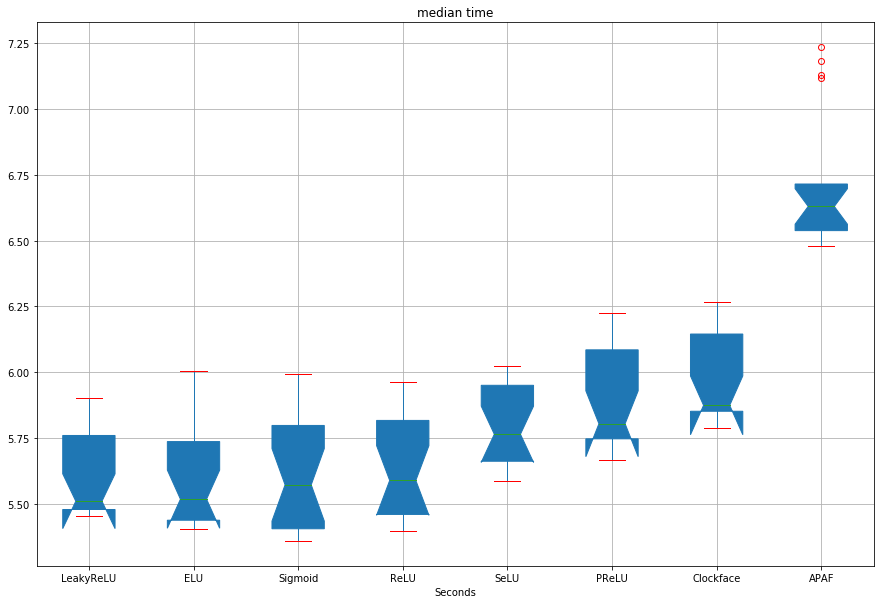

In [0]:
col = 'median'
boxplot_sorted(tt, by='Function', column=col)
plt.title(col+' time')
plt.xlabel('Seconds')

Text(0.5, 0, 'Seconds')

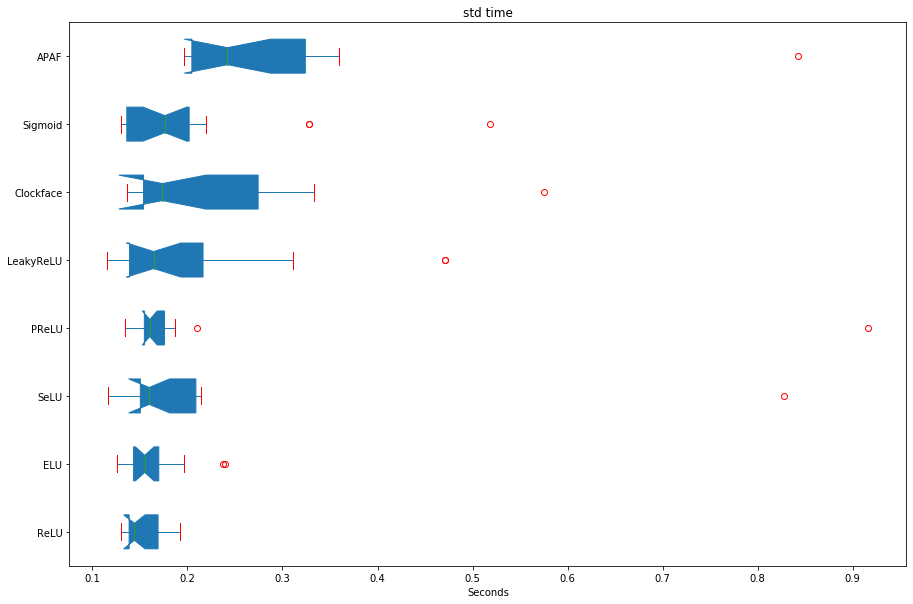

In [0]:
col = 'std'
boxplot_sorted(tt, by='Function', column=col)
plt.title(col+' time')
plt.xlabel('Seconds')

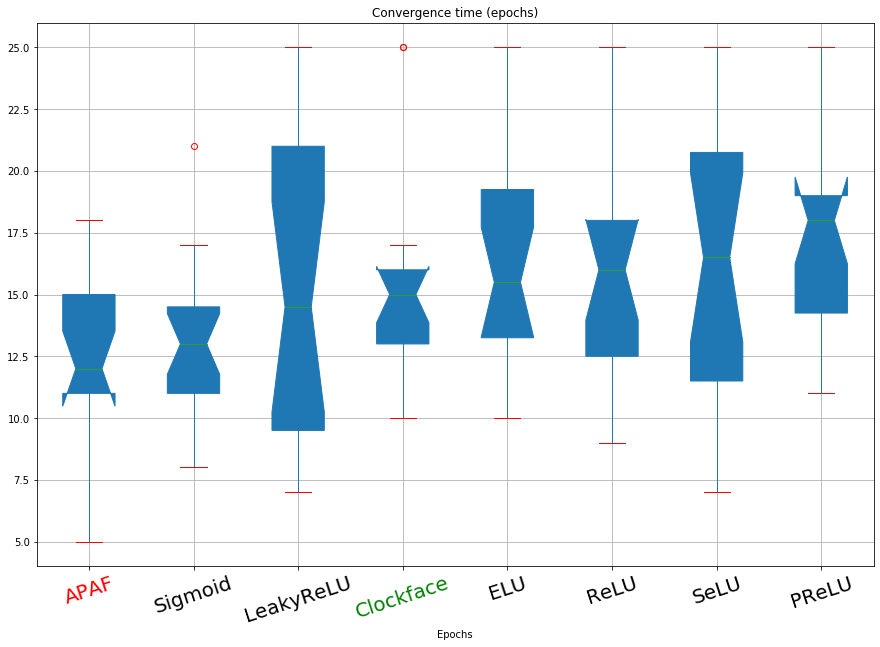

In [0]:
col = 'len'
boxplot_sorted(tt, by='Function', column=col)
plt.title('Convergence time (epochs)')
plt.xlabel('Epochs')

ax = plt.gcf().gca()
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(20)
                tick.label.set_rotation(18)
                if tick.label.get_text() == 'Clockface':
                  tick.label.set_color('g')
                if tick.label.get_text() == 'APAF':
                  tick.label.set_color('r')

In [0]:
l = tt.groupby('Function').agg(np.mean)['len']

In [0]:
a = res.groupby('Function').agg(np.mean)['Accuracy']

In [0]:
t = tt.groupby('Function').agg(np.mean)['max']

In [0]:
t

Function
APAF         7.681197
Clockface    6.820799
ELU          6.205123
LeakyReLU    6.348310
PReLU        6.657418
ReLU         6.189132
SeLU         6.544409
Sigmoid      6.311132
Name: max, dtype: float64

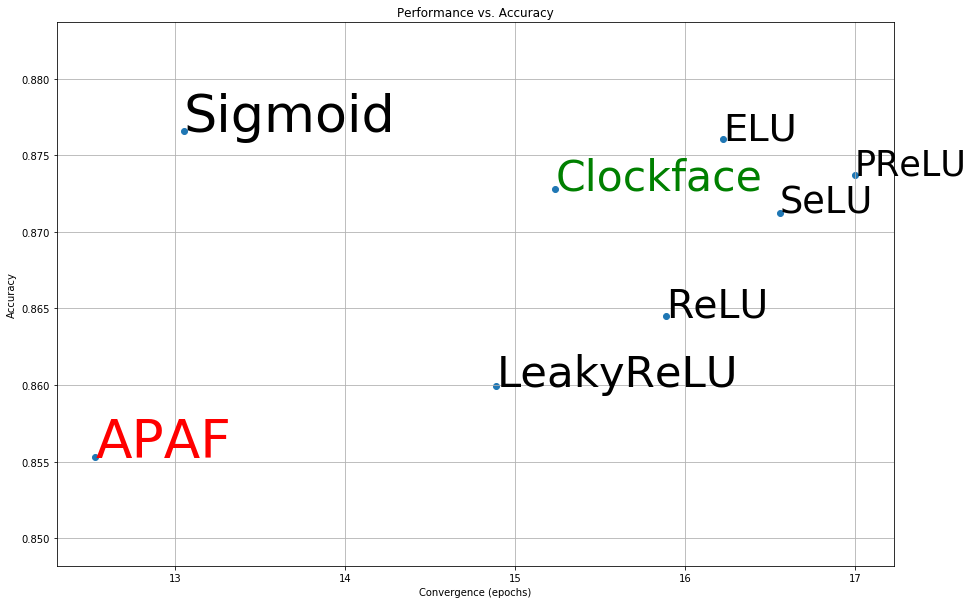

In [0]:
plt.scatter(l,a)
plt.xlabel('Convergence (epochs)')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Performance vs. Accuracy')
for lab in l.index:
  if 'Clockface' in lab:
    plt.text(l[lab],a[lab],lab, size = 5*a[lab]*(25-l[lab]), color = 'g')
  elif 'APAF' in lab:
    plt.text(l[lab],a[lab],lab, size = 5*a[lab]*(25-l[lab]), color = 'r')
  else:
    plt.text(l[lab],a[lab],lab, size = 5*a[lab]*(25-l[lab]))